# Import libraries 

In [87]:
import os

import pickle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype

# preprocessing
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.utils import resample

# modelling
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb

# model selection
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold

# model visualisation 
from sklearn.tree import plot_tree

# performance evaluation
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score
from sklearn.metrics import SCORERS
from sklearn.metrics import f1_score, recall_score, precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import confusion_matrix

# Set options

In [39]:
pd.set_option("display.max_rows", 100, "display.max_columns",200)

# General functions

In [40]:
def EDA(df, distplot=False):


    
    
    nrows = df.shape[0]

    for i, col in enumerate(df.columns):
        print('*'*200)
        nona =sum(df[col].notna())
        na = nrows-nona
        uniq =len(df[col].unique())

        print(i, ": ", col, '\n')
        print("Data type: ", df.dtypes[i])

        if nona == uniq:
            print("- ID variable: YES")

        print('- No. of null values: ', na)
        print('- No. of non-null values: ', nona)
        print('- No. of unique values: ', uniq)


        if uniq <= 50:
            print(df[col].value_counts().sort_index())

        else:
            if is_numeric_dtype(df[col]):
                print("- min: ", df[col].min())
                print("- max: ", df[col].max())
                
                if distplot:
                    plt.figure(i)
                    sns.distplot(df[col])
                    plt.show()
                
                else:    
                    fig, ax = plt.subplots(figsize =(10, 7))
                    ax.hist(df[col], bins=20)
                    plt.show()
                
            else:
                print("- This is a str variable with more than 50 categories ")
                print('- Sample 50 categories:\n', np.random.choice(df[col].unique(), 50))

        print('\n')

In [41]:
def numeric_downcast(df):
    fcols = df.select_dtypes('float').columns
    icols = df.select_dtypes('integer').columns
    
    df[fcols] = df[fcols].apply(pd.to_numeric, downcast='float')
    df[icols] = df[icols].apply(pd.to_numeric, downcast='integer')
    
    return df

# Load data

## Identity 

In [49]:
# read and explore
df_id = pd.read_csv("./train_identity.csv", dtype={'TransactionID':str})
df_id = numeric_downcast(df_id)
print('Shape: ',df_id.shape)
df_id.info()

Shape:  (144233, 41)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144233 entries, 0 to 144232
Data columns (total 41 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   TransactionID  144233 non-null  object 
 1   id_01          144233 non-null  float32
 2   id_02          140872 non-null  float32
 3   id_03          66324 non-null   float32
 4   id_04          66324 non-null   float32
 5   id_05          136865 non-null  float32
 6   id_06          136865 non-null  float32
 7   id_07          5155 non-null    float32
 8   id_08          5155 non-null    float32
 9   id_09          74926 non-null   float32
 10  id_10          74926 non-null   float32
 11  id_11          140978 non-null  float32
 12  id_12          144233 non-null  object 
 13  id_13          127320 non-null  float32
 14  id_14          80044 non-null   float32
 15  id_15          140985 non-null  object 
 16  id_16          129340 non-null  object 
 17  id_17   

In [6]:
# explore uniqueness of id column
len(df_id['TransactionID'].unique()), len(df_id)

(144233, 144233)

## Transaction

In [7]:
# read and explore
df_trans = pd.read_csv("./train_transaction.csv", dtype = {'TransactionID':str})
df_trans = numeric_downcast(df_trans)
print("Shape: ", df_trans.shape)
df_trans.info()

Shape:  (590540, 394)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590540 entries, 0 to 590539
Columns: 394 entries, TransactionID to V339
dtypes: float32(376), int16(1), int32(1), int8(1), object(15)
memory usage: 918.6+ MB


In [9]:
# explore uniqueness of id column
len(df_trans['TransactionID'].unique()), len(df_trans)

(590540, 590540)

# Merge tables

In [10]:
# keep only those transactions that have identity info 
df_id_trans = pd.merge(df_trans, df_id, how="inner", on = "TransactionID")
df_id_trans.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 144233 entries, 0 to 144232
Columns: 434 entries, TransactionID to DeviceInfo
dtypes: float32(399), int16(1), int32(1), int8(1), object(32)
memory usage: 256.8+ MB


# Drop columns with too many missing values

In [12]:
# explore how many null values per column
id_trans_NA = df_id_trans.isnull().mean()
display(id_trans_NA)

TransactionID     0.000000
isFraud           0.000000
TransactionDT     0.000000
TransactionAmt    0.000000
ProductCD         0.000000
                    ...   
id_36             0.022519
id_37             0.022519
id_38             0.022519
DeviceType        0.023732
DeviceInfo        0.177262
Length: 434, dtype: float64

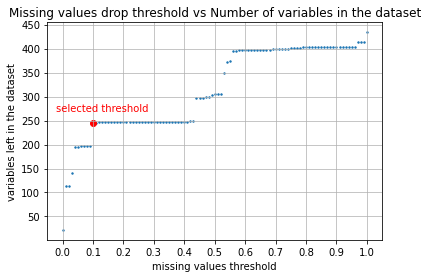

Let's select the best value


,NA threshold,VARS kept
0,0.00,22
1,0.01,114
2,0.02,114
3,0.03,141
4,0.04,194
5,0.05,194
6,0.06,196
7,0.07,196
8,0.08,196
9,0.09,196


In [50]:
################## explore how many variables would be kept as a result of changing the threshold value

# thresholds to be checked
NA_threshold = np.arange(0,1.01,0.01)
vars_kept = []

# store variables count for various thresholds
for i in NA_threshold:
    vars_kept.append(sum(id_trans_NA <= i))

# plot results
plt.scatter(NA_threshold, vars_kept, s = 2)
plt.xlabel("missing values threshold")
plt.ylabel("variables left in the dataset")
plt.title("Missing values drop threshold vs Number of variables in the dataset")
plt.grid( alpha=0.9)
plt.grid(which='minor',linestyle="-")
#plt.minorticks_on()
plt.locator_params(nbins=15)
plt.scatter(0.1,244,color='red')
plt.text(-0.02, 270, "selected threshold", fontsize=10, color='red')
plt.show()

# plot table
print("Let's select the best value")
display(pd.DataFrame({"NA threshold" : NA_threshold, "VARS kept" : vars_kept}).head(40))

# keep only those with less or equal than 10% missing values
ind = id_trans_NA[id_trans_NA<=0.1].index
df_id_trans_remNA = df_id_trans[ind].copy()

In [51]:
# class distribution before dropping rows without identity info 
df_trans['isFraud'].value_counts() / len(df_trans)

0    0.96501
1    0.03499
Name: isFraud, dtype: float64

In [52]:
# dataset after dropping rows without identity info
df_id_trans_remNA['isFraud'].value_counts() / len(df_id_trans_remNA)

0    0.92153
1    0.07847
Name: isFraud, dtype: float64

# Explore variables

## EDA

********************************************************************************************************************************************************************************************************
0 :  TransactionID 

Data type:  object
- ID variable: YES
- No. of null values:  0
- No. of non-null values:  144233
- No. of unique values:  144233
- This is a str variable with more than 50 categories 
- Sample 50 categories:
 ['3109338' '3365982' '3094909' '3051622' '2992404' '3493376' '3576642'
 '3093178' '3112275' '3031723' '3359642' '3199909' '3435605' '3085099'
 '3550842' '3288173' '3522414' '3391117' '3006398' '3008546' '3527161'
 '3447924' '3247774' '2996542' '3405055' '3401994' '3529835' '3443796'
 '3204147' '3374080' '3074902' '3329111' '3201060' '3089384' '3329639'
 '3066104' '3427507' '3127862' '3062384' '3030081' '3102044' '3219573'
 '3123215' '3348171' '3041145' '3076534' '3546353' '3179459' '3065960'
 '3285529']


**********************************************************

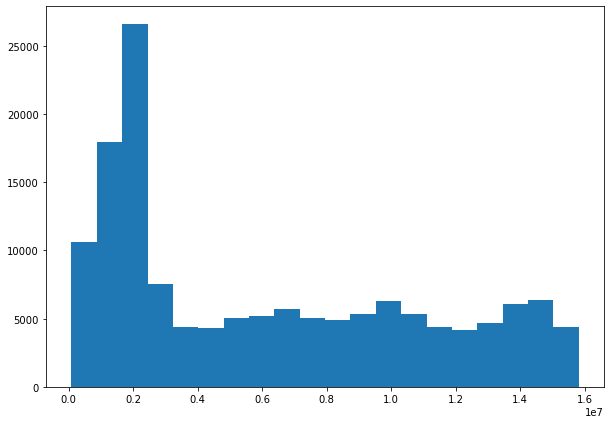



********************************************************************************************************************************************************************************************************
3 :  TransactionAmt 

Data type:  float32
- No. of null values:  0
- No. of non-null values:  144233
- No. of unique values:  7830
- min:  0.25099998712539673
- max:  1800.0


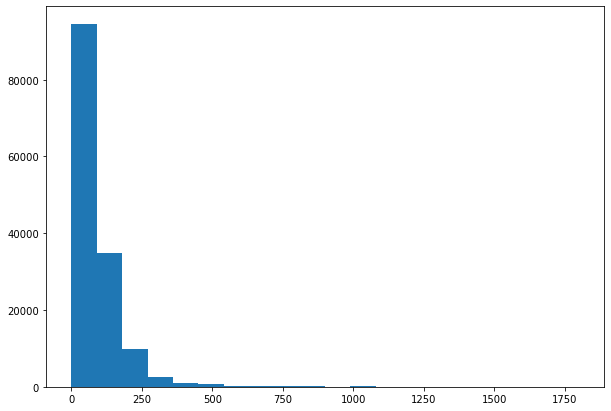



********************************************************************************************************************************************************************************************************
4 :  ProductCD 

Data type:  object
- No. of null values:  0
- No. of non-null values:  144233
- No. of unique values:  4
C    62192
H    32908
R    37548
S    11585
Name: ProductCD, dtype: int64


********************************************************************************************************************************************************************************************************
5 :  card1 

Data type:  int16
- No. of null values:  0
- No. of non-null values:  144233
- No. of unique values:  8499
- min:  1000
- max:  18396


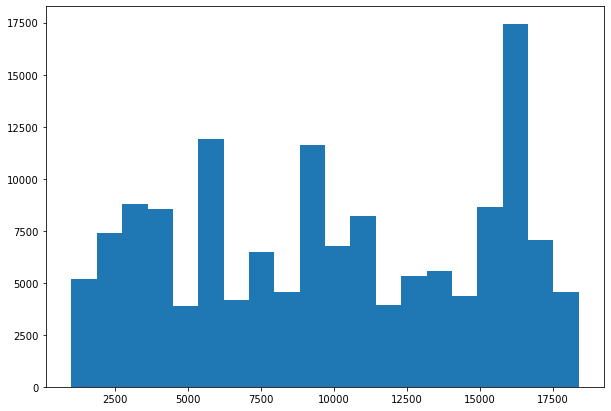



********************************************************************************************************************************************************************************************************
6 :  card2 

Data type:  float32
- No. of null values:  902
- No. of non-null values:  143331
- No. of unique values:  483
- min:  100.0
- max:  600.0


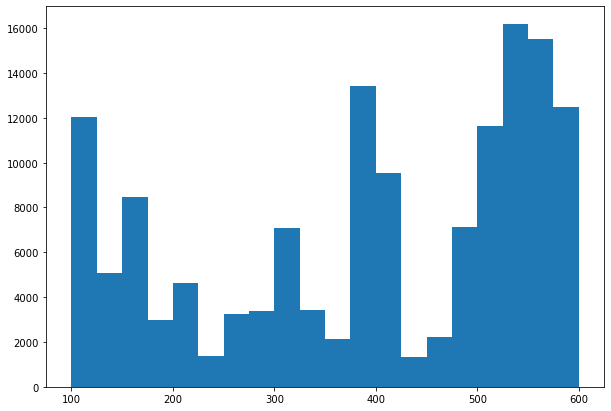



********************************************************************************************************************************************************************************************************
7 :  card3 

Data type:  float32
- No. of null values:  172
- No. of non-null values:  144061
- No. of unique values:  104
- min:  100.0
- max:  231.0


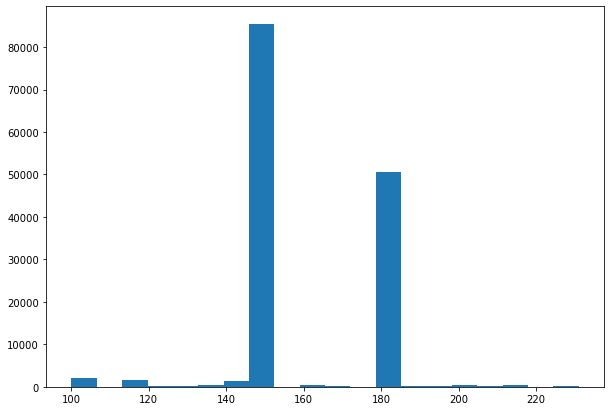



********************************************************************************************************************************************************************************************************
8 :  card4 

Data type:  object
- No. of null values:  184
- No. of non-null values:  144049
- No. of unique values:  5
american express     8298
discover             2266
mastercard          44186
visa                89299
Name: card4, dtype: int64


********************************************************************************************************************************************************************************************************
9 :  card5 

Data type:  float32
- No. of null values:  956
- No. of non-null values:  143277
- No. of unique values:  107
- min:  100.0
- max:  237.0


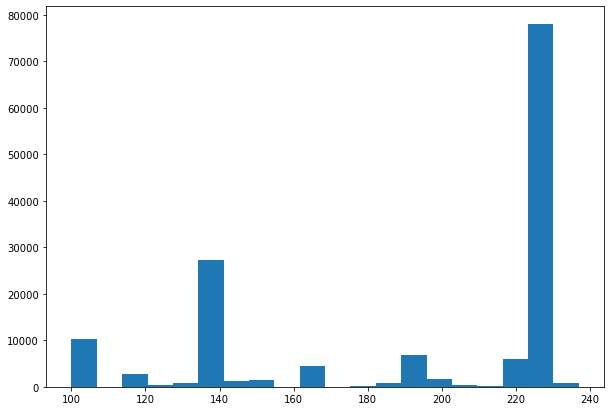



********************************************************************************************************************************************************************************************************
10 :  card6 

Data type:  object
- No. of null values:  178
- No. of non-null values:  144055
- No. of unique values:  4
charge card       15
credit         75090
debit          68950
Name: card6, dtype: int64


********************************************************************************************************************************************************************************************************
11 :  P_emaildomain 

Data type:  object
- No. of null values:  13391
- No. of non-null values:  130842
- No. of unique values:  60
- This is a str variable with more than 50 categories 
- Sample 50 categories:
 ['cfl.rr.com' 'rocketmail.com' 'outlook.es' 'yahoo.co.jp' 'yahoo.com.mx'
 'bellsouth.net' 'sbcglobal.net' 'optonline.net' 'juno.com' 'yahoo.es'
 'centurylink.net' 'embarqma

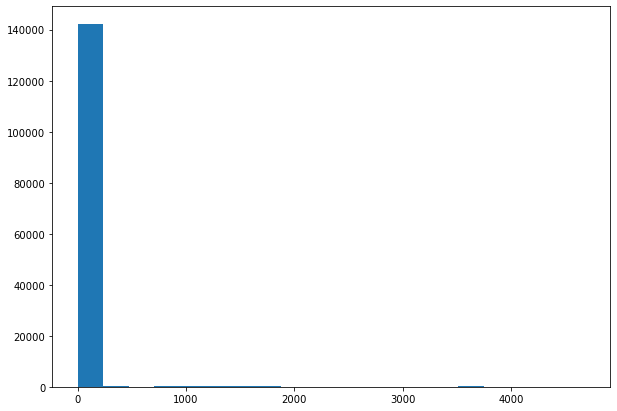



********************************************************************************************************************************************************************************************************
14 :  C2 

Data type:  float32
- No. of null values:  0
- No. of non-null values:  144233
- No. of unique values:  1182
- min:  0.0
- max:  5691.0


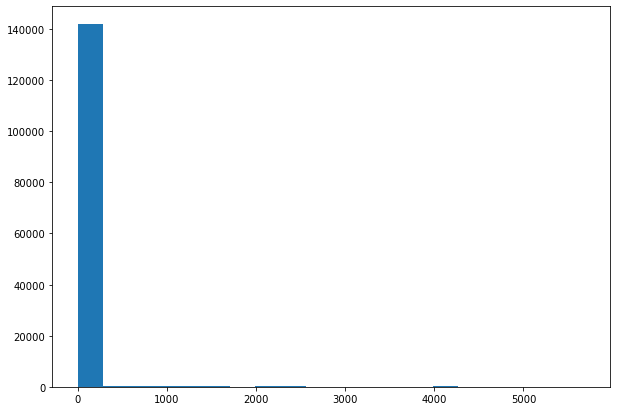



********************************************************************************************************************************************************************************************************
15 :  C3 

Data type:  float32
- No. of null values:  0
- No. of non-null values:  144233
- No. of unique values:  27
0.0     141815
1.0       2126
2.0        180
3.0         58
4.0          7
5.0          3
6.0          1
7.0          2
8.0          2
9.0          5
10.0         2
11.0         5
12.0         2
13.0         3
14.0         3
15.0         2
16.0         6
17.0         2
18.0         1
19.0         1
20.0         1
21.0         1
22.0         1
23.0         1
24.0         1
25.0         1
26.0         1
Name: C3, dtype: int64


********************************************************************************************************************************************************************************************************
16 :  C4 

Data type:  float32
- No. of null val

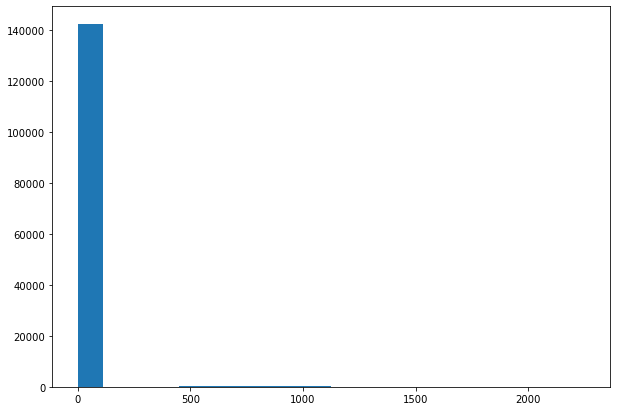



********************************************************************************************************************************************************************************************************
17 :  C5 

Data type:  float32
- No. of null values:  0
- No. of non-null values:  144233
- No. of unique values:  1
0.0    144233
Name: C5, dtype: int64


********************************************************************************************************************************************************************************************************
18 :  C6 

Data type:  float32
- No. of null values:  0
- No. of non-null values:  144233
- No. of unique values:  1194
- min:  0.0
- max:  2253.0


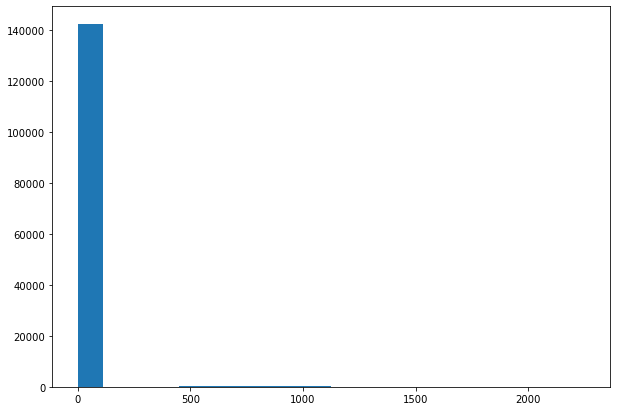



********************************************************************************************************************************************************************************************************
19 :  C7 

Data type:  float32
- No. of null values:  0
- No. of non-null values:  144233
- No. of unique values:  1036
- min:  0.0
- max:  2255.0


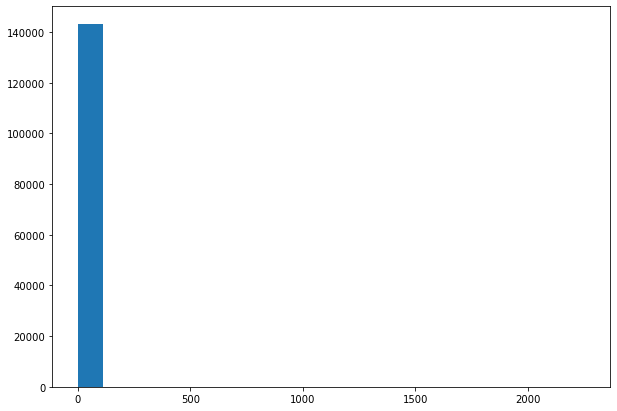



********************************************************************************************************************************************************************************************************
20 :  C8 

Data type:  float32
- No. of null values:  0
- No. of non-null values:  144233
- No. of unique values:  1236
- min:  0.0
- max:  3331.0


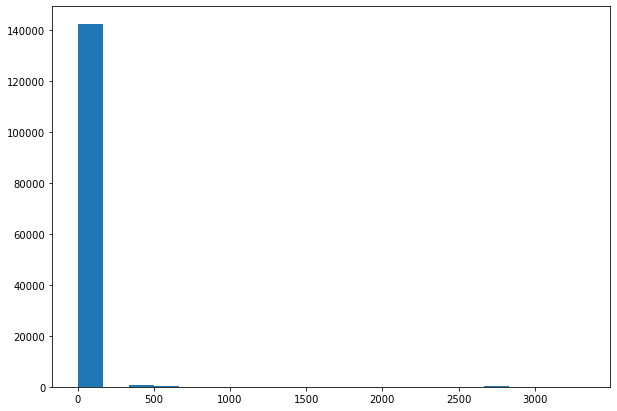



********************************************************************************************************************************************************************************************************
21 :  C9 

Data type:  float32
- No. of null values:  0
- No. of non-null values:  144233
- No. of unique values:  1
0.0    144233
Name: C9, dtype: int64


********************************************************************************************************************************************************************************************************
22 :  C10 

Data type:  float32
- No. of null values:  0
- No. of non-null values:  144233
- No. of unique values:  1211
- min:  0.0
- max:  3257.0


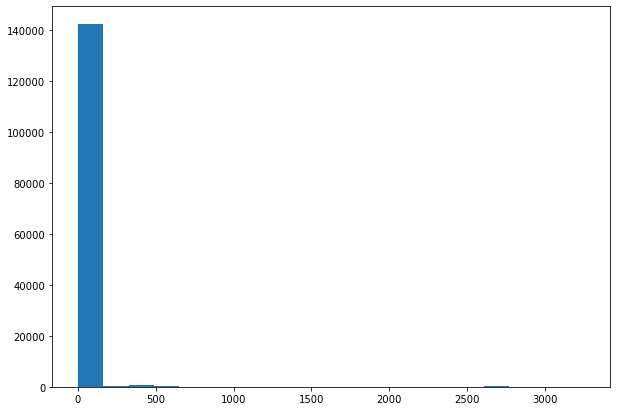



********************************************************************************************************************************************************************************************************
23 :  C11 

Data type:  float32
- No. of null values:  0
- No. of non-null values:  144233
- No. of unique values:  1354
- min:  0.0
- max:  3188.0


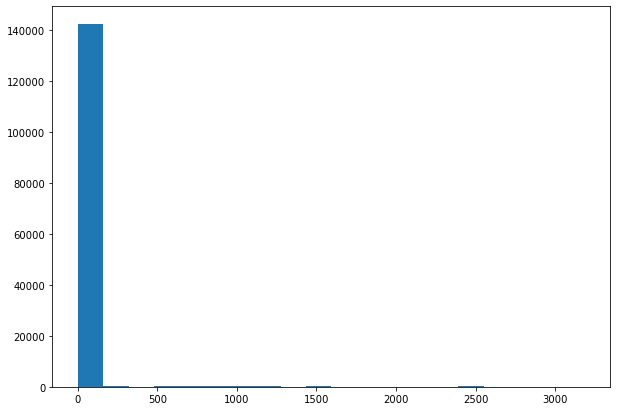



********************************************************************************************************************************************************************************************************
24 :  C12 

Data type:  float32
- No. of null values:  0
- No. of non-null values:  144233
- No. of unique values:  1126
- min:  0.0
- max:  3188.0


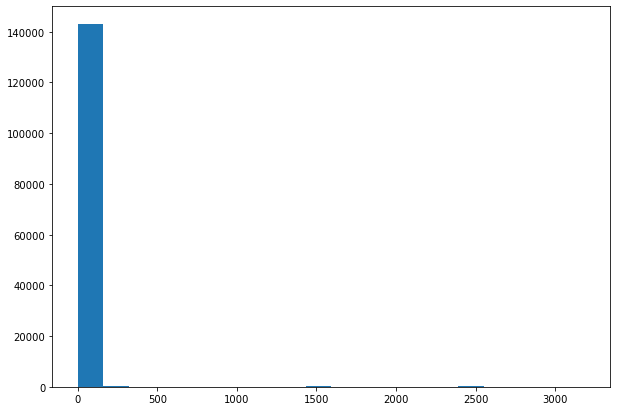



********************************************************************************************************************************************************************************************************
25 :  C13 

Data type:  float32
- No. of null values:  0
- No. of non-null values:  144233
- No. of unique values:  1362
- min:  0.0
- max:  2918.0


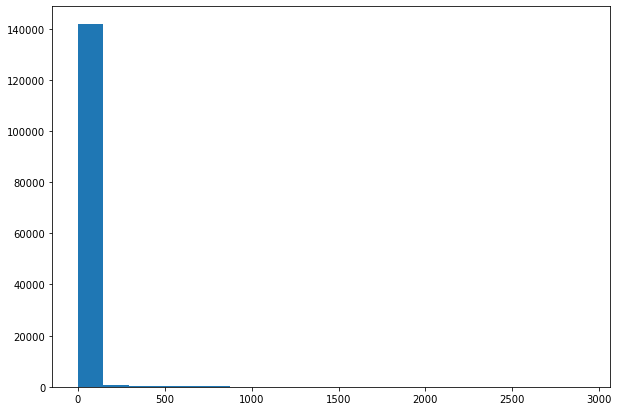



********************************************************************************************************************************************************************************************************
26 :  C14 

Data type:  float32
- No. of null values:  0
- No. of non-null values:  144233
- No. of unique values:  994
- min:  0.0
- max:  1429.0


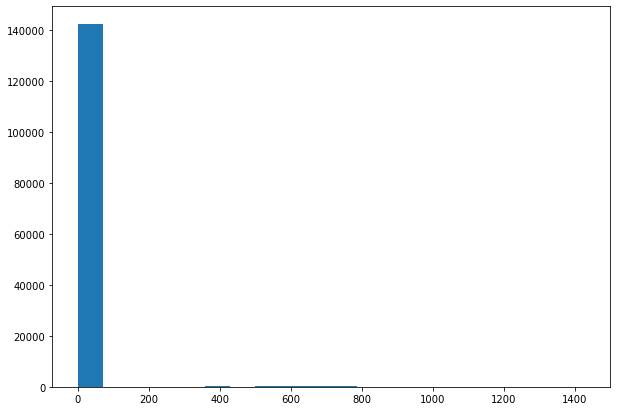



********************************************************************************************************************************************************************************************************
27 :  D1 

Data type:  float32
- No. of null values:  218
- No. of non-null values:  144015
- No. of unique values:  642
- min:  0.0
- max:  640.0


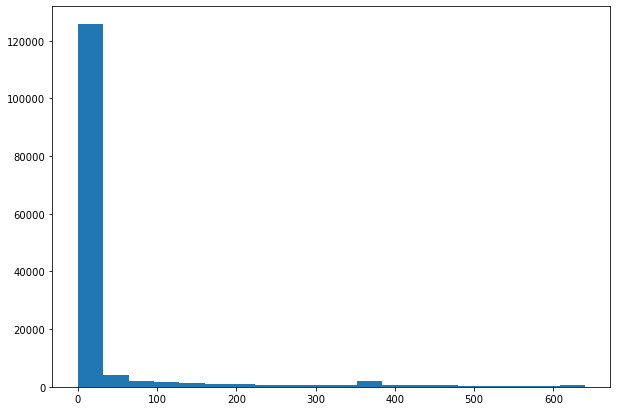



********************************************************************************************************************************************************************************************************
28 :  V95 

Data type:  float32
- No. of null values:  64
- No. of non-null values:  144169
- No. of unique values:  881
- min:  0.0
- max:  880.0


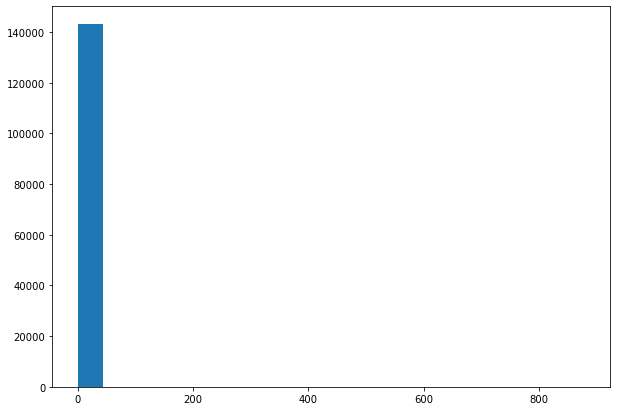



********************************************************************************************************************************************************************************************************
29 :  V96 

Data type:  float32
- No. of null values:  64
- No. of non-null values:  144169
- No. of unique values:  1410
- min:  0.0
- max:  1410.0


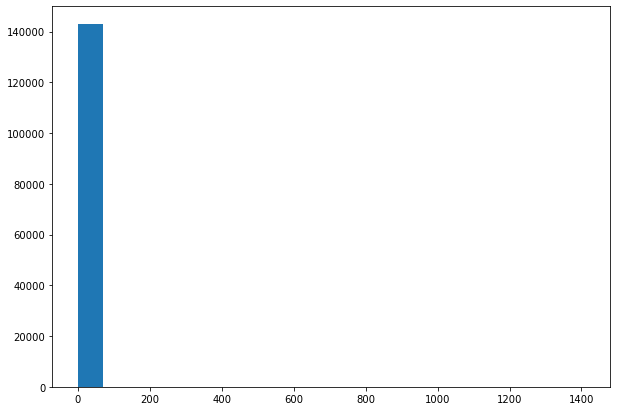



********************************************************************************************************************************************************************************************************
30 :  V97 

Data type:  float32
- No. of null values:  64
- No. of non-null values:  144169
- No. of unique values:  976
- min:  0.0
- max:  976.0


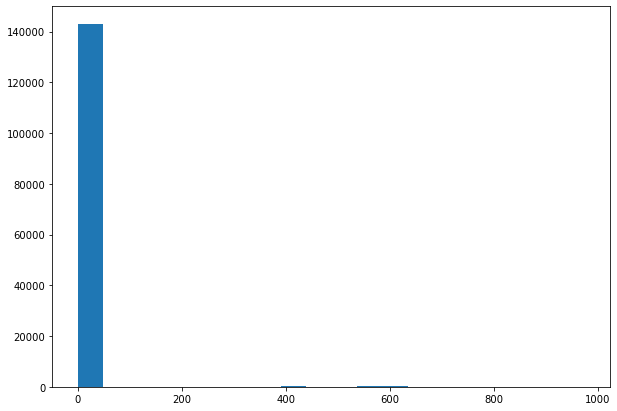



********************************************************************************************************************************************************************************************************
31 :  V98 

Data type:  float32
- No. of null values:  64
- No. of non-null values:  144169
- No. of unique values:  14
0.0     140510
1.0       2891
2.0        650
3.0         69
4.0         30
5.0          9
6.0          3
7.0          2
8.0          1
9.0          1
10.0         1
11.0         1
12.0         1
Name: V98, dtype: int64


********************************************************************************************************************************************************************************************************
32 :  V99 

Data type:  float32
- No. of null values:  64
- No. of non-null values:  144169
- No. of unique values:  45
0.0     135705
1.0       3695
2.0        830
3.0        453
4.0        286
5.0        238
6.0        178
7.0        158
8.0        124


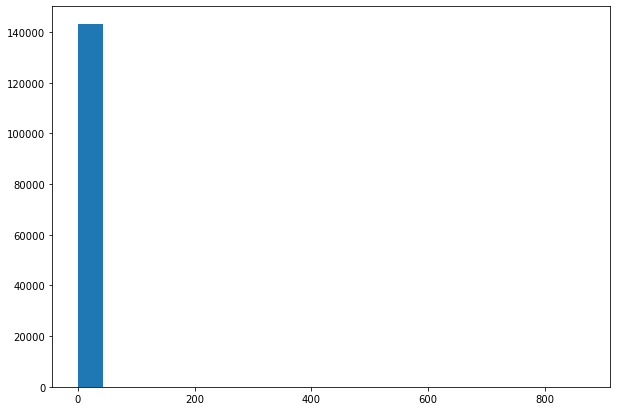



********************************************************************************************************************************************************************************************************
35 :  V102 

Data type:  float32
- No. of null values:  64
- No. of non-null values:  144169
- No. of unique values:  1285
- min:  0.0
- max:  1285.0


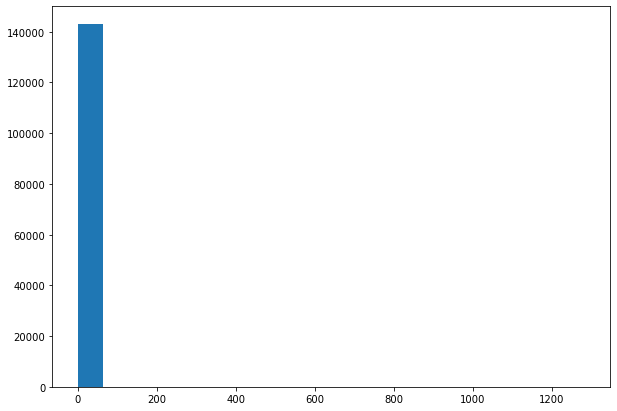



********************************************************************************************************************************************************************************************************
36 :  V103 

Data type:  float32
- No. of null values:  64
- No. of non-null values:  144169
- No. of unique values:  928
- min:  0.0
- max:  928.0


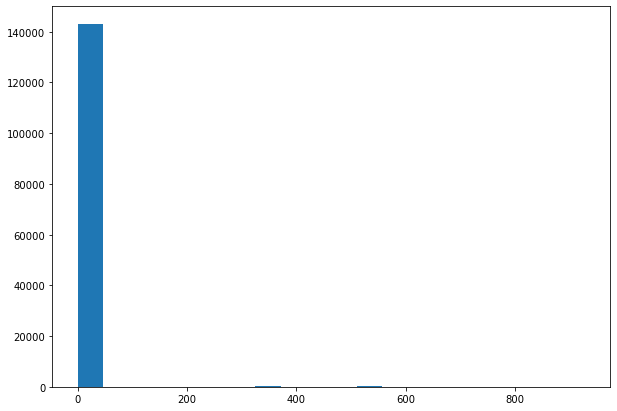



********************************************************************************************************************************************************************************************************
37 :  V104 

Data type:  float32
- No. of null values:  64
- No. of non-null values:  144169
- No. of unique values:  17
0.0     134953
1.0       5800
2.0       1333
3.0        430
4.0        156
5.0         71
6.0         39
7.0         29
8.0         27
9.0         15
10.0        10
11.0       997
12.0        72
13.0         4
14.0        18
15.0       215
Name: V104, dtype: int64


********************************************************************************************************************************************************************************************************
38 :  V105 

Data type:  float32
- No. of null values:  64
- No. of non-null values:  144169
- No. of unique values:  101
- min:  0.0
- max:  99.0


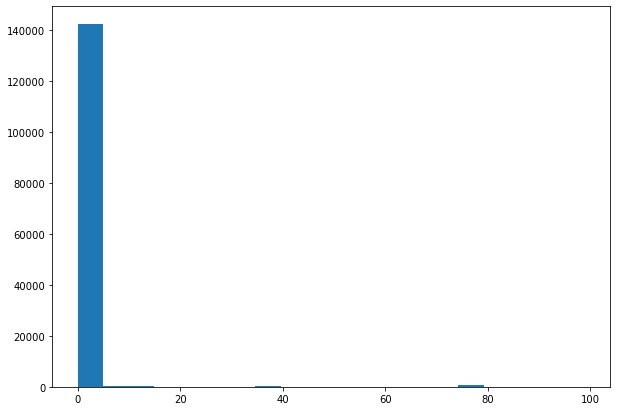



********************************************************************************************************************************************************************************************************
39 :  V106 

Data type:  float32
- No. of null values:  64
- No. of non-null values:  144169
- No. of unique values:  57
- min:  0.0
- max:  55.0


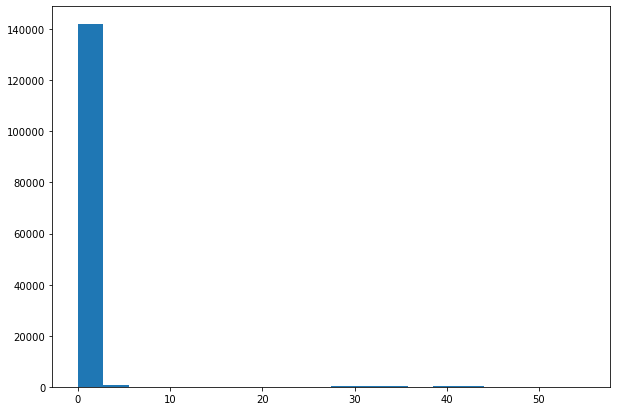



********************************************************************************************************************************************************************************************************
40 :  V107 

Data type:  float32
- No. of null values:  64
- No. of non-null values:  144169
- No. of unique values:  2
1.0    144169
Name: V107, dtype: int64


********************************************************************************************************************************************************************************************************
41 :  V108 

Data type:  float32
- No. of null values:  64
- No. of non-null values:  144169
- No. of unique values:  9
0.0         1
1.0    143206
2.0       807
3.0       108
4.0        35
5.0         7
6.0         1
7.0         4
Name: V108, dtype: int64


********************************************************************************************************************************************************************************

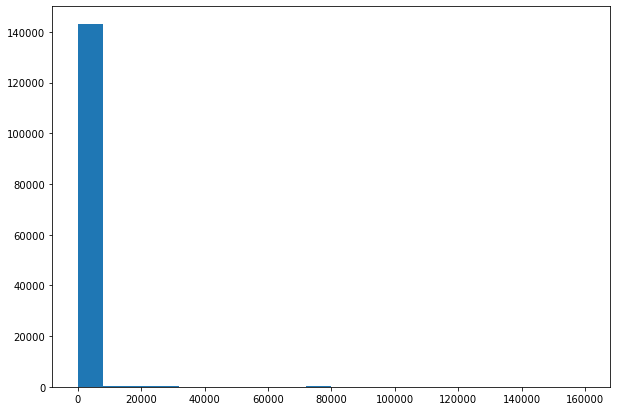



********************************************************************************************************************************************************************************************************
60 :  V127 

Data type:  float32
- No. of null values:  64
- No. of non-null values:  144169
- No. of unique values:  5250
- min:  0.0
- max:  160000.0


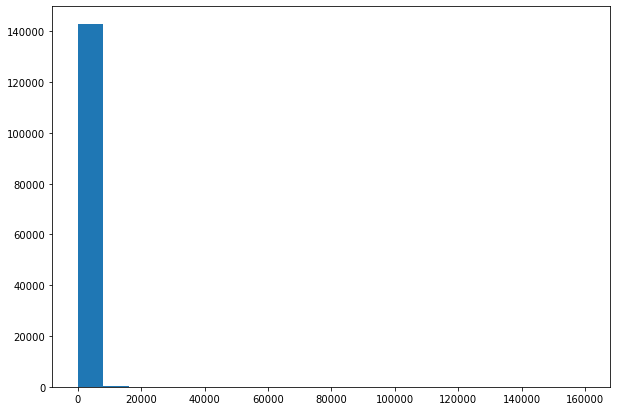



********************************************************************************************************************************************************************************************************
61 :  V128 

Data type:  float32
- No. of null values:  64
- No. of non-null values:  144169
- No. of unique values:  4812
- min:  0.0
- max:  160000.0


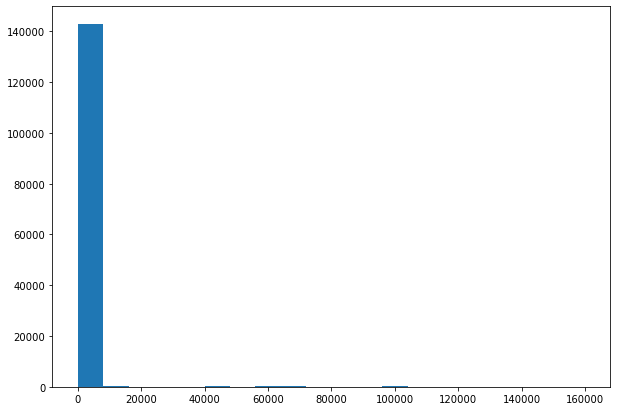



********************************************************************************************************************************************************************************************************
62 :  V129 

Data type:  float32
- No. of null values:  64
- No. of non-null values:  144169
- No. of unique values:  392
- min:  0.0
- max:  55125.0


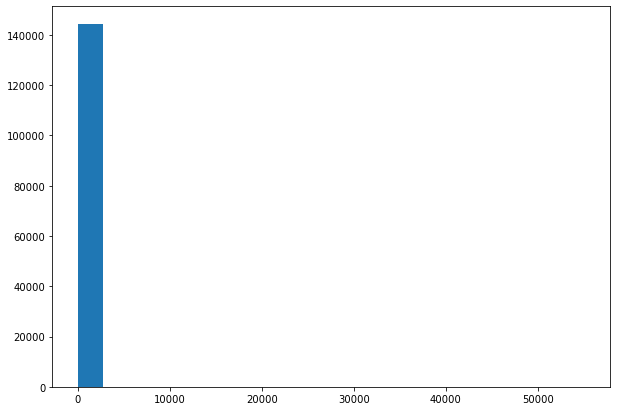



********************************************************************************************************************************************************************************************************
63 :  V130 

Data type:  float32
- No. of null values:  64
- No. of non-null values:  144169
- No. of unique values:  946
- min:  0.0
- max:  55125.0


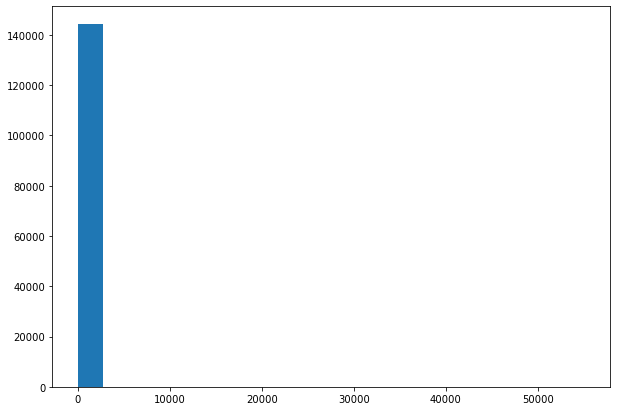



********************************************************************************************************************************************************************************************************
64 :  V131 

Data type:  float32
- No. of null values:  64
- No. of non-null values:  144169
- No. of unique values:  626
- min:  0.0
- max:  55125.0


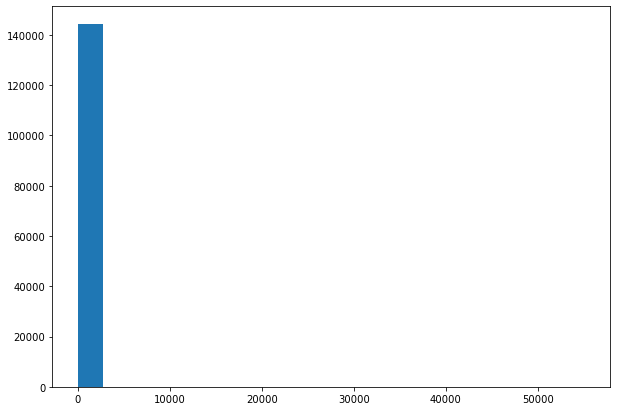



********************************************************************************************************************************************************************************************************
65 :  V132 

Data type:  float32
- No. of null values:  64
- No. of non-null values:  144169
- No. of unique values:  3795
- min:  0.0
- max:  93736.0


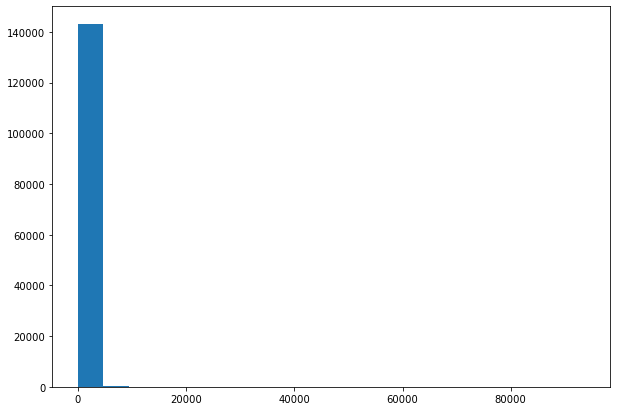



********************************************************************************************************************************************************************************************************
66 :  V133 

Data type:  float32
- No. of null values:  64
- No. of non-null values:  144169
- No. of unique values:  3856
- min:  0.0
- max:  133915.0


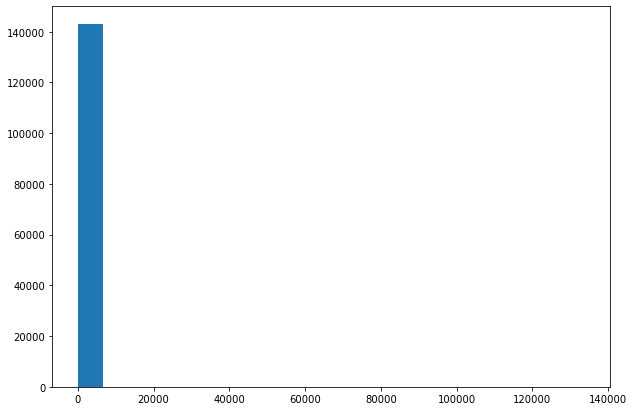



********************************************************************************************************************************************************************************************************
67 :  V134 

Data type:  float32
- No. of null values:  64
- No. of non-null values:  144169
- No. of unique values:  3805
- min:  0.0
- max:  98476.0


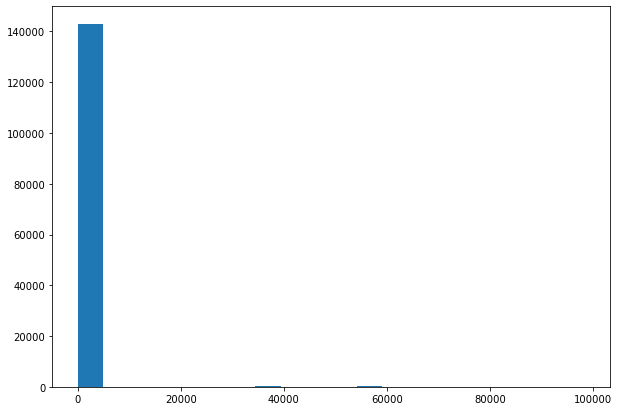



********************************************************************************************************************************************************************************************************
68 :  V135 

Data type:  float32
- No. of null values:  64
- No. of non-null values:  144169
- No. of unique values:  910
- min:  0.0
- max:  90750.0


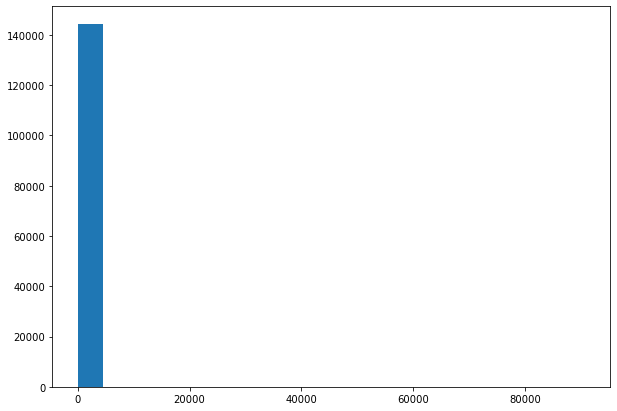



********************************************************************************************************************************************************************************************************
69 :  V136 

Data type:  float32
- No. of null values:  64
- No. of non-null values:  144169
- No. of unique values:  1033
- min:  0.0
- max:  90750.0


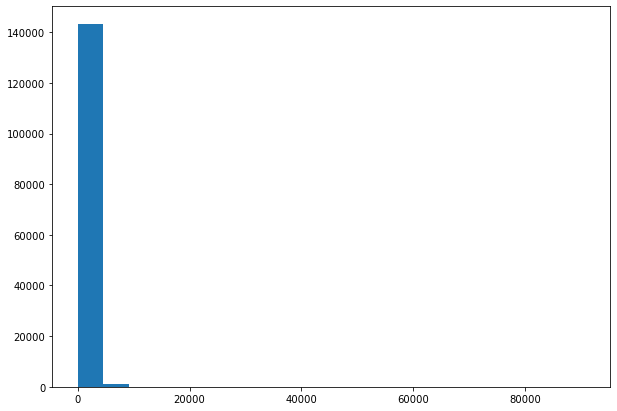



********************************************************************************************************************************************************************************************************
70 :  V137 

Data type:  float32
- No. of null values:  64
- No. of non-null values:  144169
- No. of unique values:  987
- min:  0.0
- max:  90750.0


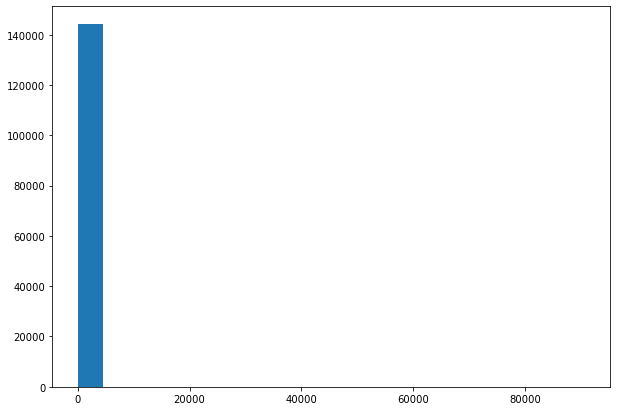



********************************************************************************************************************************************************************************************************
71 :  V167 

Data type:  float32
- No. of null values:  4602
- No. of non-null values:  139631
- No. of unique values:  874
- min:  0.0
- max:  872.0


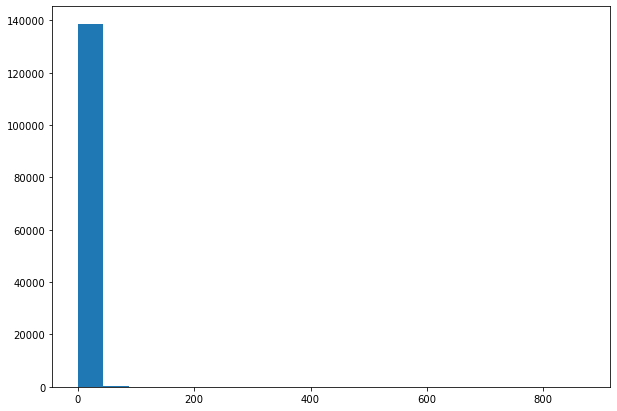



********************************************************************************************************************************************************************************************************
72 :  V168 

Data type:  float32
- No. of null values:  4602
- No. of non-null values:  139631
- No. of unique values:  966
- min:  0.0
- max:  964.0


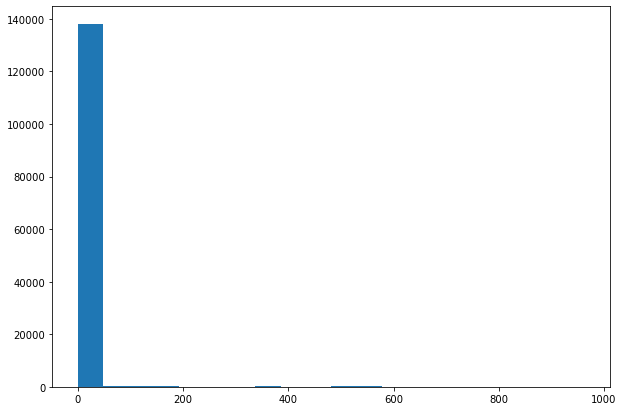



********************************************************************************************************************************************************************************************************
73 :  V169 

Data type:  float32
- No. of null values:  4414
- No. of non-null values:  139819
- No. of unique values:  21
0.0     130911
1.0       4117
2.0       1707
3.0       1034
4.0        702
5.0        394
6.0        333
7.0        177
8.0        112
9.0         69
10.0        53
11.0        54
12.0        28
13.0        58
14.0        13
15.0        25
16.0         6
17.0         4
18.0        21
19.0         1
Name: V169, dtype: int64


********************************************************************************************************************************************************************************************************
74 :  V170 

Data type:  float32
- No. of null values:  4414
- No. of non-null values:  139819
- No. of unique values:  50
0.0       9693
1.0     

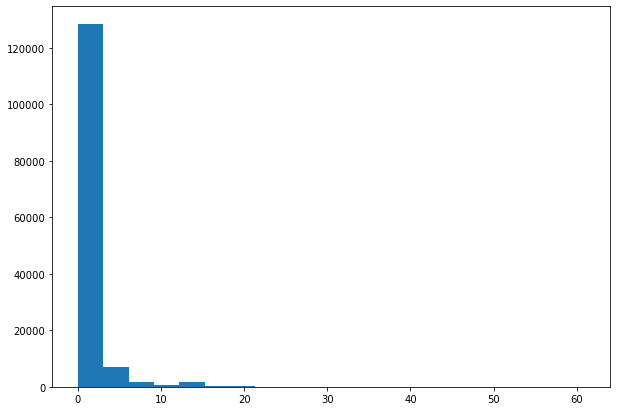



********************************************************************************************************************************************************************************************************
76 :  V172 

Data type:  float32
- No. of null values:  4602
- No. of non-null values:  139631
- No. of unique values:  33
0.0     128800
1.0       8698
2.0       1361
3.0        265
4.0         63
5.0         46
6.0         39
7.0         48
8.0         22
9.0         23
10.0        19
11.0        26
12.0        25
13.0        24
14.0        15
15.0        11
16.0         9
17.0         8
18.0         8
19.0        14
20.0        14
21.0        18
22.0         7
23.0         2
24.0        11
25.0         9
26.0         3
27.0        16
28.0        15
29.0         8
30.0         3
31.0         1
Name: V172, dtype: int64


***********************************************************************************************************************************************************************

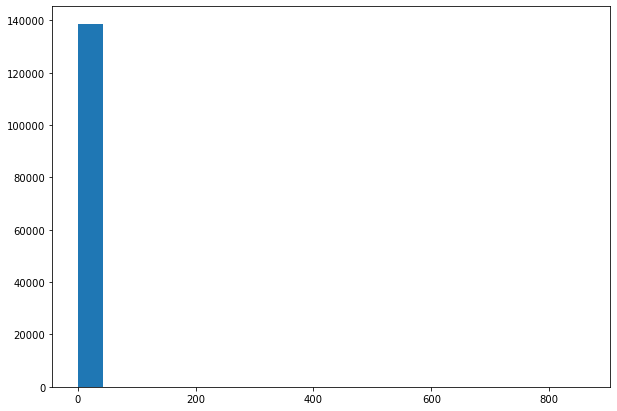



********************************************************************************************************************************************************************************************************
82 :  V178 

Data type:  float32
- No. of null values:  4602
- No. of non-null values:  139631
- No. of unique values:  1237
- min:  0.0
- max:  1235.0


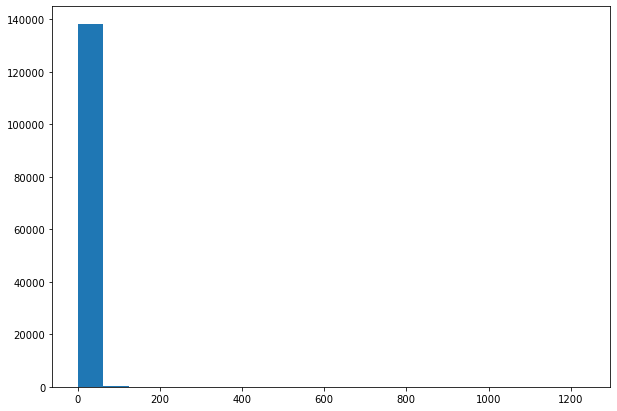



********************************************************************************************************************************************************************************************************
83 :  V179 

Data type:  float32
- No. of null values:  4602
- No. of non-null values:  139631
- No. of unique values:  922
- min:  0.0
- max:  920.0


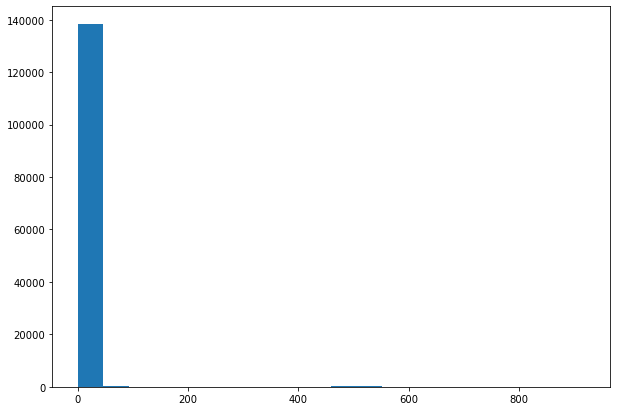



********************************************************************************************************************************************************************************************************
84 :  V180 

Data type:  float32
- No. of null values:  4414
- No. of non-null values:  139819
- No. of unique values:  85
- min:  0.0
- max:  83.0


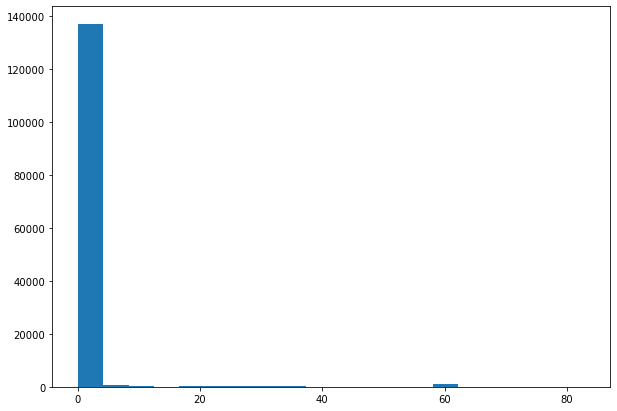



********************************************************************************************************************************************************************************************************
85 :  V181 

Data type:  float32
- No. of null values:  4602
- No. of non-null values:  139631
- No. of unique values:  26
0.0     125518
1.0       8514
2.0       2597
3.0        953
4.0        403
5.0        164
6.0         87
7.0         62
8.0         42
9.0         21
10.0        16
11.0       986
12.0        54
13.0        11
14.0        12
15.0       179
16.0         2
17.0         1
18.0         1
19.0         1
20.0         1
21.0         1
22.0         1
23.0         2
24.0         2
Name: V181, dtype: int64


********************************************************************************************************************************************************************************************************
86 :  V182 

Data type:  float32
- No. of null values:  4602
- No. of n

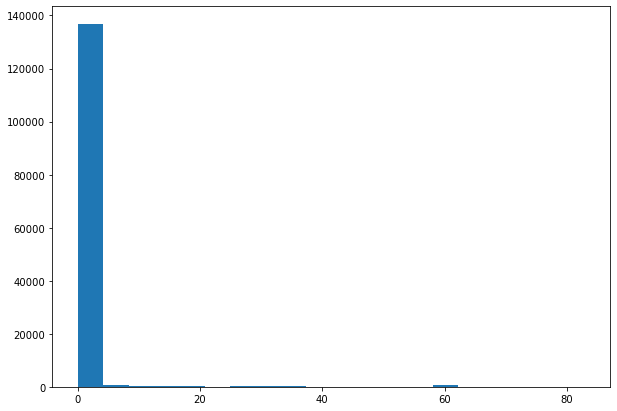



********************************************************************************************************************************************************************************************************
87 :  V183 

Data type:  float32
- No. of null values:  4602
- No. of non-null values:  139631
- No. of unique values:  43
0.0     124108
1.0       8833
2.0       2688
3.0       1069
4.0        481
5.0        242
6.0        137
7.0        134
8.0         92
9.0         46
10.0        71
11.0        80
12.0        56
13.0        80
14.0        56
15.0        49
16.0        45
17.0         9
18.0        12
19.0         5
20.0         6
21.0         3
22.0         9
23.0        10
24.0         8
25.0         5
26.0        65
27.0       658
28.0         6
29.0        10
30.0       346
31.0       113
32.0        21
33.0         8
34.0         4
35.0         3
36.0        39
37.0        16
38.0         2
39.0         2
40.0         3
41.0         1
Name: V183, dtype: int64


*****************

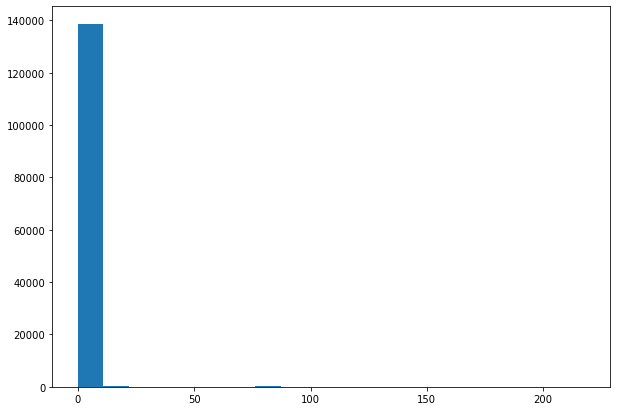



********************************************************************************************************************************************************************************************************
92 :  V188 

Data type:  float32
- No. of null values:  4414
- No. of non-null values:  139819
- No. of unique values:  32
0.0       9693
1.0     123940
2.0       4257
3.0        877
4.0        377
5.0        194
6.0        158
7.0        107
8.0         35
9.0         39
10.0        16
11.0        44
12.0        13
13.0         8
14.0        22
15.0         7
16.0         4
17.0         7
18.0         4
19.0         1
20.0         1
21.0         1
22.0         3
23.0         1
24.0         1
25.0         2
26.0         2
27.0         1
28.0         1
29.0         1
30.0         2
Name: V188, dtype: int64


**************************************************************************************************************************************************************************************

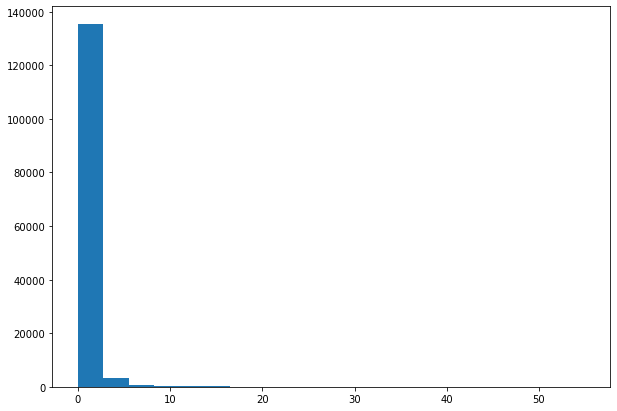



********************************************************************************************************************************************************************************************************
106 :  V202 

Data type:  float32
- No. of null values:  4602
- No. of non-null values:  139631
- No. of unique values:  10971
- min:  0.0
- max:  104060.0


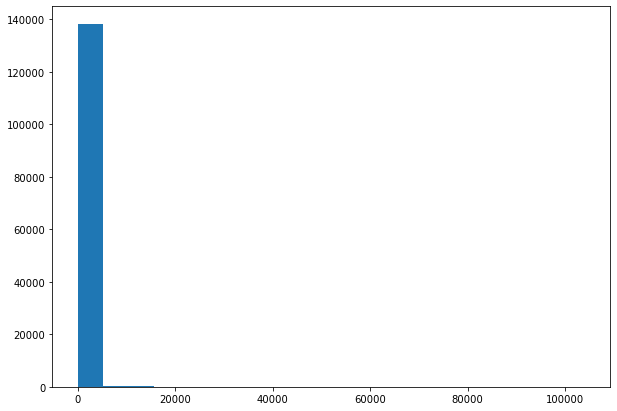



********************************************************************************************************************************************************************************************************
107 :  V203 

Data type:  float32
- No. of null values:  4602
- No. of non-null values:  139631
- No. of unique values:  14952
- min:  0.0
- max:  139777.0


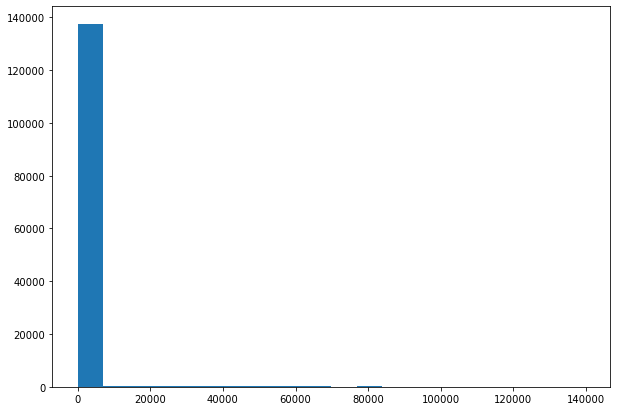



********************************************************************************************************************************************************************************************************
108 :  V204 

Data type:  float32
- No. of null values:  4602
- No. of non-null values:  139631
- No. of unique values:  12859
- min:  0.0
- max:  104060.0


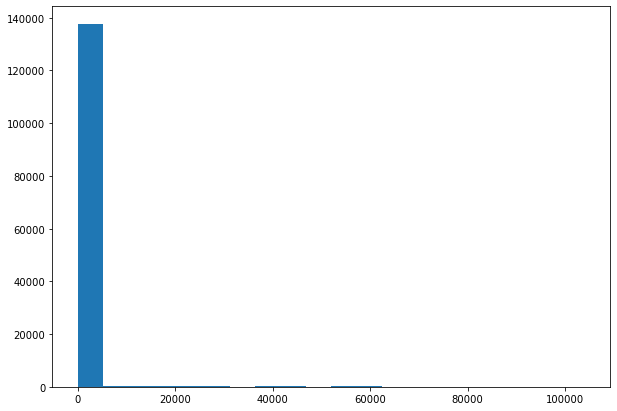



********************************************************************************************************************************************************************************************************
109 :  V205 

Data type:  float32
- No. of null values:  4602
- No. of non-null values:  139631
- No. of unique values:  2241
- min:  0.0
- max:  55125.0


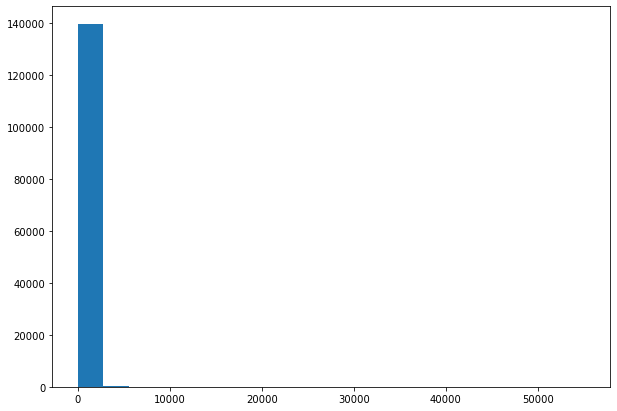



********************************************************************************************************************************************************************************************************
110 :  V206 

Data type:  float32
- No. of null values:  4602
- No. of non-null values:  139631
- No. of unique values:  1781
- min:  0.0
- max:  55125.0


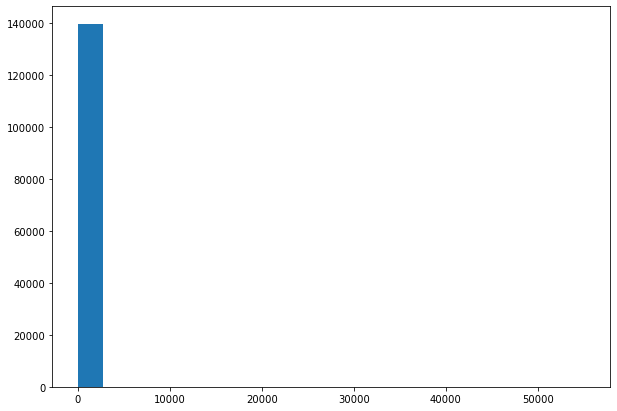



********************************************************************************************************************************************************************************************************
111 :  V207 

Data type:  float32
- No. of null values:  4602
- No. of non-null values:  139631
- No. of unique values:  3247
- min:  0.0
- max:  55125.0


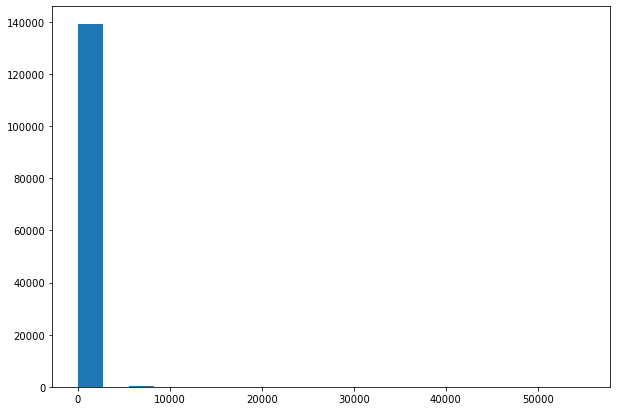



********************************************************************************************************************************************************************************************************
112 :  V208 

Data type:  float32
- No. of null values:  4414
- No. of non-null values:  139819
- No. of unique values:  2553
- min:  0.0
- max:  3300.0


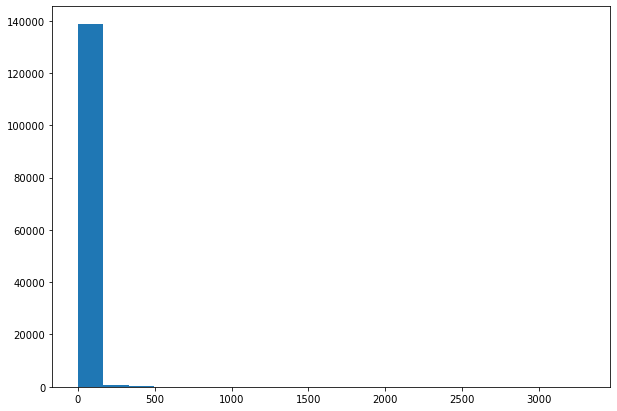



********************************************************************************************************************************************************************************************************
113 :  V209 

Data type:  float32
- No. of null values:  4414
- No. of non-null values:  139819
- No. of unique values:  3452
- min:  0.0
- max:  8050.0


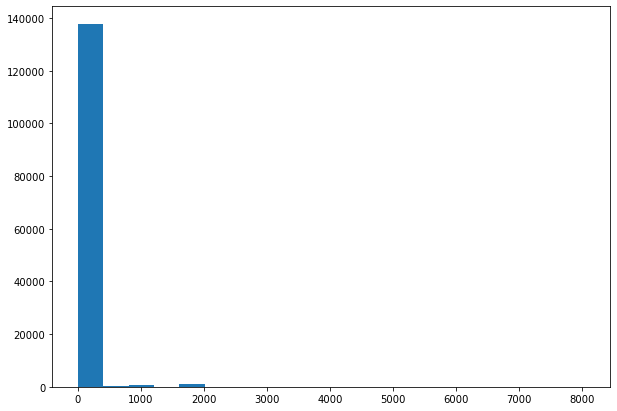



********************************************************************************************************************************************************************************************************
114 :  V210 

Data type:  float32
- No. of null values:  4414
- No. of non-null values:  139819
- No. of unique values:  2837
- min:  0.0
- max:  3300.0


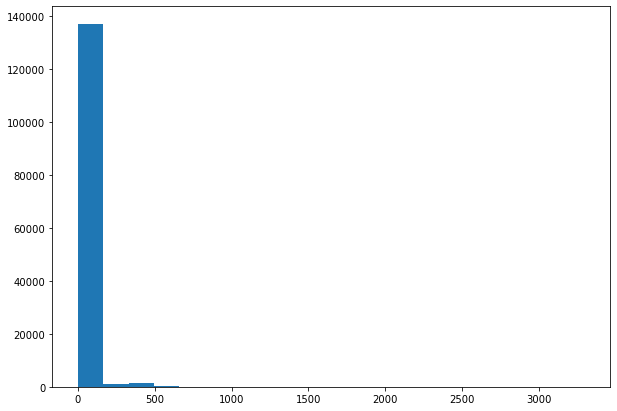



********************************************************************************************************************************************************************************************************
115 :  V211 

Data type:  float32
- No. of null values:  4602
- No. of non-null values:  139631
- No. of unique values:  7625
- min:  0.0
- max:  92888.0


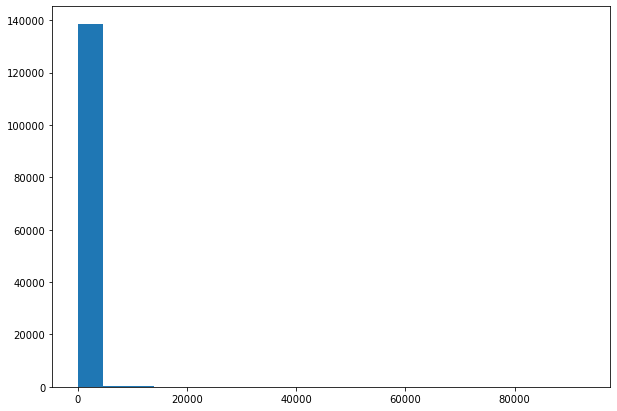



********************************************************************************************************************************************************************************************************
116 :  V212 

Data type:  float32
- No. of null values:  4602
- No. of non-null values:  139631
- No. of unique values:  8869
- min:  0.0
- max:  129006.0


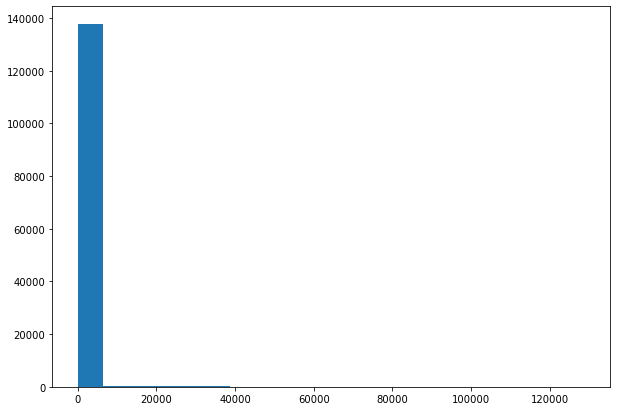



********************************************************************************************************************************************************************************************************
117 :  V213 

Data type:  float32
- No. of null values:  4602
- No. of non-null values:  139631
- No. of unique values:  8318
- min:  0.0
- max:  97628.0


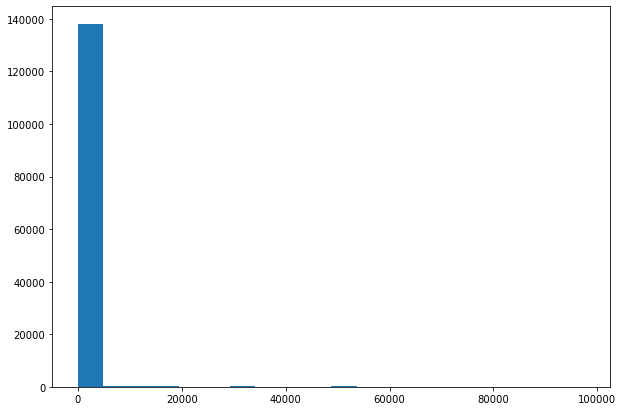



********************************************************************************************************************************************************************************************************
118 :  V214 

Data type:  float32
- No. of null values:  4602
- No. of non-null values:  139631
- No. of unique values:  2283
- min:  0.0
- max:  104060.0


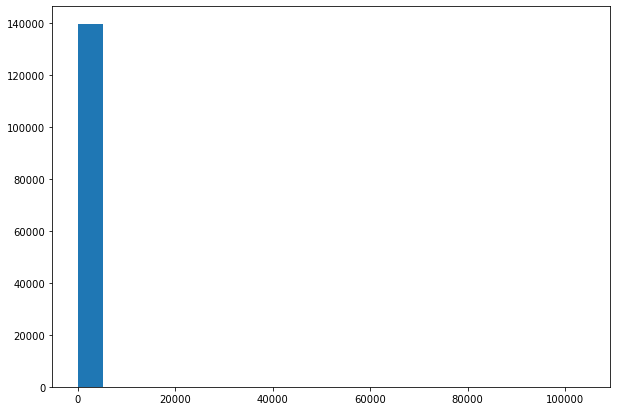



********************************************************************************************************************************************************************************************************
119 :  V215 

Data type:  float32
- No. of null values:  4602
- No. of non-null values:  139631
- No. of unique values:  2748
- min:  0.0
- max:  104060.0


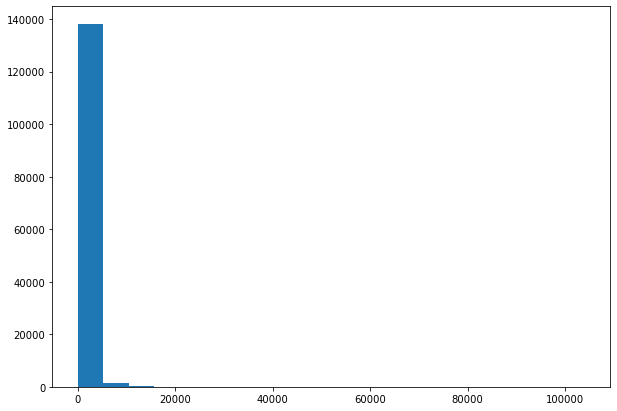



********************************************************************************************************************************************************************************************************
120 :  V216 

Data type:  float32
- No. of null values:  4602
- No. of non-null values:  139631
- No. of unique values:  2533
- min:  0.0
- max:  104060.0


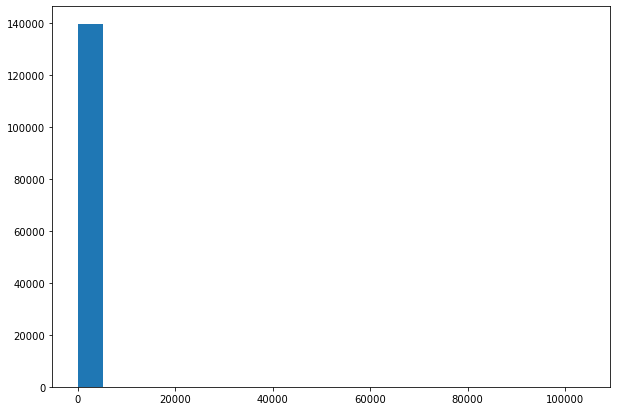



********************************************************************************************************************************************************************************************************
121 :  V217 

Data type:  float32
- No. of null values:  13964
- No. of non-null values:  130269
- No. of unique values:  305
- min:  0.0
- max:  303.0


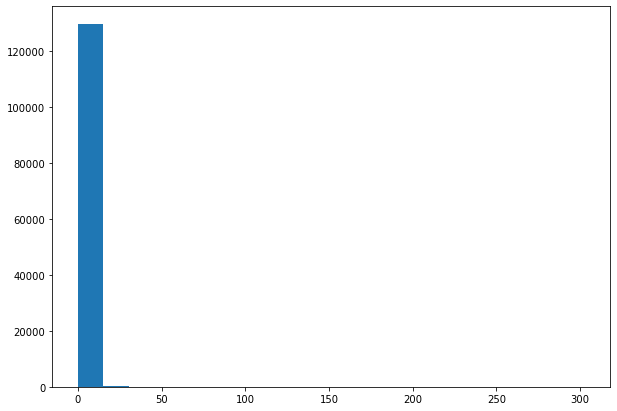



********************************************************************************************************************************************************************************************************
122 :  V218 

Data type:  float32
- No. of null values:  13964
- No. of non-null values:  130269
- No. of unique values:  402
- min:  0.0
- max:  400.0


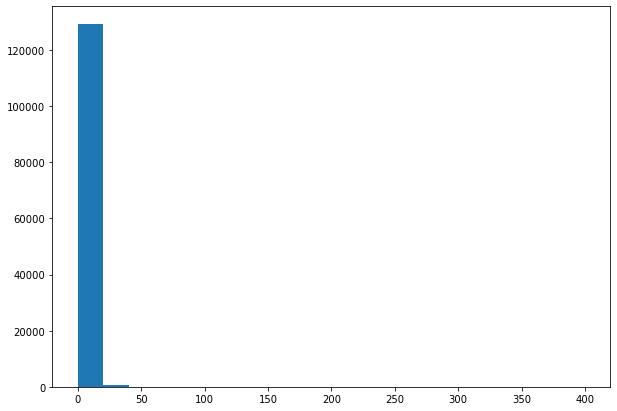



********************************************************************************************************************************************************************************************************
123 :  V219 

Data type:  float32
- No. of null values:  13964
- No. of non-null values:  130269
- No. of unique values:  380
- min:  0.0
- max:  378.0


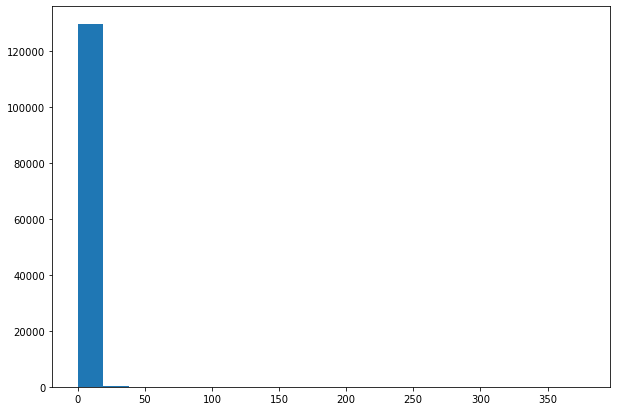



********************************************************************************************************************************************************************************************************
124 :  V220 

Data type:  float32
- No. of null values:  3127
- No. of non-null values:  141106
- No. of unique values:  27
0.0     132739
1.0       3793
2.0       1562
3.0        980
4.0        615
5.0        380
6.0        290
7.0        173
8.0        124
9.0         87
10.0        85
11.0        37
12.0        38
13.0        46
14.0        23
15.0        27
16.0        24
17.0        11
18.0        33
19.0         6
20.0        12
21.0        10
22.0         3
23.0         5
24.0         2
25.0         1
Name: V220, dtype: int64


********************************************************************************************************************************************************************************************************
125 :  V221 

Data type:  float32
- No. of null values:

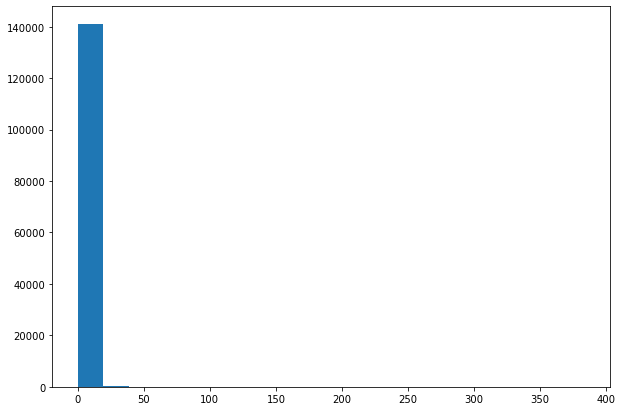



********************************************************************************************************************************************************************************************************
126 :  V222 

Data type:  float32
- No. of null values:  3127
- No. of non-null values:  141106
- No. of unique values:  77
- min:  0.0
- max:  384.0


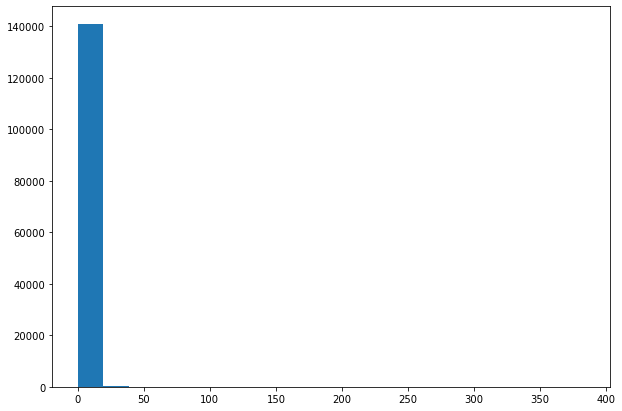



********************************************************************************************************************************************************************************************************
127 :  V223 

Data type:  float32
- No. of null values:  13964
- No. of non-null values:  130269
- No. of unique values:  18
0.0     120363
1.0       8492
2.0       1113
3.0        178
4.0         38
5.0         20
6.0          9
7.0         16
8.0          8
9.0          5
10.0         4
11.0         4
12.0         5
13.0         3
14.0         8
15.0         2
16.0         1
Name: V223, dtype: int64


********************************************************************************************************************************************************************************************************
128 :  V224 

Data type:  float32
- No. of null values:  13964
- No. of non-null values:  130269
- No. of unique values:  80
- min:  0.0
- max:  144.0


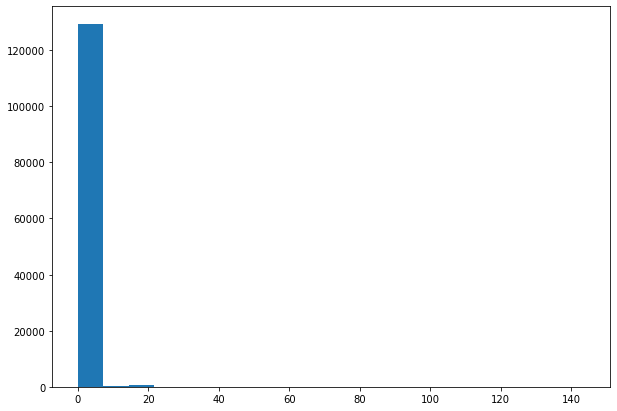



********************************************************************************************************************************************************************************************************
129 :  V225 

Data type:  float32
- No. of null values:  13964
- No. of non-null values:  130269
- No. of unique values:  36
0.0     116177
1.0      10793
2.0       1868
3.0        525
4.0        179
5.0         98
6.0         70
7.0        376
8.0         39
9.0         17
10.0        33
11.0         7
12.0         3
13.0         1
14.0         1
15.0         2
16.0         1
17.0         2
19.0         1
32.0         2
37.0         1
38.0         3
39.0        11
40.0         4
41.0         2
42.0         1
43.0         3
44.0         3
45.0         8
46.0         5
47.0         4
48.0        10
49.0         6
50.0         5
51.0         8
Name: V225, dtype: int64


************************************************************************************************************************

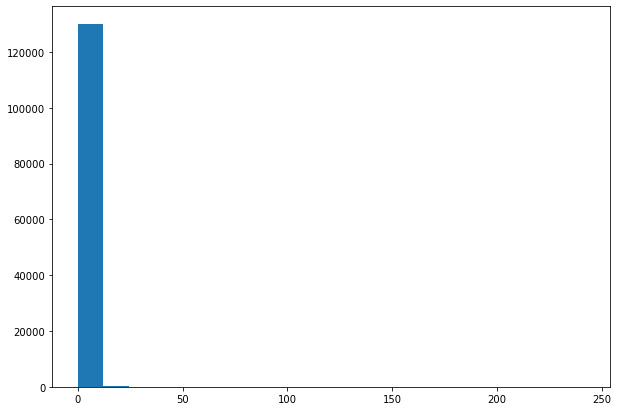



********************************************************************************************************************************************************************************************************
131 :  V227 

Data type:  float32
- No. of null values:  3127
- No. of non-null values:  141106
- No. of unique values:  51
- min:  0.0
- max:  360.0


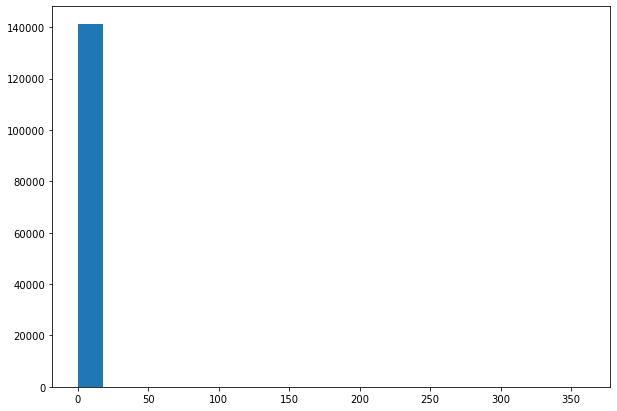



********************************************************************************************************************************************************************************************************
132 :  V228 

Data type:  float32
- No. of null values:  13964
- No. of non-null values:  130269
- No. of unique values:  56
- min:  0.0
- max:  54.0


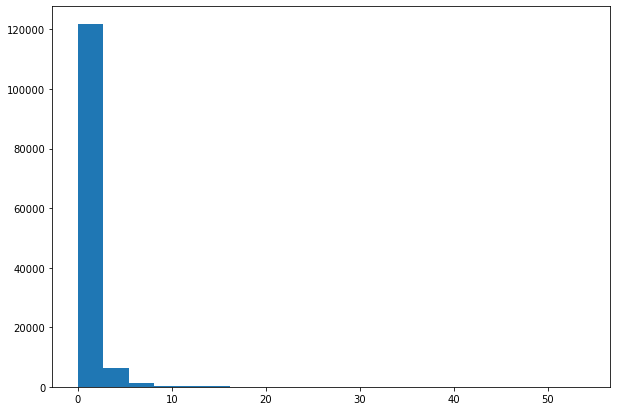



********************************************************************************************************************************************************************************************************
133 :  V229 

Data type:  float32
- No. of null values:  13964
- No. of non-null values:  130269
- No. of unique values:  92
- min:  0.0
- max:  176.0


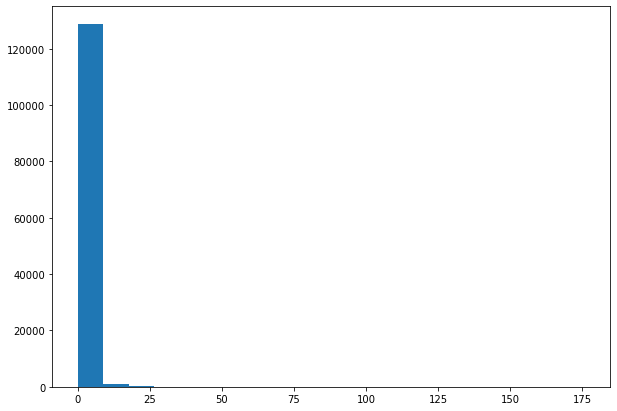



********************************************************************************************************************************************************************************************************
134 :  V230 

Data type:  float32
- No. of null values:  13964
- No. of non-null values:  130269
- No. of unique values:  67
- min:  0.0
- max:  65.0


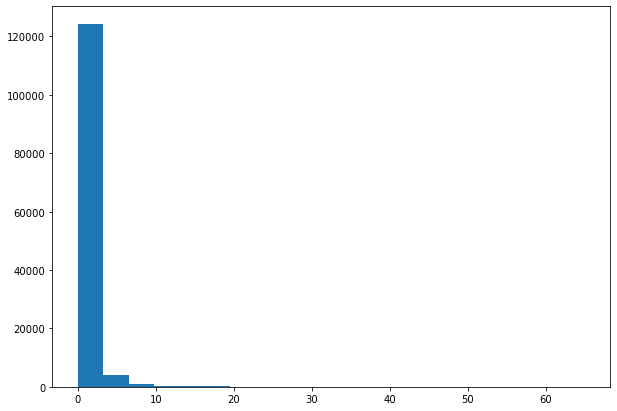



********************************************************************************************************************************************************************************************************
135 :  V231 

Data type:  float32
- No. of null values:  13964
- No. of non-null values:  130269
- No. of unique values:  295
- min:  0.0
- max:  293.0


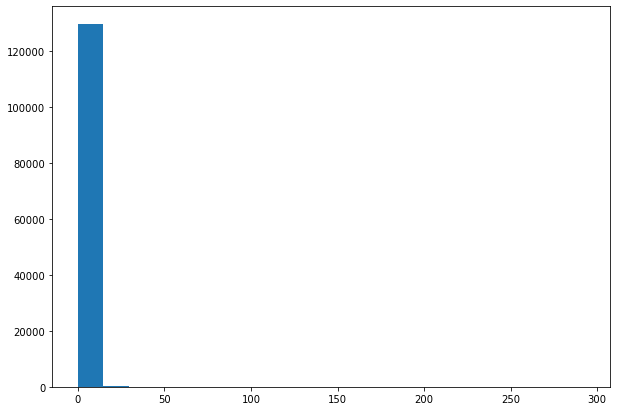



********************************************************************************************************************************************************************************************************
136 :  V232 

Data type:  float32
- No. of null values:  13964
- No. of non-null values:  130269
- No. of unique values:  339
- min:  0.0
- max:  337.0


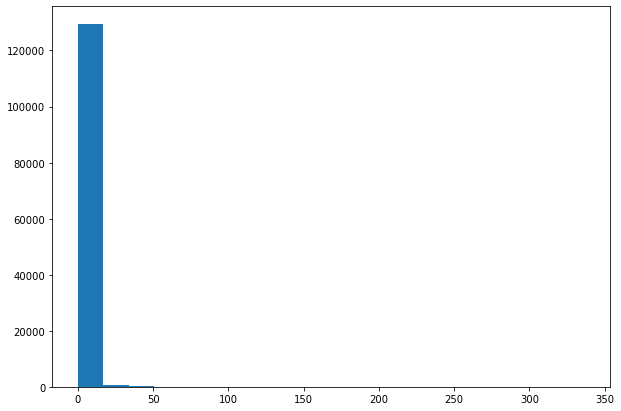



********************************************************************************************************************************************************************************************************
137 :  V233 

Data type:  float32
- No. of null values:  13964
- No. of non-null values:  130269
- No. of unique values:  334
- min:  0.0
- max:  332.0


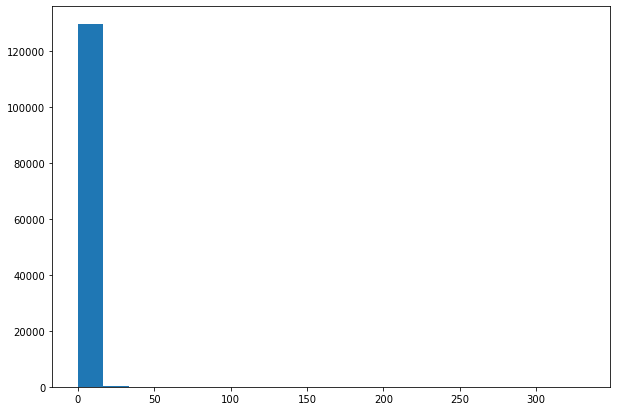



********************************************************************************************************************************************************************************************************
138 :  V234 

Data type:  float32
- No. of null values:  3127
- No. of non-null values:  141106
- No. of unique values:  123
- min:  0.0
- max:  121.0


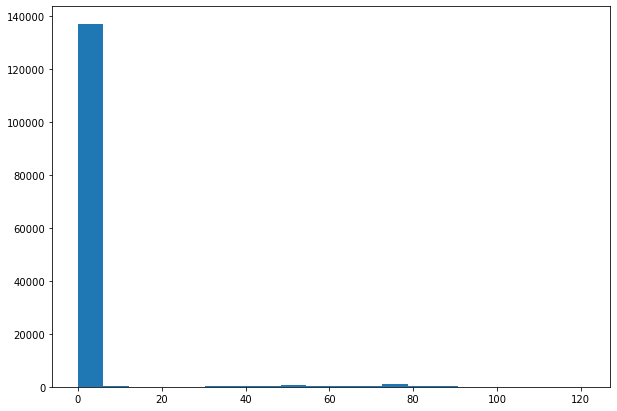



********************************************************************************************************************************************************************************************************
139 :  V235 

Data type:  float32
- No. of null values:  13964
- No. of non-null values:  130269
- No. of unique values:  25
0.0     117574
1.0       8384
2.0       2429
3.0        863
4.0        361
5.0        128
6.0         69
7.0         36
8.0         31
9.0         18
10.0        17
11.0        97
12.0        61
13.0         5
14.0        13
15.0       175
16.0         1
17.0         1
18.0         1
19.0         1
20.0         1
21.0         1
22.0         1
23.0         1
Name: V235, dtype: int64


********************************************************************************************************************************************************************************************************
140 :  V236 

Data type:  float32
- No. of null values:  13964
- No. of non-null val

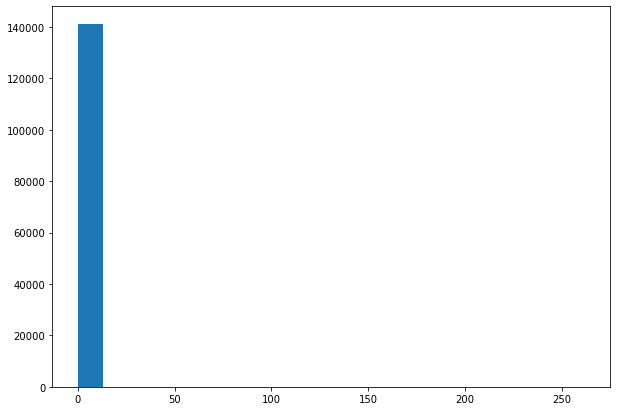



********************************************************************************************************************************************************************************************************
150 :  V246 

Data type:  float32
- No. of null values:  13964
- No. of non-null values:  130269
- No. of unique values:  47
0.0          8
1.0     119219
2.0       7257
3.0       1561
4.0        691
5.0        416
6.0        299
7.0        210
8.0        123
9.0         95
10.0        73
11.0        56
12.0        48
13.0        33
14.0        29
15.0        22
16.0        30
17.0        23
18.0        15
19.0        11
20.0        13
21.0         4
22.0         4
23.0         2
24.0         2
25.0         1
26.0         1
27.0         1
28.0         1
29.0         1
30.0         1
31.0         3
32.0         1
33.0         1
34.0         1
35.0         1
36.0         1
37.0         1
38.0         1
39.0         1
40.0         2
41.0         2
42.0         1
43.0         1
44.0        

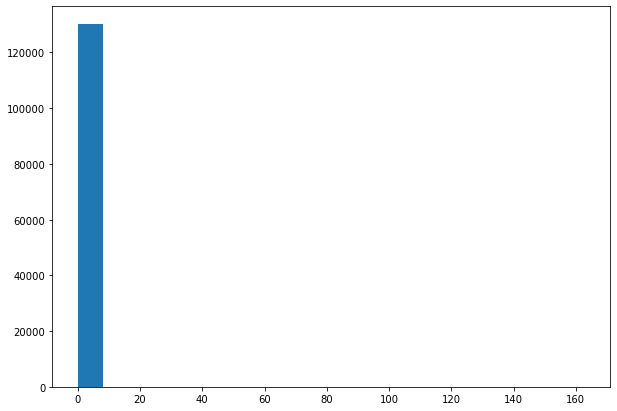



********************************************************************************************************************************************************************************************************
158 :  V254 

Data type:  float32
- No. of null values:  13964
- No. of non-null values:  130269
- No. of unique values:  46
0.0          6
1.0     126842
2.0       2446
3.0        450
4.0        210
5.0         68
6.0         46
7.0         30
8.0         21
9.0         24
10.0        11
11.0        10
12.0         5
13.0         3
14.0         3
15.0         3
16.0         2
17.0         3
18.0         4
19.0         1
20.0         1
21.0         1
22.0         1
23.0         1
24.0         1
26.0         1
27.0         1
43.0         1
44.0         1
45.0         3
46.0        10
47.0         3
48.0         1
49.0         2
50.0         1
51.0         1
52.0         3
53.0         3
54.0         3
55.0         5
56.0         4
57.0        10
58.0         7
59.0         8
60.0        

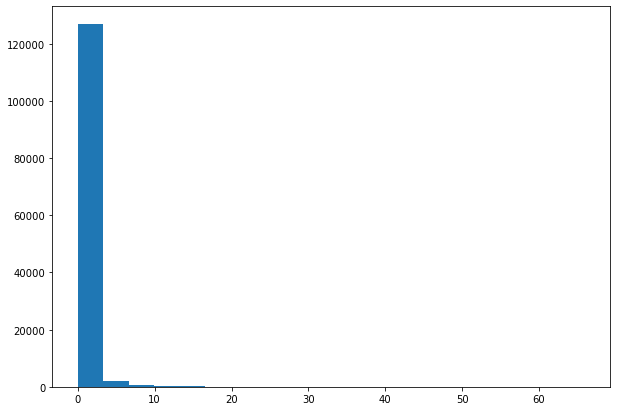



********************************************************************************************************************************************************************************************************
163 :  V259 

Data type:  float32
- No. of null values:  3127
- No. of non-null values:  141106
- No. of unique values:  69
- min:  0.0
- max:  285.0


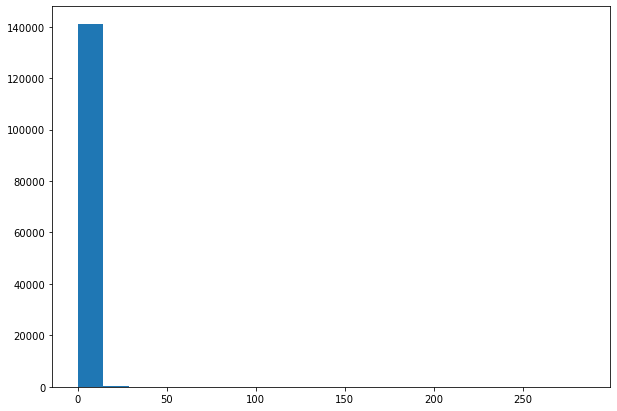



********************************************************************************************************************************************************************************************************
164 :  V260 

Data type:  float32
- No. of null values:  13964
- No. of non-null values:  130269
- No. of unique values:  10
0.0      9901
1.0    116234
2.0      3251
3.0       607
4.0       199
5.0        58
6.0        15
7.0         3
8.0         1
Name: V260, dtype: int64


********************************************************************************************************************************************************************************************************
165 :  V261 

Data type:  float32
- No. of null values:  13964
- No. of non-null values:  130269
- No. of unique values:  42
0.0       9264
1.0     110532
2.0       6981
3.0       1609
4.0        655
5.0        267
6.0        167
7.0        224
8.0        173
9.0        132
10.0        52
11.0        16
12.0        1

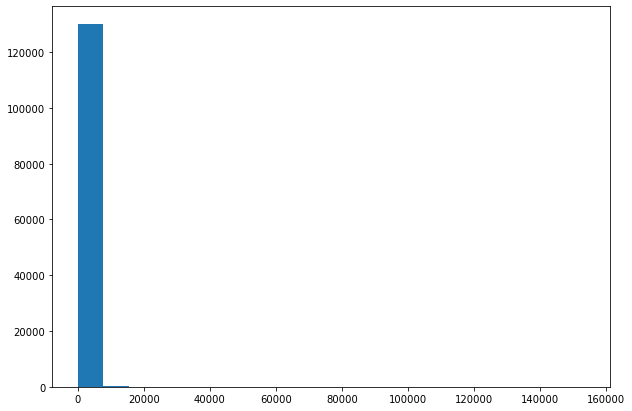



********************************************************************************************************************************************************************************************************
168 :  V264 

Data type:  float32
- No. of null values:  13964
- No. of non-null values:  130269
- No. of unique values:  13354
- min:  0.0
- max:  153600.0


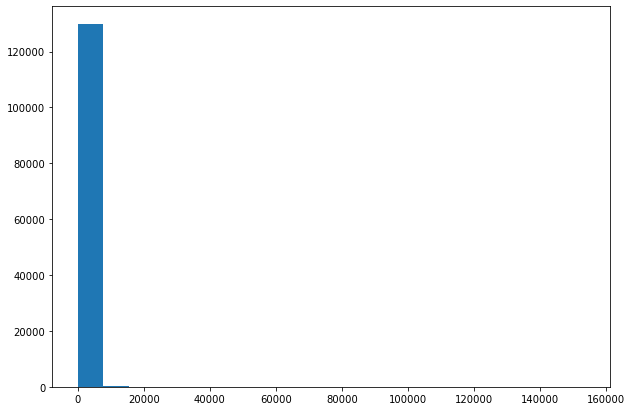



********************************************************************************************************************************************************************************************************
169 :  V265 

Data type:  float32
- No. of null values:  13964
- No. of non-null values:  130269
- No. of unique values:  11752
- min:  0.0
- max:  153600.0


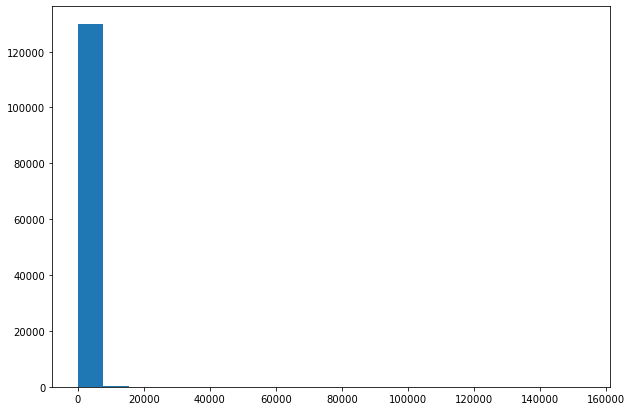



********************************************************************************************************************************************************************************************************
170 :  V266 

Data type:  float32
- No. of null values:  13964
- No. of non-null values:  130269
- No. of unique values:  2179
- min:  0.0
- max:  55125.0


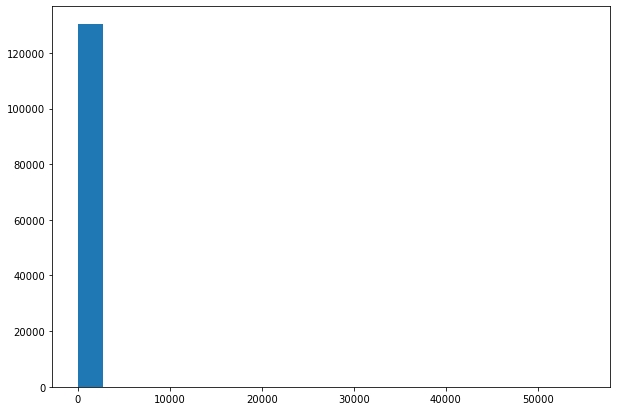



********************************************************************************************************************************************************************************************************
171 :  V267 

Data type:  float32
- No. of null values:  13964
- No. of non-null values:  130269
- No. of unique values:  3616
- min:  0.0
- max:  55125.0


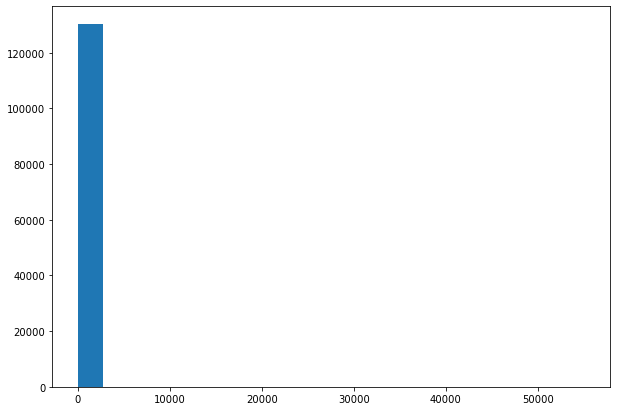



********************************************************************************************************************************************************************************************************
172 :  V268 

Data type:  float32
- No. of null values:  13964
- No. of non-null values:  130269
- No. of unique values:  2755
- min:  0.0
- max:  55125.0


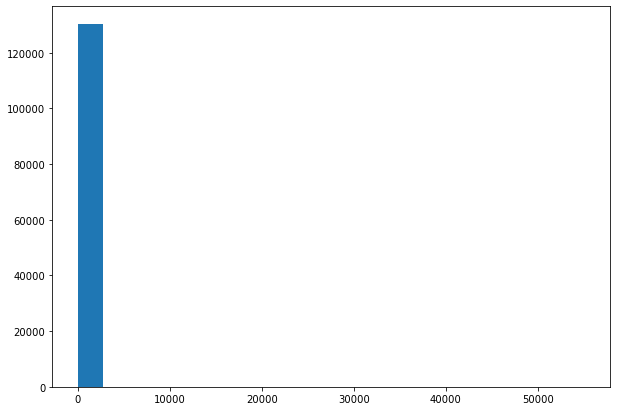



********************************************************************************************************************************************************************************************************
173 :  V269 

Data type:  float32
- No. of null values:  13964
- No. of non-null values:  130269
- No. of unique values:  152
- min:  0.0
- max:  55125.0


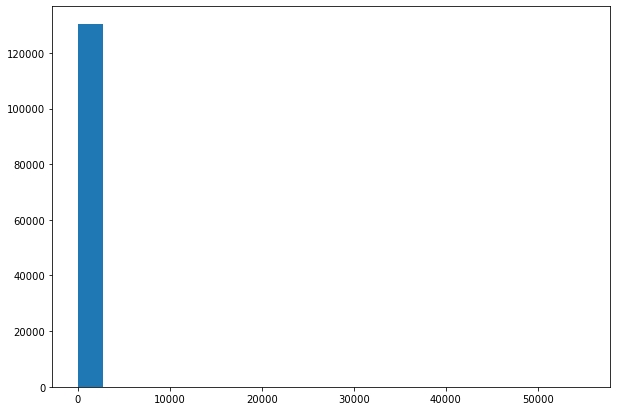



********************************************************************************************************************************************************************************************************
174 :  V270 

Data type:  float32
- No. of null values:  3127
- No. of non-null values:  141106
- No. of unique values:  2341
- min:  0.0
- max:  4000.0


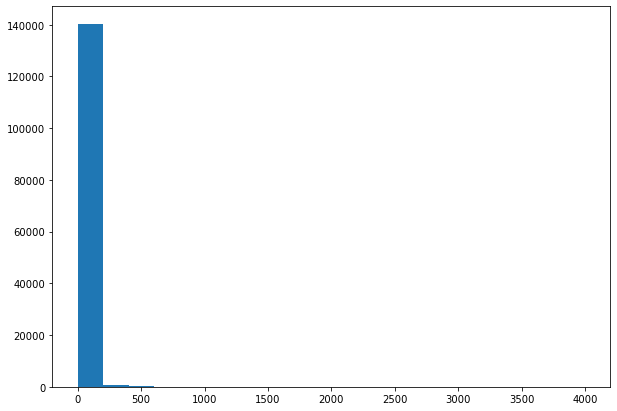



********************************************************************************************************************************************************************************************************
175 :  V271 

Data type:  float32
- No. of null values:  3127
- No. of non-null values:  141106
- No. of unique values:  2788
- min:  0.0
- max:  4000.0


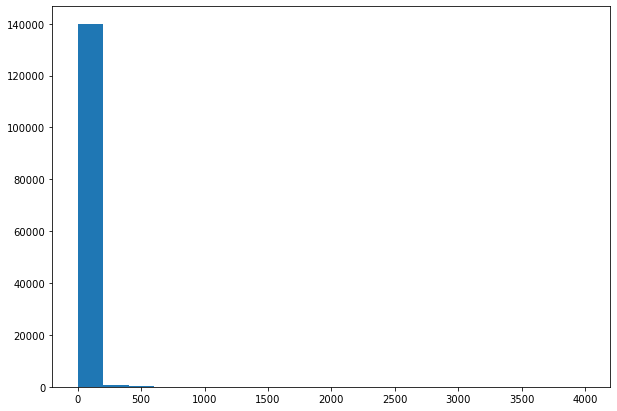



********************************************************************************************************************************************************************************************************
176 :  V272 

Data type:  float32
- No. of null values:  3127
- No. of non-null values:  141106
- No. of unique values:  2508
- min:  0.0
- max:  4000.0


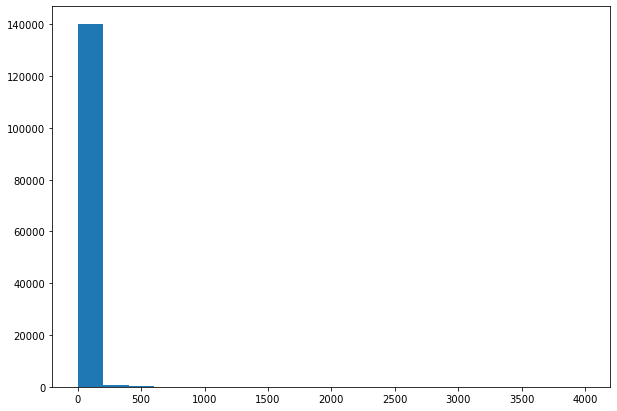



********************************************************************************************************************************************************************************************************
177 :  V273 

Data type:  float32
- No. of null values:  13964
- No. of non-null values:  130269
- No. of unique values:  7178
- min:  0.0
- max:  51200.0


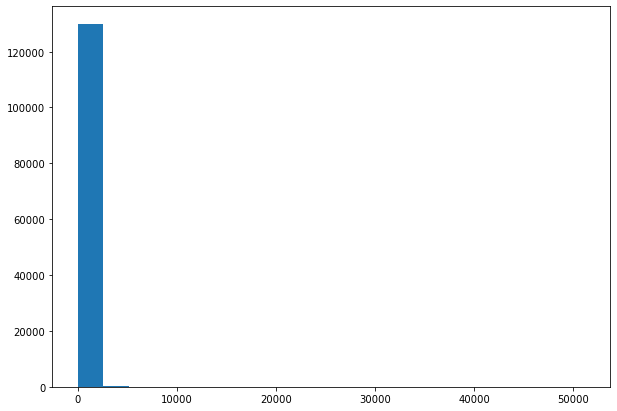



********************************************************************************************************************************************************************************************************
178 :  V274 

Data type:  float32
- No. of null values:  13964
- No. of non-null values:  130269
- No. of unique values:  8316
- min:  0.0
- max:  66000.0


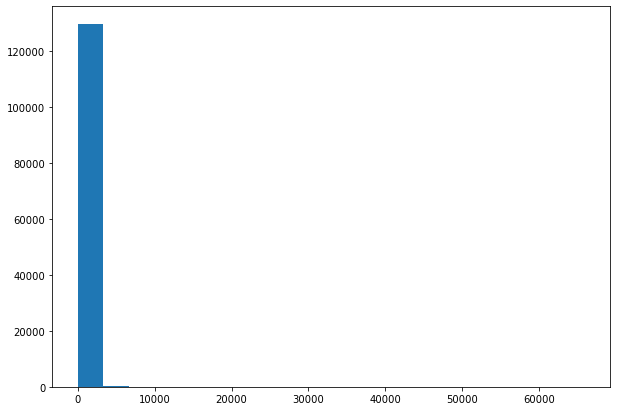



********************************************************************************************************************************************************************************************************
179 :  V275 

Data type:  float32
- No. of null values:  13964
- No. of non-null values:  130269
- No. of unique values:  7777
- min:  0.0
- max:  51200.0


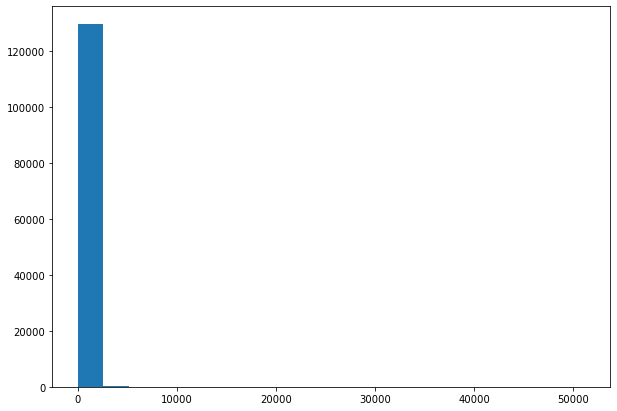



********************************************************************************************************************************************************************************************************
180 :  V276 

Data type:  float32
- No. of null values:  13964
- No. of non-null values:  130269
- No. of unique values:  2263
- min:  0.0
- max:  104060.0


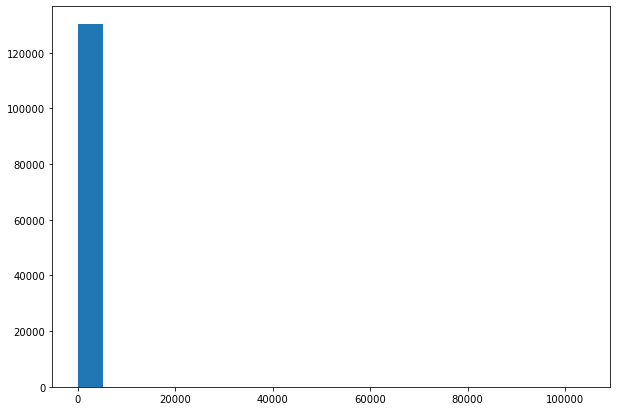



********************************************************************************************************************************************************************************************************
181 :  V277 

Data type:  float32
- No. of null values:  13964
- No. of non-null values:  130269
- No. of unique values:  2540
- min:  0.0
- max:  104060.0


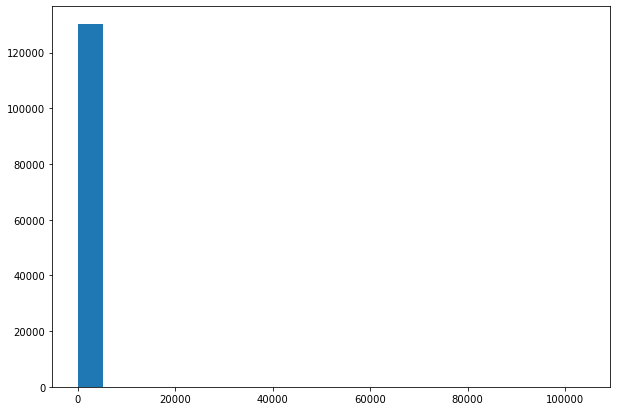



********************************************************************************************************************************************************************************************************
182 :  V278 

Data type:  float32
- No. of null values:  13964
- No. of non-null values:  130269
- No. of unique values:  2397
- min:  0.0
- max:  104060.0


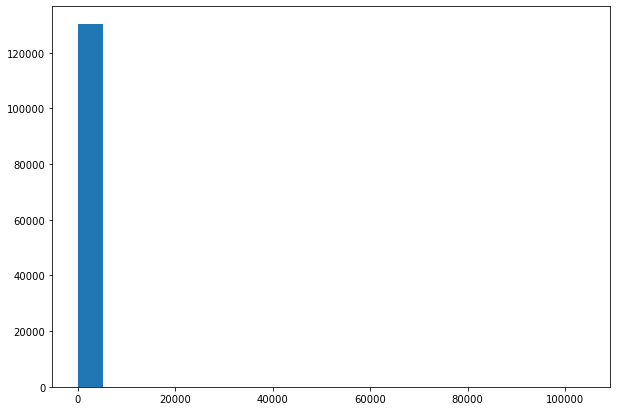



********************************************************************************************************************************************************************************************************
183 :  V279 

Data type:  float32
- No. of null values:  2
- No. of non-null values:  144231
- No. of unique values:  881
- min:  0.0
- max:  880.0


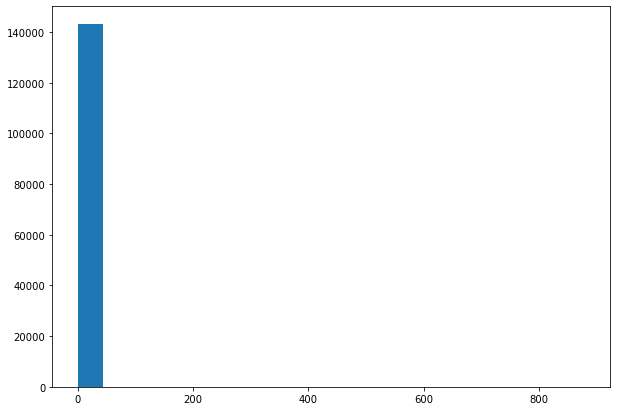



********************************************************************************************************************************************************************************************************
184 :  V280 

Data type:  float32
- No. of null values:  2
- No. of non-null values:  144231
- No. of unique values:  975
- min:  0.0
- max:  975.0


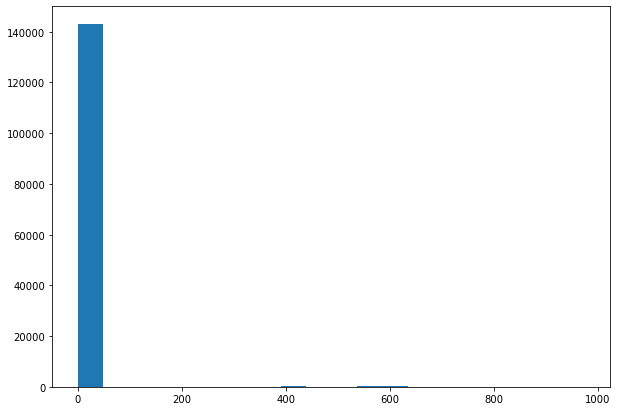



********************************************************************************************************************************************************************************************************
185 :  V281 

Data type:  float32
- No. of null values:  218
- No. of non-null values:  144015
- No. of unique values:  24
0.0     136226
1.0       4037
2.0       1562
3.0        864
4.0        527
5.0        303
6.0        164
7.0        108
8.0         72
9.0         44
10.0        54
11.0        13
12.0        14
13.0        11
14.0         4
15.0         4
16.0         2
17.0         1
18.0         1
19.0         1
20.0         1
21.0         1
22.0         1
Name: V281, dtype: int64


********************************************************************************************************************************************************************************************************
186 :  V282 

Data type:  float32
- No. of null values:  218
- No. of non-null values:  144015
- No. 

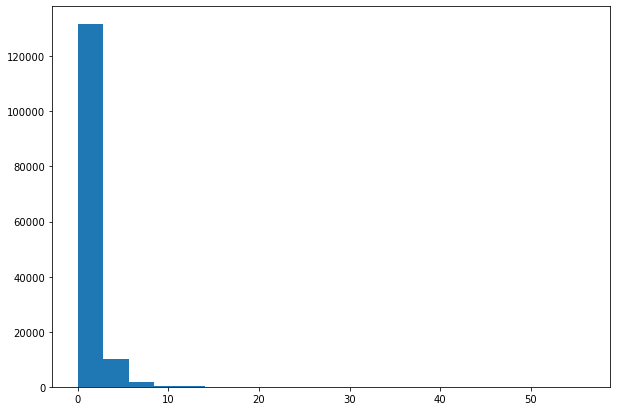



********************************************************************************************************************************************************************************************************
188 :  V284 

Data type:  float32
- No. of null values:  2
- No. of non-null values:  144231
- No. of unique values:  14
0.0     134098
1.0       8677
2.0       1204
3.0        198
4.0         30
5.0         12
6.0          5
7.0          2
8.0          1
9.0          1
10.0         1
11.0         1
12.0         1
Name: V284, dtype: int64


********************************************************************************************************************************************************************************************************
189 :  V285 

Data type:  float32
- No. of null values:  2
- No. of non-null values:  144231
- No. of unique values:  46
0.0     121807
1.0      13923
2.0       2988
3.0       1325
4.0        667
5.0        383
6.0        251
7.0        200
8.0        1

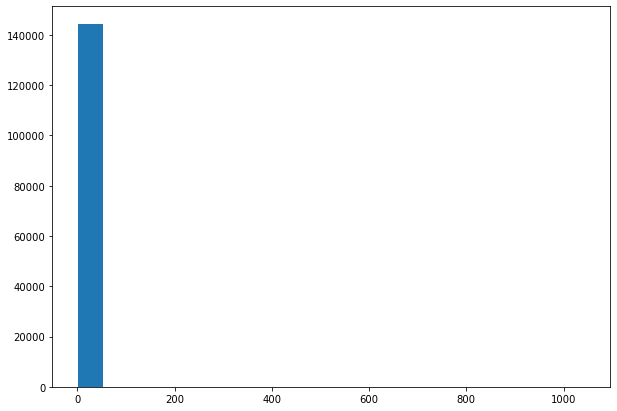



********************************************************************************************************************************************************************************************************
196 :  V292 

Data type:  float32
- No. of null values:  2
- No. of non-null values:  144231
- No. of unique values:  74
- min:  1.0
- max:  199.0


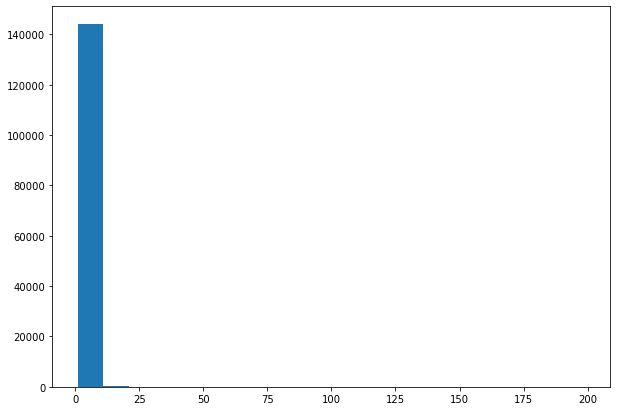



********************************************************************************************************************************************************************************************************
197 :  V293 

Data type:  float32
- No. of null values:  2
- No. of non-null values:  144231
- No. of unique values:  870
- min:  0.0
- max:  869.0


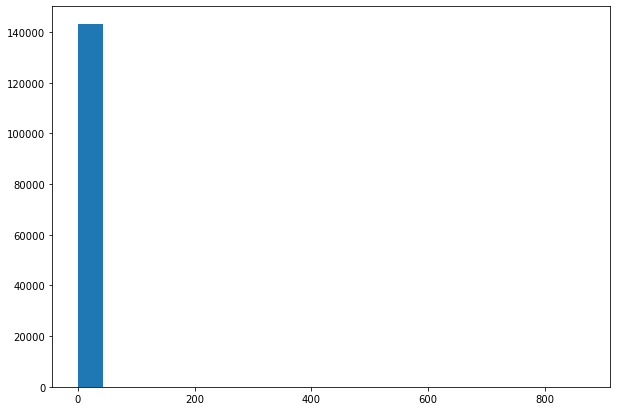



********************************************************************************************************************************************************************************************************
198 :  V294 

Data type:  float32
- No. of null values:  2
- No. of non-null values:  144231
- No. of unique values:  1286
- min:  0.0
- max:  1286.0


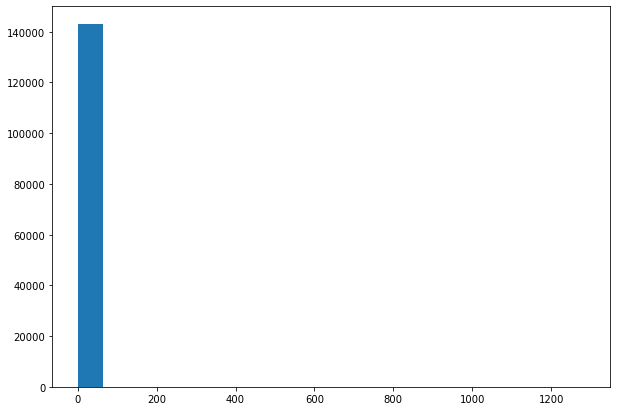



********************************************************************************************************************************************************************************************************
199 :  V295 

Data type:  float32
- No. of null values:  2
- No. of non-null values:  144231
- No. of unique values:  928
- min:  0.0
- max:  928.0


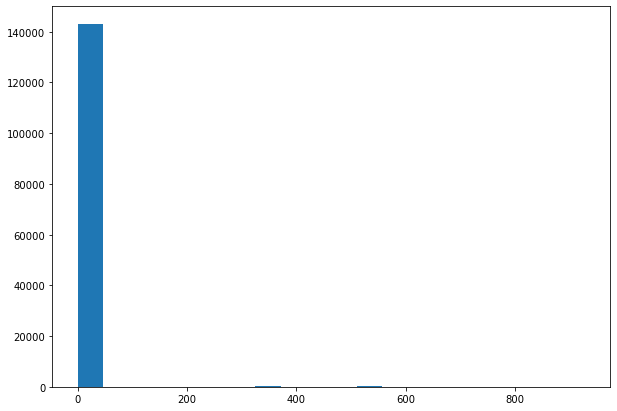



********************************************************************************************************************************************************************************************************
200 :  V296 

Data type:  float32
- No. of null values:  218
- No. of non-null values:  144015
- No. of unique values:  95
- min:  0.0
- max:  93.0


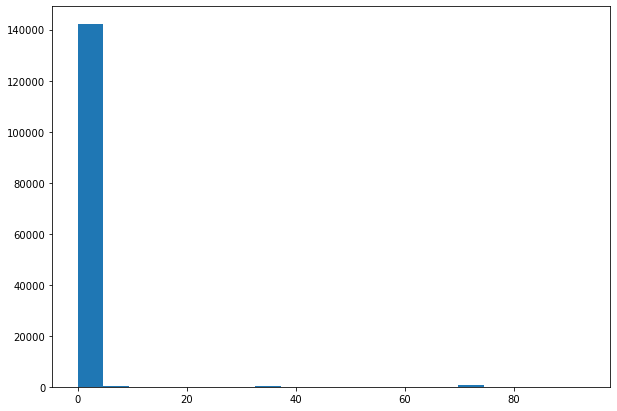



********************************************************************************************************************************************************************************************************
201 :  V297 

Data type:  float32
- No. of null values:  2
- No. of non-null values:  144231
- No. of unique values:  13
0.0     134331
1.0       6131
2.0       1512
3.0        519
4.0        203
5.0        101
6.0         56
7.0         35
8.0         25
9.0         15
10.0        10
11.0      1293
Name: V297, dtype: int64


********************************************************************************************************************************************************************************************************
202 :  V298 

Data type:  float32
- No. of null values:  2
- No. of non-null values:  144231
- No. of unique values:  95
- min:  0.0
- max:  93.0


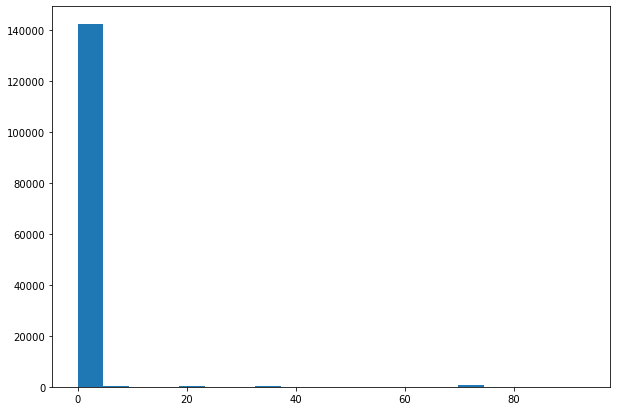



********************************************************************************************************************************************************************************************************
203 :  V299 

Data type:  float32
- No. of null values:  2
- No. of non-null values:  144231
- No. of unique values:  51
- min:  0.0
- max:  49.0


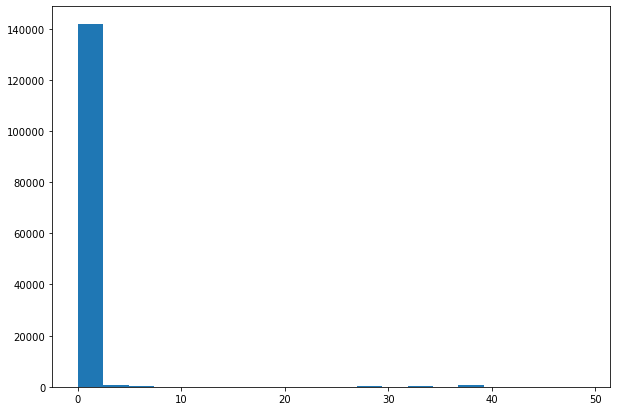



********************************************************************************************************************************************************************************************************
204 :  V300 

Data type:  float32
- No. of null values:  218
- No. of non-null values:  144015
- No. of unique values:  13
0.0     135873
1.0       5838
2.0       1466
3.0        496
4.0        170
5.0         78
6.0         33
7.0         16
8.0         10
9.0          4
10.0         3
11.0        28
Name: V300, dtype: int64


********************************************************************************************************************************************************************************************************
205 :  V301 

Data type:  float32
- No. of null values:  218
- No. of non-null values:  144015
- No. of unique values:  13
0.0     135665
1.0       5928
2.0       1525
3.0        526
4.0        179
5.0         86
6.0         41
7.0         17
8.0         11
9.0     

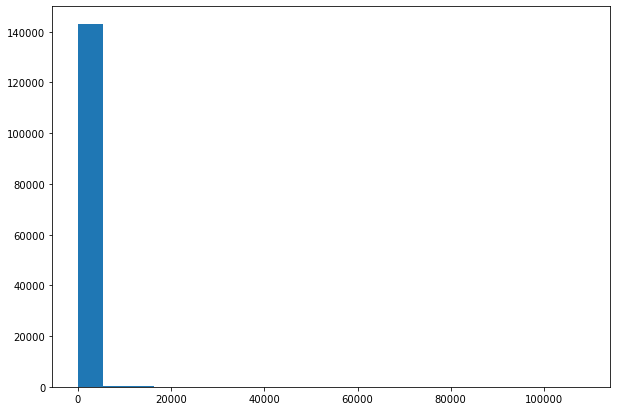



********************************************************************************************************************************************************************************************************
211 :  V307 

Data type:  float32
- No. of null values:  2
- No. of non-null values:  144231
- No. of unique values:  13286
- min:  0.0
- max:  145765.0


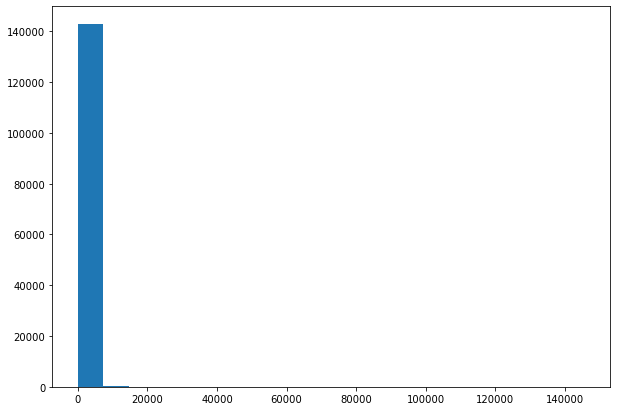



********************************************************************************************************************************************************************************************************
212 :  V308 

Data type:  float32
- No. of null values:  2
- No. of non-null values:  144231
- No. of unique values:  10814
- min:  0.0
- max:  108800.0


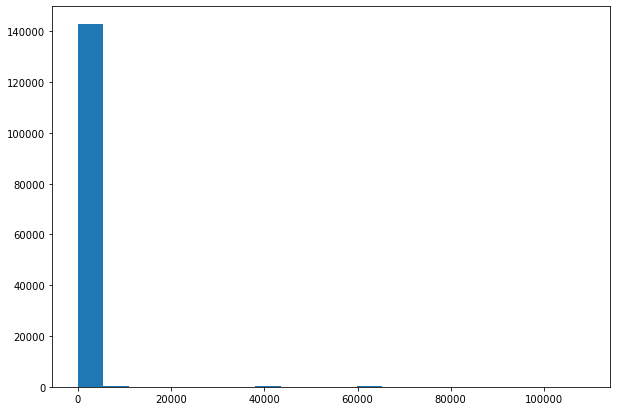



********************************************************************************************************************************************************************************************************
213 :  V309 

Data type:  float32
- No. of null values:  2
- No. of non-null values:  144231
- No. of unique values:  2370
- min:  0.0
- max:  55125.0


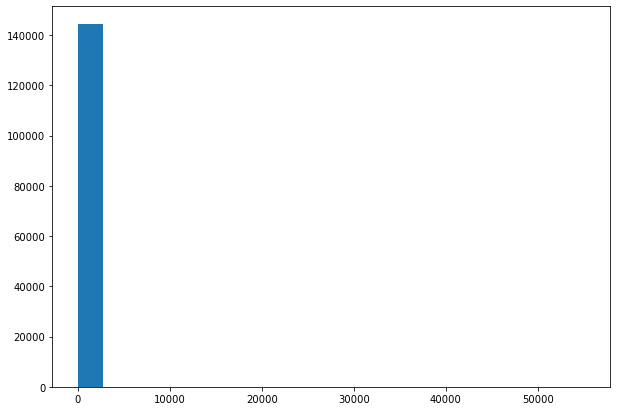



********************************************************************************************************************************************************************************************************
214 :  V310 

Data type:  float32
- No. of null values:  2
- No. of non-null values:  144231
- No. of unique values:  5215
- min:  0.0
- max:  55125.0


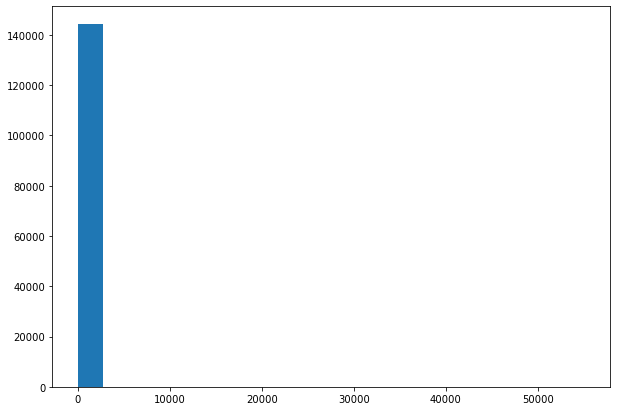



********************************************************************************************************************************************************************************************************
215 :  V311 

Data type:  float32
- No. of null values:  2
- No. of non-null values:  144231
- No. of unique values:  1922
- min:  0.0
- max:  55125.0


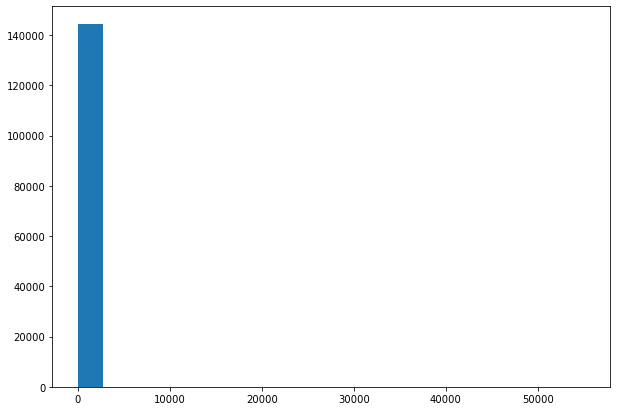



********************************************************************************************************************************************************************************************************
216 :  V312 

Data type:  float32
- No. of null values:  2
- No. of non-null values:  144231
- No. of unique values:  3512
- min:  0.0
- max:  55125.0


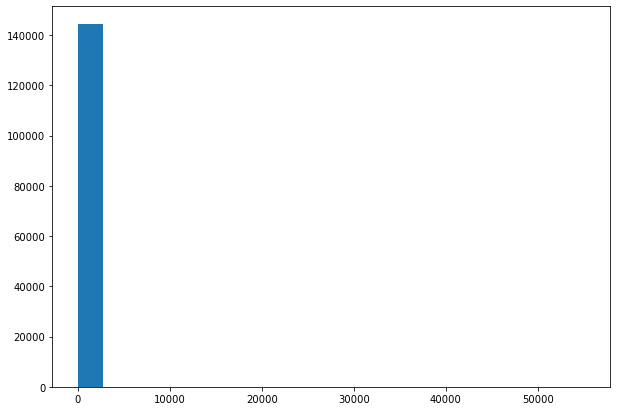



********************************************************************************************************************************************************************************************************
217 :  V313 

Data type:  float32
- No. of null values:  218
- No. of non-null values:  144015
- No. of unique values:  2837
- min:  0.0
- max:  3300.0


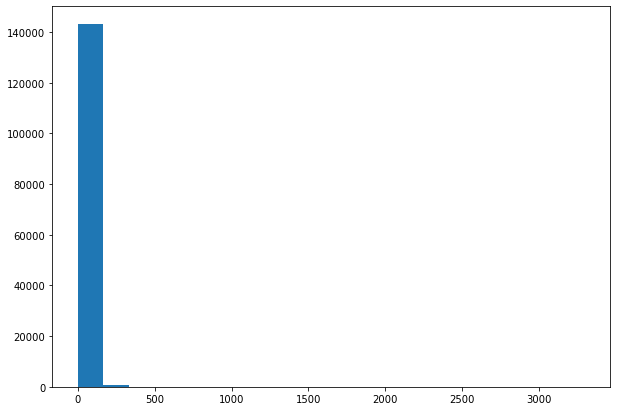



********************************************************************************************************************************************************************************************************
218 :  V314 

Data type:  float32
- No. of null values:  218
- No. of non-null values:  144015
- No. of unique values:  3822
- min:  0.0
- max:  3300.0


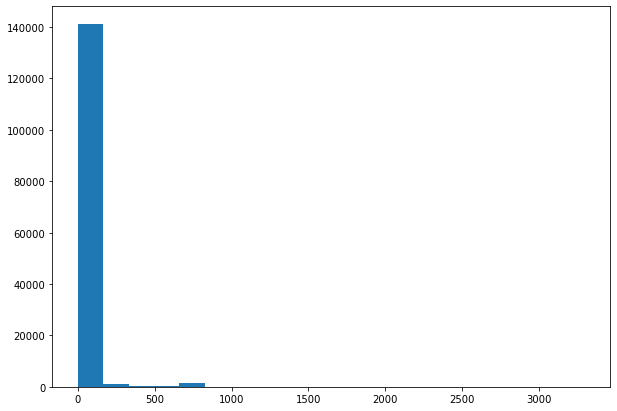



********************************************************************************************************************************************************************************************************
219 :  V315 

Data type:  float32
- No. of null values:  218
- No. of non-null values:  144015
- No. of unique values:  3149
- min:  0.0
- max:  3300.0


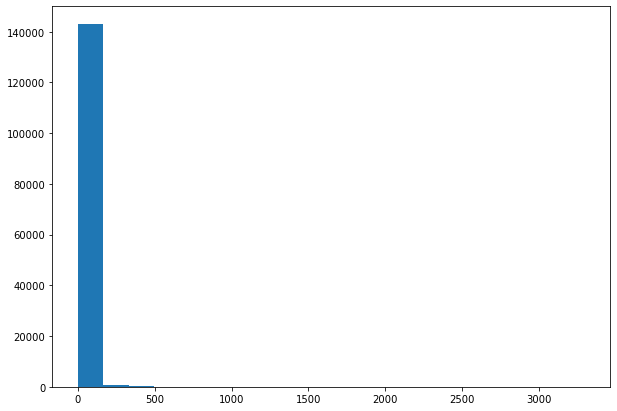



********************************************************************************************************************************************************************************************************
220 :  V316 

Data type:  float32
- No. of null values:  2
- No. of non-null values:  144231
- No. of unique values:  5968
- min:  0.0
- max:  93736.0


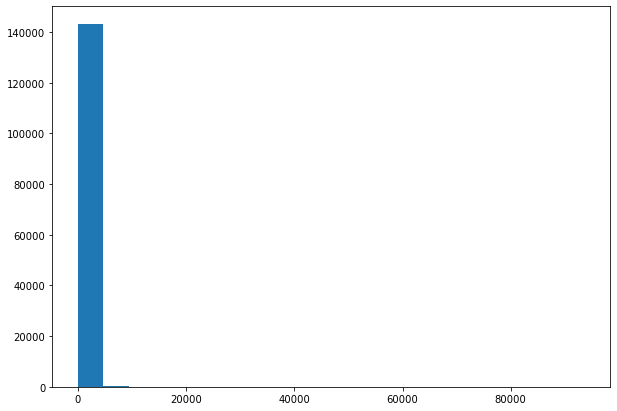



********************************************************************************************************************************************************************************************************
221 :  V317 

Data type:  float32
- No. of null values:  2
- No. of non-null values:  144231
- No. of unique values:  7115
- min:  0.0
- max:  134021.0


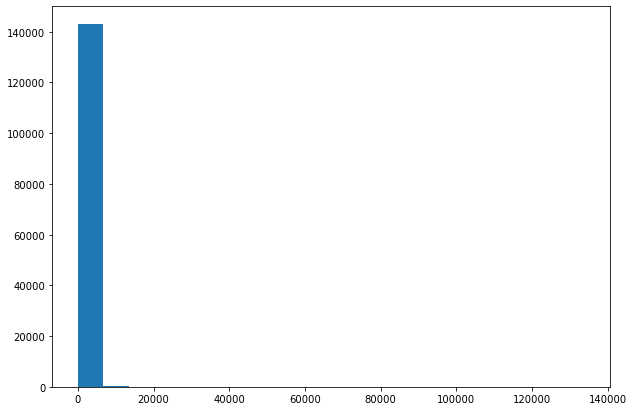



********************************************************************************************************************************************************************************************************
222 :  V318 

Data type:  float32
- No. of null values:  2
- No. of non-null values:  144231
- No. of unique values:  6496
- min:  0.0
- max:  98476.0


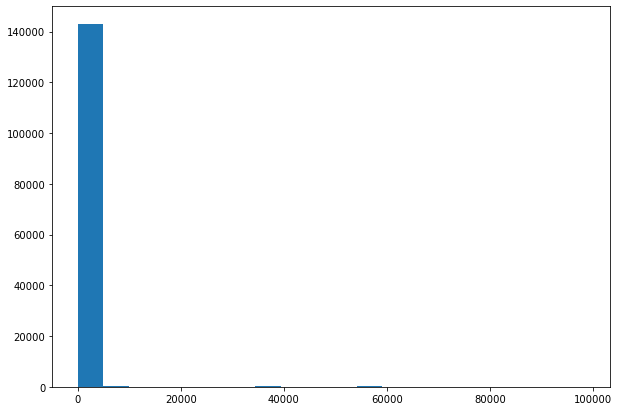



********************************************************************************************************************************************************************************************************
223 :  V319 

Data type:  float32
- No. of null values:  2
- No. of non-null values:  144231
- No. of unique values:  1640
- min:  0.0
- max:  104060.0


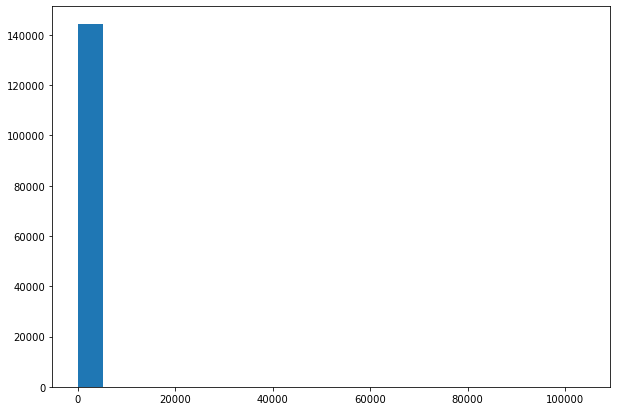



********************************************************************************************************************************************************************************************************
224 :  V320 

Data type:  float32
- No. of null values:  2
- No. of non-null values:  144231
- No. of unique values:  2030
- min:  0.0
- max:  104060.0


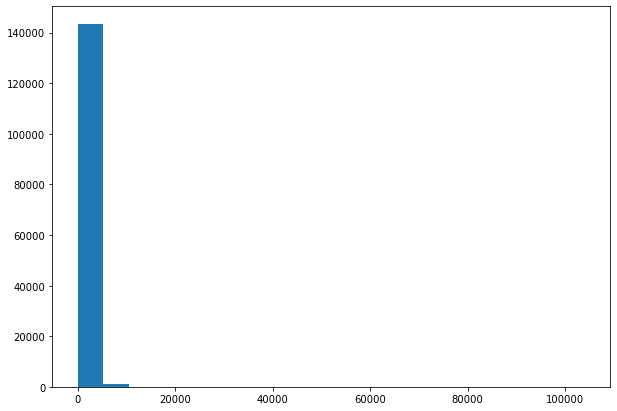



********************************************************************************************************************************************************************************************************
225 :  V321 

Data type:  float32
- No. of null values:  2
- No. of non-null values:  144231
- No. of unique values:  1845
- min:  0.0
- max:  104060.0


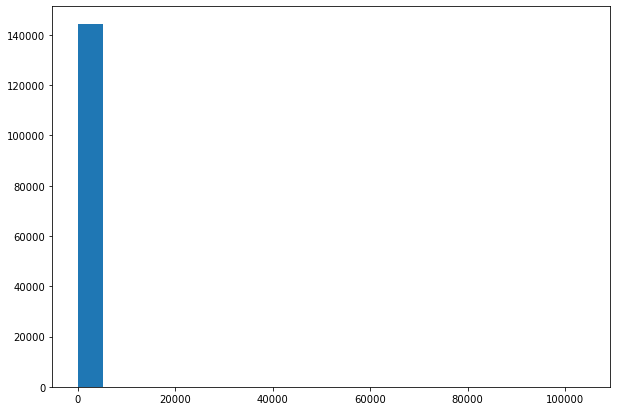



********************************************************************************************************************************************************************************************************
226 :  id_01 

Data type:  float32
- No. of null values:  0
- No. of non-null values:  144233
- No. of unique values:  77
- min:  -100.0
- max:  0.0


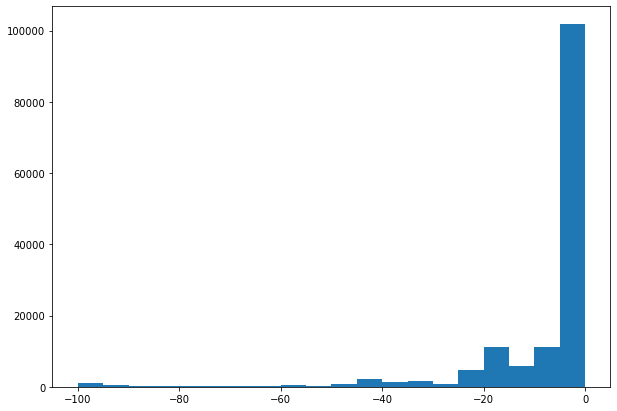



********************************************************************************************************************************************************************************************************
227 :  id_02 

Data type:  float32
- No. of null values:  3361
- No. of non-null values:  140872
- No. of unique values:  115656
- min:  1.0
- max:  999595.0


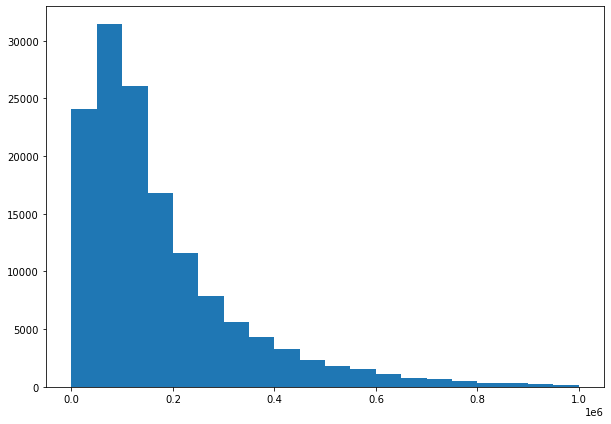



********************************************************************************************************************************************************************************************************
228 :  id_05 

Data type:  float32
- No. of null values:  7368
- No. of non-null values:  136865
- No. of unique values:  94
- min:  -72.0
- max:  52.0


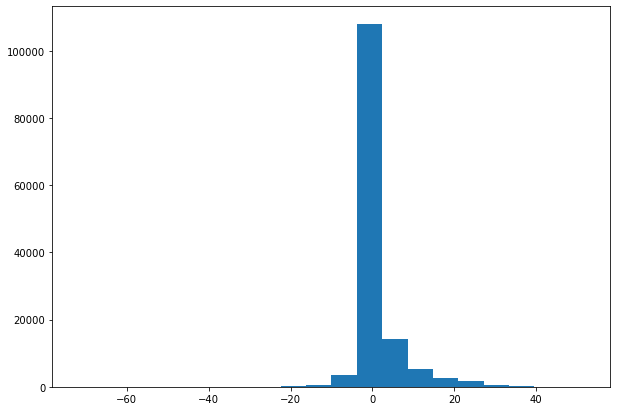



********************************************************************************************************************************************************************************************************
229 :  id_06 

Data type:  float32
- No. of null values:  7368
- No. of non-null values:  136865
- No. of unique values:  102
- min:  -100.0
- max:  0.0


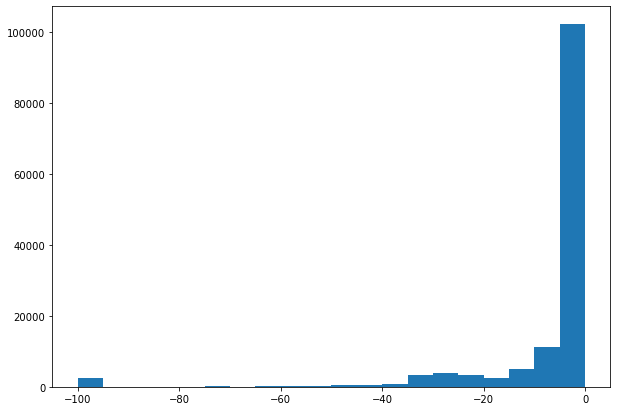



********************************************************************************************************************************************************************************************************
230 :  id_11 

Data type:  float32
- No. of null values:  3255
- No. of non-null values:  140978
- No. of unique values:  366
- min:  90.0
- max:  100.0


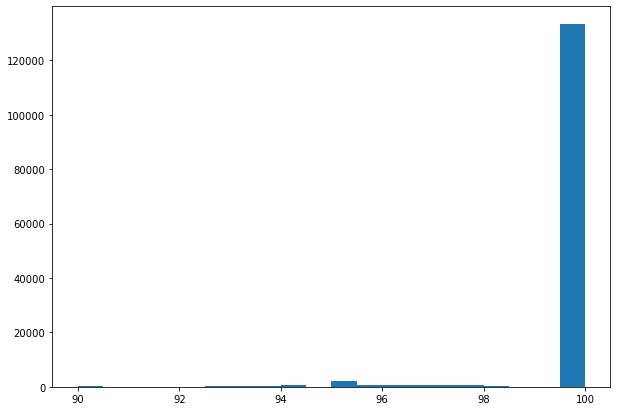



********************************************************************************************************************************************************************************************************
231 :  id_12 

Data type:  object
- No. of null values:  0
- No. of non-null values:  144233
- No. of unique values:  2
Found        21208
NotFound    123025
Name: id_12, dtype: int64


********************************************************************************************************************************************************************************************************
232 :  id_15 

Data type:  object
- No. of null values:  3248
- No. of non-null values:  140985
- No. of unique values:  4
Found      67728
New        61612
Unknown    11645
Name: id_15, dtype: int64


********************************************************************************************************************************************************************************************************
233 :  

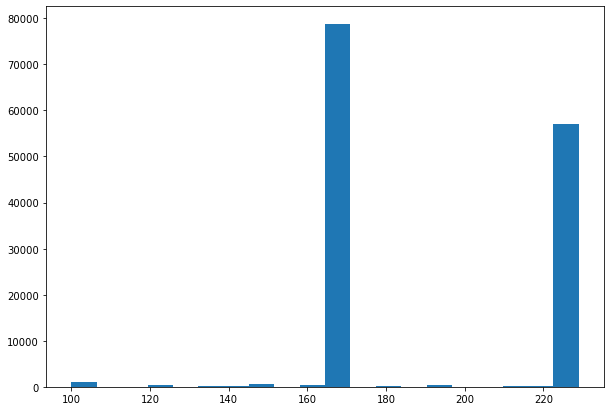



********************************************************************************************************************************************************************************************************
234 :  id_19 

Data type:  float32
- No. of null values:  4915
- No. of non-null values:  139318
- No. of unique values:  523
- min:  100.0
- max:  671.0


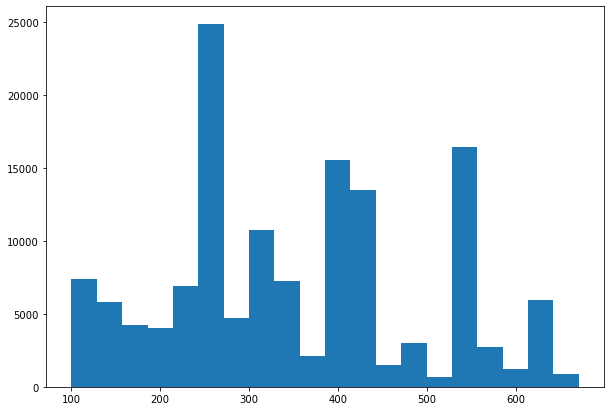



********************************************************************************************************************************************************************************************************
235 :  id_20 

Data type:  float32
- No. of null values:  4972
- No. of non-null values:  139261
- No. of unique values:  395
- min:  100.0
- max:  661.0


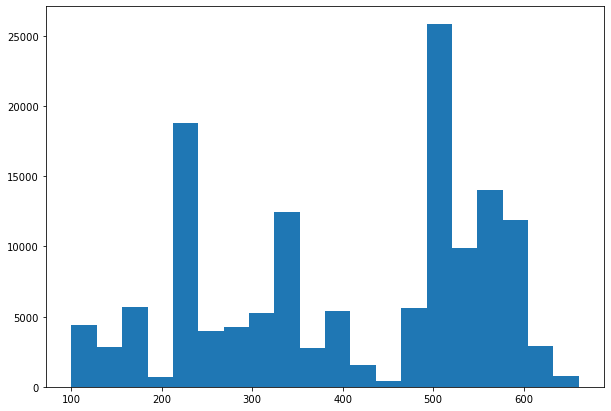



********************************************************************************************************************************************************************************************************
236 :  id_28 

Data type:  object
- No. of null values:  3255
- No. of non-null values:  140978
- No. of unique values:  3
Found    76232
New      64746
Name: id_28, dtype: int64


********************************************************************************************************************************************************************************************************
237 :  id_29 

Data type:  object
- No. of null values:  3255
- No. of non-null values:  140978
- No. of unique values:  3
Found       74926
NotFound    66052
Name: id_29, dtype: int64


********************************************************************************************************************************************************************************************************
238 :  id_31 

Data type:  

In [53]:
EDA(df_id_trans_remNA)

## Column data types

In [54]:
####################### Data description source: https://www.kaggle.com/competitions/ieee-fraud-detection/discussion/101203 

########## outcome variable
outcome_cols = ['isFraud']

########## transactional info 
transaction_cols = [
    # id
    'TransactionID', 
    # TransactionDT: timedelta from a given reference datetime (not an actual timestamp)            
    'TransactionDT']

########## categorical predictors
cat_cols = [
    # ProductCD: product code, the product for each transaction
    'ProductCD', 
    # card1 - card6: payment card information, such as card type, card category, issue bank, country, etc.
    'card1', 'card2', 'card3','card4', 'card5','card6', 
    # address
    'addr1','addr2',
    # emaildomain: purchaser and recipient email domain
    'P_emaildomain', 'R_emaildomain',
    # match, such as names on card and address, etc.
    'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9',
    # identity categorical
    'id_12', 'id_13', 'id_14','id_15', 'id_16', 'id_17', 'id_18', 'id_19', 'id_20', 'id_21', 'id_22',
    'id_23', 'id_24', 'id_25', 'id_26', 'id_27', 'id_28', 'id_29', 'id_30','id_31', 'id_32', 'id_33', 
    'id_34', 'id_35', 'id_36', 'id_37', 'id_38',
    # device
    'DeviceType', 'DeviceInfo']
    
############## numerical predictors
num_cols = [
    # transaction payment amount in USD
    'TransactionAmt',
    # distance
    'dist1','dist2',
    # C1-C14: counting, such as how many addresses are found to be associated with the payment card, etc. The actual meaning is masked.
    'C1','C2', 'C3', 'C4','C5','C6', 'C7','C8','C9','C10','C11','C12','C13','C14',
    # timedelta, such as days between previous transaction, etc.
    'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15',
    # Vesta engineered rich features, including ranking, counting, and other entity relations.
    'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 
    'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V29', 
    'V30', 'V31', 'V32', 'V33', 'V34', 'V35', 'V36', 'V37', 'V38', 'V39', 'V40', 'V41', 'V42', 'V43', 
    'V44', 'V45', 'V46', 'V47', 'V48', 'V49', 'V50', 'V51', 'V52', 'V53', 'V54', 'V55','V56', 'V57', 
    'V58', 'V59', 'V60', 'V61', 'V62', 'V63', 'V64', 'V65','V66', 'V67', 'V68', 'V69', 'V70', 'V71', 
    'V72', 'V73', 'V74', 'V75','V76', 'V77', 'V78', 'V79', 'V80', 'V81', 'V82', 'V83', 'V84', 'V85',
    'V86', 'V87', 'V88', 'V89', 'V90', 'V91', 'V92', 'V93', 'V94', 'V95','V96', 'V97', 'V98', 'V99', 
    'V100', 'V101', 'V102', 'V103', 'V104', 'V105', 'V106', 'V107', 'V108', 'V109', 'V110', 'V111', 
    'V112', 'V113','V114', 'V115', 'V116', 'V117', 'V118', 'V119', 'V120', 'V121', 'V122', 'V123', 
    'V124', 'V125', 'V126', 'V127', 'V128', 'V129', 'V130', 'V131','V132', 'V133', 'V134', 'V135', 
    'V136', 'V137', 'V138', 'V139', 'V140','V141', 'V142', 'V143', 'V144', 'V145','V146', 'V147', 
    'V148', 'V149', 'V150', 'V151', 'V152', 'V153', 'V154','V155', 'V156', 'V157', 'V158', 'V159', 
    'V160', 'V161', 'V162', 'V163','V164', 'V165', 'V166', 'V167', 'V168', 'V169', 'V170', 'V171', 
    'V172','V173', 'V174', 'V175', 'V176', 'V177', 'V178', 'V179', 'V180', 'V181','V182', 'V183', 
    'V184', 'V185', 'V186', 'V187', 'V188', 'V189', 'V190','V191', 'V192', 'V193', 'V194', 'V195', 
    'V196', 'V197', 'V198', 'V199','V200', 'V201', 'V202', 'V203', 'V204', 'V205', 'V206', 'V207', 
    'V208', 'V209', 'V210', 'V211', 'V212', 'V213', 'V214', 'V215', 'V216', 'V217','V218', 'V219', 
    'V220', 'V221', 'V222', 'V223', 'V224', 'V225', 'V226','V227', 'V228', 'V229', 'V230', 'V231',
    'V232','V233','V234','V235','V236','V237','V238','V239','V240','V241','V242','V243','V244','V245', 
    'V246', 'V247','V248', 'V249','V250','V251','V252','V253','V254','V255', 'V256', 'V257', 'V258', 
    'V259', 'V260', 'V261', 'V262', 'V263','V264', 'V265', 'V266', 'V267', 'V268', 'V269', 'V270', 
    'V271', 'V272','V273', 'V274', 'V275', 'V276', 'V277', 'V278', 'V279', 'V280', 'V281', 'V282', 
    'V283', 'V284', 'V285', 'V286', 'V287', 'V288', 'V289', 'V290','V291', 'V292', 'V293', 'V294',
    'V295', 'V296', 'V297', 'V298', 'V299','V300', 'V301', 'V302', 'V303', 'V304', 'V305', 'V306', 
    'V307', 'V308','V309', 'V310', 'V311', 'V312', 'V313', 'V314',  'V315', 'V316', 'V317','V318', 
    'V319', 'V320', 'V321', 'V322', 'V323', 'V324', 'V325', 'V326','V327', 'V328', 'V329', 'V330', 
    'V331', 'V332', 'V333', 'V334', 'V335', 'V336', 'V337', 'V338', 'V339',
    # identity numerical
    'id_01', 'id_02', 'id_03', 'id_04', 'id_05', 'id_06', 'id_07', 'id_08', 'id_09', 'id_10', 'id_11']

# check if we have all columns from original dataframe here (non-common elements in the 2 lists) 
assert(len(set(cat_cols+ num_cols + transaction_cols + outcome_cols) ^ set(df_id_trans.columns)) == 0)

In [55]:
################ store only variables that were not excluded in the missing value per column analysis

# outcome 
outcome_cols_remNA = list(set(outcome_cols).intersection(df_id_trans_remNA.columns))

# transaction
transaction_cols_remNA = list(set(transaction_cols).intersection(df_id_trans_remNA.columns))

# categorical
cat_cols_remNA = list(set(cat_cols).intersection(df_id_trans_remNA.columns))

# numerical
num_cols_remNA = list(set(num_cols).intersection(df_id_trans_remNA.columns))

# Categorical variables exploration and recategorisation
- Let's check which categorical variables can be binned or have relatively few variables

- Let's check if the categorical variables are:
    - MECE
    - Don't have too many categories


- In some cases I will replace nulls with 'unknown' (when it is difficult to unanimously choose the most popular value)


- 3 cases:
    - 1. NA as 'unknown' (no clear most frequent value) +  then create dummies
        - 'ProductCD', 'DeviceType', 'id_28', 'card6', 'id_35', 'id_29', 'card4', 'id_12', 'id_36', 'id_38', 'id_37', 'id_15', 
    - 2. Recategorise + then create dummies
        - 'id_31', 'R_emaildomain', 'P_emaildomain'
    - 3. Impute as categorical with mode + treat as numeric afterwards
        - 'card5', 'card2', 'id_17', 'card3', 'card1', 'id_20', 'id_19'

In [56]:
# example of column that requires recategorisation
df_id_trans['id_31'].value_counts().head(30)

chrome 63.0                   22000
mobile safari 11.0            13423
mobile safari generic         11474
ie 11.0 for desktop            9030
safari generic                 8195
chrome 62.0                    7182
chrome 65.0                    6871
chrome 64.0                    6711
chrome 63.0 for android        5806
chrome generic                 4778
chrome 66.0                    4264
edge 16.0                      4188
chrome 64.0 for android        3473
chrome 65.0 for android        3336
firefox 57.0                   3315
mobile safari 10.0             2779
chrome 66.0 for android        2349
chrome 62.0 for android        2097
edge 15.0                      1600
chrome generic for android     1158
firefox 59.0                   1099
samsung browser 6.2            1061
firefox 58.0                    833
chrome 49.0                     719
firefox                         673
ie 11.0 for tablet              647
chrome 61.0                     642
safari 11.0                 

## Replace NA with unknown

In [58]:
# replace with unknown
df_id_trans_remNA.loc[:,['ProductCD', 'DeviceType', 'id_28', 'card6', 'id_35', 'id_29', 'card4', 'id_12', 'id_36', 'id_38', 'id_37', 'id_15']] = df_id_trans_remNA.loc[:,['ProductCD', 'DeviceType', 'id_28', 'card6', 'id_35', 'id_29', 'card4', 'id_12', 'id_36', 'id_38', 'id_37', 'id_15']].fillna("Unknown")


## Recategorize 

In [59]:
############# recategorize browsers


def id_31_recategorization(row):
    """
    browser recategorization function
    """
    
    if "chrome" in row.lower():
        return "chrome"
  
    elif "safari" in row.lower():
        return "safari"
        
    
    elif "edge" in row.lower():
        return "edge"
        
        
    elif "firefox" in row.lower():
        return "firefox"
        
        
    elif "samsung" in row.lower():
        return "samsung"
        
        
    elif "opera" in row.lower():
        return "opera"
    
    else:
        return "other"
    
    
# perform recategorization
df_id_trans_remNA.loc[:,'id_31'] = df_id_trans_remNA.loc[:,'id_31'].astype(str).apply(id_31_recategorization)

In [60]:
################### recategosie email domain columns


def emaildomain_recategorization(row):
    """
    email domain recategorization function
    """
    
    if "gmail" in row.lower():
        return "gmail"
  
    elif "hotmail" in row.lower():
        return "hotmail"
    
    elif "yahoo" in row.lower():
        return "yahoo"
    
    elif "anonymous" in row.lower():
        return "anonymous"
    
    elif "aol" in row.lower():
        return "aol"

    elif "outlook" in row.lower():
        return "outlook"
    
    elif "comcast" in row.lower():
        return "comcast"
    
    elif "icloud" in row.lower():
        return "icloud"
    else:
        return "other"
    

# perform recategorization
df_id_trans_remNA.loc[:,'R_emaildomain'] = df_id_trans_remNA.loc[:,'R_emaildomain'].astype(str).apply(emaildomain_recategorization)
df_id_trans_remNA.loc[:,'P_emaildomain'] = df_id_trans_remNA.loc[:,'P_emaildomain'].astype(str).apply(emaildomain_recategorization)

# Drop unary variables

In [61]:
# explrore if any unary variables and drop these

print(df_id_trans_remNA.shape)

mask_nunique = df_id_trans_remNA.nunique().sort_values() == 1

unary_variables = df_id_trans_remNA.nunique()[mask_nunique].index

df_id_trans_remNA = df_id_trans_remNA.drop(unary_variables, axis=1)

df_id_trans_remNA.shape

(144233, 244)


(144233, 240)

# Encoding - create dummies for relevant categorical columns
-  we assumed earlier that we are aware of the categories that we may have -> this happen very often in production as we allow for them (otherwise other or unknown)
- in cases of situations that there might be values unobserved yet OHE is recommended

In [62]:
# only categorical (ordinal treated as numeric)
cols_toDummyConvert = ['ProductCD',
                       'DeviceType',  
                       'id_28', 
                       'card6', 
                       'id_35', 
                       'id_29', 
                       'card4', 
                       'id_12', 
                       'id_36', 
                       'id_38', 
                       'id_37', 
                       'id_15', 
                       'id_31', 
                       'R_emaildomain',  
                       'P_emaildomain'] 

In [63]:
# create dummy variables
one_hot_encoded = pd.get_dummies(df_id_trans_remNA[cols_toDummyConvert])

# add one-hot encoded columns to the original dataframe
df_id_trans_remNA_dummyCols = pd.concat([df_id_trans_remNA, one_hot_encoded], axis=1)

# drop encoded columns 
df_id_trans_remNA_dummyCols = df_id_trans_remNA_dummyCols.drop(columns = cols_toDummyConvert)

# Partition data

In [64]:
# define X and Y variables
X = df_id_trans_remNA_dummyCols.drop(transaction_cols + outcome_cols, axis=1)
y = df_id_trans_remNA_dummyCols['isFraud']

# perform splitting 
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size = 0.3, stratify=y, random_state=100)

# Impute missing values

In [65]:
# Check if outcome variable has missing values
print("Number of missing outcome variables: ", sum(df_id_trans_remNA_dummyCols['isFraud'].isna()))

Number of missing outcome variables:  0


In [66]:
# categorical columns to impute with mode
cat_cols_remNA_toImpute = list(set(X.columns) - set(num_cols_remNA))

In [67]:
# numerical columns to impute with average
num_cols_remNA = list(set(num_cols_remNA) - set(unary_variables))

In [68]:
#################### imputed missing values using: Python Data Science handbook by Jacob T. Vanderplas (O'Reilly)

######### X df with all types 
X_train_imp = X_train.copy()
X_test_imp = X_test.copy()

# numerical predictors imputation
imp_mean = SimpleImputer(strategy='mean')
imp_mean = imp_mean.fit(X_train_imp[num_cols_remNA])
X_train_imp[num_cols_remNA] = imp_mean.transform(X_train_imp[num_cols_remNA])
X_test_imp[num_cols_remNA] = imp_mean.transform(X_test_imp[num_cols_remNA])

# categorical predictors imputation
imp_mode = SimpleImputer(strategy='most_frequent')
imp_mode = imp_mode.fit(X_train_imp[cat_cols_remNA_toImpute])
X_train_imp[cat_cols_remNA_toImpute] = imp_mode.transform(X_train_imp[cat_cols_remNA_toImpute])
X_test_imp[cat_cols_remNA_toImpute] = imp_mode.transform(X_test_imp[cat_cols_remNA_toImpute])

# Scalling / normalizing

In [69]:
def scale_data_new(X_train, X_test, binary_cols):
    """
    scale variables
    """
    
    # select non-binary cols for scaling
    X_train_toScale = X_train.loc[:, ~X_train.columns.isin(binary_cols)]
    X_test_toScale = X_test.loc[:, ~X_test.columns.isin(binary_cols)]
    
    # keep binary cols that will be later on merged to the main dataframe
    X_train_dummy = X_train.loc[:, X_train.columns.isin(binary_cols)]
    X_test_dummy = X_test.loc[:, X_test.columns.isin(binary_cols)]
    
    # fit scaler on the train set and then transform the train and test sets
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_toScale)
    X_test_scaled = scaler.transform(X_test_toScale)
    
    # create df with scaled variables
    X_train_scaled = pd.DataFrame(X_train_scaled, columns = X_train_toScale.columns, index = X_train_toScale.index)
    X_test_scaled = pd.DataFrame(X_test_scaled, columns = X_test_toScale.columns, index = X_test_toScale.index)
    
    # concat with df containing binary variables
    X_train_scaled = pd.concat([X_train_scaled, X_train_dummy], axis=1)
    X_test_scaled = pd.concat([X_test_scaled, X_test_dummy], axis=1)
    
    return X_train_scaled, X_test_scaled

# Over / Under sampling

In [45]:
########################## perform undersampling

# merge X and y train
train_imp = pd.concat([X_train_imp, y_train],axis=1)

# Separate the majority and minority classes
majority_class = train_imp[train_imp['isFraud'] == 0]
minority_class = train_imp[train_imp['isFraud'] == 1]


########## Undersampling

# Undersample the majority class
undersampled_majority = resample(majority_class, 
                                 replace=False, # sampling without replacement
                                 n_samples=len(minority_class), # match minority n
                                 random_state=100) # set random seed for reproducibility
# Combine the minority class and undersampled majority class
undersampled_training_set = pd.concat([minority_class, undersampled_majority])


########## Oversampling

# Undersample the majority class
oversampled_minority = resample(minority_class, 
                                 replace=True, # sampling with replacement
                                 n_samples=len(majority_class), # match minority n
                                 random_state=100) # set random seed for reproducibility
# Combine the minority class and undersampled majority class
oversampled_training_set = pd.concat([majority_class, oversampled_minority])


# prepare undersampled train sets
X_train_imp_undersampled, y_train_undersampled = undersampled_training_set.drop('isFraud',axis=1), undersampled_training_set['isFraud']

# prepare oversampled train sets
X_train_imp_oversampled, y_train_oversampled = oversampled_training_set.drop('isFraud', axis=1), oversampled_training_set['isFraud']

# Feature selection

# Modelling

## Functions

In [73]:
def plot_cm(cm):
    """
    function to plot confusion matrix
    """
    
    fig, ax = plt.subplots()
    sns.heatmap(cm, fmt='d', annot=True, square=True, cmap='Blues', vmin=1, vmax=1, linewidths=0.1, linecolor='k',cbar=False, ax=ax)
    ax.set_title("Confusion Matrix")
    ax.set_xlabel("Predicted Class")
    ax.xaxis.label.set_size(12)
    ax.set_ylabel('True Class')
    ax.yaxis.label.set_size(12)
    sns.despine(left=False, right=False, top=False, bottom=False)


In [74]:
def plot_cutoff_f1(predicted_proba, y_test, thr):
    """
    function to plot the f1 score for various cut-off values"
    """
    
    # storage for f1 scores 
    dict_cutoff_f1 = {}
    
    # calculate f1 scores for various cut-off values
    for i in np.arange(0,1.01,0.1):
        dict_cutoff_f1[i] = round(f1_score(y_test, 1*(predicted_proba > i)),2)
        print(f"Cutoff = {i}")
    
    # Create the line chart
    x = dict_cutoff_f1.keys()
    y = dict_cutoff_f1.values()
    plt.plot(x, y, marker = 'o')

    # Set the x-axis and y-axis labels
    plt.xlabel('Cut-off value')
    plt.ylabel('F1 score')
    plt.ylim(0,1)
    for i,j in zip(x, y):
        if j > thr:
            plt.annotate(str(j),xy=(i,j), xytext=(5,14), textcoords='offset points',ha='center')

    # Display the chart
    plt.show()
    
    return dict_cutoff_f1


## Naive benchmark

In [75]:
y_train.value_counts() / len(y_train)

0    0.921526
1    0.078474
Name: isFraud, dtype: float64

## Scoring measure

In [76]:
# examine sklearn scoring measure options
sorted(SCORERS.keys())

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_absolute_percentage_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'rand_score',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'roc_auc_ovo',
 'roc_auc_ovo_weighted',
 'roc_auc_ovr',
 'roc_auc_ovr_we

## Decision Trees

### Hyperparameter tunning

#### Randomized search

In [77]:
############### run randomised grid search to find reasonable hyperparameter values

# 5-fold cv 
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=100)

# define grid with hyperparameter values
param_grid_decisionTree_randomized = {
        'criterion': ["gini", "entropy"],
        "max_depth": list(np.arange(10,51,10)) + [None],
        "min_samples_leaf": np.arange(1,11,1),
        "max_features" : ["auto", "sqrt", "log2", None],
        "class_weight" : [{0:1, 1:1},{0:1, 1:2},{0:1, 1:3}, {0:1, 1:4}, {0:1, 1:5},  {0:1, 1:7}, {0:1, 1:10}, {0:1, 1:14}, {0:1, 1:20}],
        "random_state" : [100]
    }

# randomised grid search with f1 scoring metric
grid_decisionTree_randomized = RandomizedSearchCV(DecisionTreeClassifier(), param_grid_decisionTree_randomized, cv=cv, scoring='f1', n_iter = 50, verbose=1, n_jobs=-1, random_state=100)
grid_decisionTree_randomized.fit(X_train_imp, y_train);

# print best parameters and score
print(grid_decisionTree_randomized.best_params_)
print(grid_decisionTree_randomized.best_score_)

Fitting 15 folds for each of 50 candidates, totalling 750 fits
{'random_state': 100, 'min_samples_leaf': 8, 'max_features': None, 'max_depth': 40, 'criterion': 'gini', 'class_weight': {0: 1, 1: 1}}
0.6809569267059599


In [78]:
######### save results as a pickle file 

# with open('grid_decisionTree_randomized_bestParams.pkl', 'wb') as f:
#     pickle.dump(grid_decisionTree_randomized.best_params_, f)
# with open('grid_decisionTree_randomized_bestF1score.pkl', 'wb') as f:
#     pickle.dump(grid_decisionTree_randomized.best_score_, f)
# with open('grid_decisionTree_randomized_cvResults.pkl', 'wb') as f:
#     pickle.dump(grid_decisionTree_randomized.cv_results_, f)

In [80]:
####### read pickle file with results 

with open('grid_decisionTree_randomized_bestParams.pkl', 'rb') as f:
    grid_decisionTree_randomized_bestParams = pickle.load(f)
with open('grid_decisionTree_randomized_bestF1score.pkl', 'rb') as f:
    grid_decisionTree_randomized_bestF1score = pickle.load(f)
with open('grid_decisionTree_randomized_cvResults.pkl', 'rb') as f:
    grid_decisionTree_randomizcvResults = pickle.load(f)

print(grid_decisionTree_randomized_bestF1score)
grid_decisionTree_randomized_bestParams

0.6809569267059599


{'random_state': 100,
 'min_samples_leaf': 8,
 'max_features': None,
 'max_depth': 40,
 'criterion': 'gini',
 'class_weight': {0: 1, 1: 1}}

#### Complete grid search

In [81]:
############### run complete grid search to find best hyperparameter values (among tested)

# 5-fold cv 
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=100)

# define grid with hyperparameter values
param_grid_decisionTree_GridSearch = {
    'criterion': ["gini", "entropy"],
    "max_depth": list(np.arange(38,43,1)) + [None],
    "min_samples_leaf": [7,8,9],
    "max_features" :  [None],
    "class_weight" : [{0:1, 1:1},{0:1, 1:2},{0:1, 1:3}, {0:1, 1:4}, {0:1, 1:5}],
    "random_state" : [100]
}

# exhaustive grid search with f1 scoring metric
grid_decisionTree_GridSearch = GridSearchCV(DecisionTreeClassifier(), param_grid_decisionTree_GridSearch, cv=cv, scoring='f1', verbose=1, n_jobs=-1)
grid_decisionTree_GridSearch.fit(X_train_imp, y_train);

# print best hyperparameters and f1 score
print(grid_decisionTree_GridSearch.best_params_)
grid_decisionTree_GridSearch.best_score_

Fitting 15 folds for each of 180 candidates, totalling 2700 fits
{'class_weight': {0: 1, 1: 1}, 'criterion': 'gini', 'max_depth': 38, 'max_features': None, 'min_samples_leaf': 8, 'random_state': 100}


0.6819652377893634

In [83]:
######### save results as a pickle file 

# with open('grid_decisionTree_GridSearch_bestParams.pkl', 'wb') as f:
#      pickle.dump(grid_decisionTree_GridSearch.best_params_, f)
# with open('grid_decisionTree_GridSearch_bestF1score.pkl', 'wb') as f:
#      pickle.dump(grid_decisionTree_GridSearch.best_score_, f)
# with open('grid_decisionTree_GridSearch_cvResults.pkl', 'wb') as f:
#      pickle.dump(grid_decisionTree_GridSearch.cv_results_, f)

In [84]:
####### read pickle file with results 

with open('grid_decisionTree_GridSearch_bestParams.pkl', 'rb') as f:
    grid_decisionTree_GridSearch_bestParams = pickle.load(f)
with open('grid_decisionTree_GridSearch_bestF1score.pkl', 'rb') as f:
    grid_decisionTree_GridSearch_bestF1score = pickle.load(f)
with open('grid_decisionTree_GridSearch_cvResults.pkl', 'rb') as f:
    grid_decisionTree_GridSearch_cvResults = pickle.load(f)
    
print(grid_decisionTree_GridSearch_bestF1score)
grid_decisionTree_GridSearch_bestParams

0.6819652377893634


{'class_weight': {0: 1, 1: 1},
 'criterion': 'gini',
 'max_depth': 38,
 'max_features': None,
 'min_samples_leaf': 8,
 'random_state': 100}

### Fit and predict

In [85]:
# create decision tree instance
decisionTree = DecisionTreeClassifier(
    criterion = grid_decisionTree_GridSearch_bestParams["criterion"],
    max_depth = grid_decisionTree_GridSearch_bestParams["max_depth"],
    min_samples_leaf = grid_decisionTree_GridSearch_bestParams["min_samples_leaf"],
    max_features = grid_decisionTree_GridSearch_bestParams["max_features"],
    class_weight=  grid_decisionTree_GridSearch_bestParams['class_weight'],
    random_state=100)

# fit decision tree model
decisionTree = decisionTree.fit(X_train_imp, y_train)

######### pickle (to save time when reloading notebook again)
# with open('decisionTree.pkl', 'wb') as f:
#     pickle.dump(decisionTree, f)
# with open('decisionTree.pkl', 'rb') as f:
#     decisionTree = pickle.load(f)

# perform prediction
pred_decisionTree = decisionTree.predict(X_test_imp)

# show confusion matrix and f1 score
display(confusion_matrix(y_test, pred_decisionTree))
print(f1_score(y_test, pred_decisionTree))

array([[39215,   660],
       [ 1215,  2180]])

0.6992782678428228


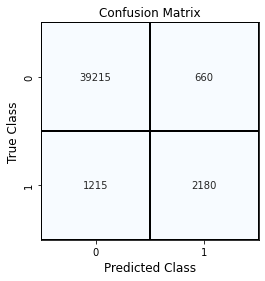

In [89]:
# plot confusion matrix
cm_decisionTree = confusion_matrix(y_test, pred_decisionTree)
plot_cm(cm_decisionTree)

In [90]:
# calculate various scores
display(pd.DataFrame(
    {"Metric" : ["f1", "precision", "recall", "accuracy"], 
     "Score" : [f1_score(y_test, pred_decisionTree), precision_score(y_test, pred_decisionTree),recall_score(y_test, pred_decisionTree), accuracy_score(y_test, pred_decisionTree)]}))
    

,Metric,Score
0,f1,0.699278
1,precision,0.767606
2,recall,0.642121
3,accuracy,0.956667


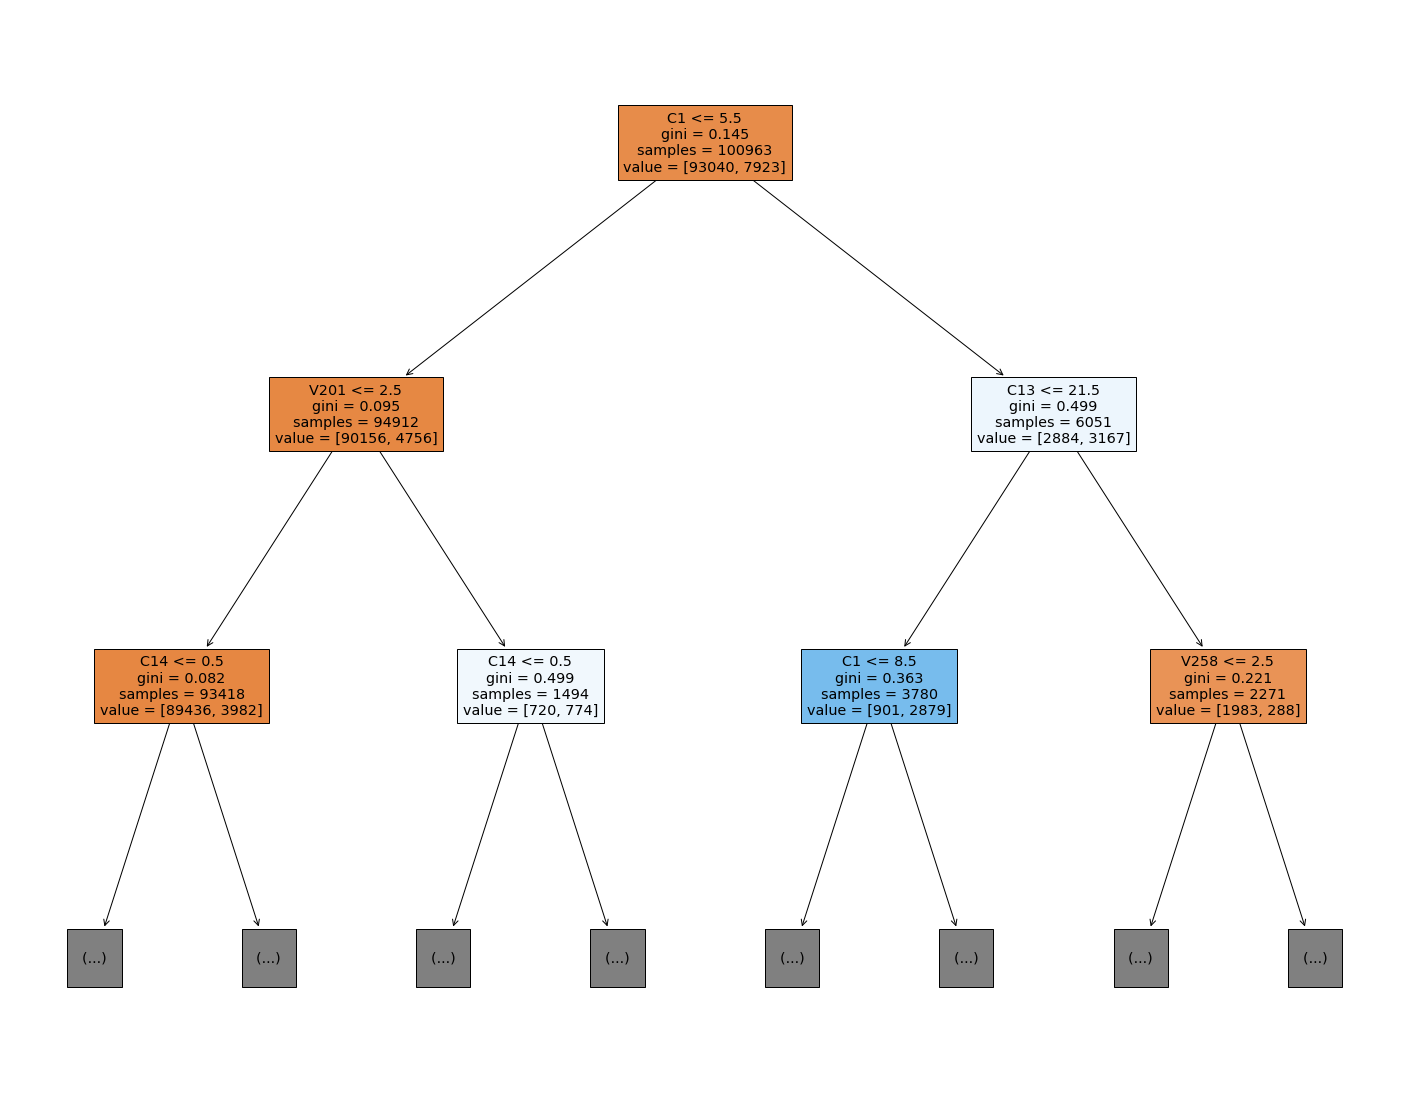

In [88]:
# plot decision tree
fig = plt.figure(figsize=(25,20))
_ = plot_tree(decisionTree, feature_names=X_train_imp.columns,max_depth=2, filled=True)

### Cutofff

Cutoff = 0.0
Cutoff = 0.1
Cutoff = 0.2
Cutoff = 0.30000000000000004
Cutoff = 0.4
Cutoff = 0.5
Cutoff = 0.6000000000000001
Cutoff = 0.7000000000000001
Cutoff = 0.8
Cutoff = 0.9
Cutoff = 1.0


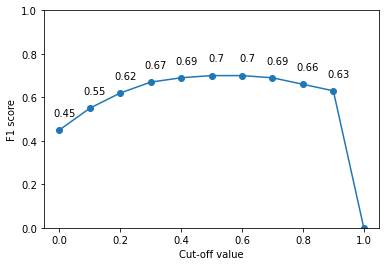

{0.0: 0.45,
 0.1: 0.55,
 0.2: 0.62,
 0.30000000000000004: 0.67,
 0.4: 0.69,
 0.5: 0.7,
 0.6000000000000001: 0.7,
 0.7000000000000001: 0.69,
 0.8: 0.66,
 0.9: 0.63,
 1.0: 0.0}

In [91]:
# plot f1 scores for various cut-off values
plot_cutoff_f1(decisionTree.predict_proba(X_test_imp)[:,1], y_test, 0.2)

## Random Forest Classifier

### Randomized Search

In [92]:
############### run randomised grid search to find reasonable hyperparameter values

# 5-fold cv
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=100)

# define grid with hyperparameter values
param_grid_randomForest_randomized = {
    "n_estimators" : [100, 150, 200, 250],
    'criterion': ["gini", "entropy"],
    "max_depth": [21, 31, 41, None],
    "max_features" : ["auto", None],
    "bootstrap" : [False,True],
    "class_weight" : [{0:1, 1:1},{0:1, 1:3}, {0:1, 1:5}],
    "random_state" : [100]
}

# randomised grid search with f1 scoring metric
grid_randomForest_randomized = RandomizedSearchCV(RandomForestClassifier(), param_grid_randomForest_randomized, cv=cv, scoring='f1', n_iter=20, verbose=3, n_jobs=-1, random_state=100)
grid_randomForest_randomized.fit(X_train_imp, y_train);

# print best parameters and score
print(grid_randomForest_randomized.best_params_)
grid_randomForest_randomized.best_score_

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 3/5] END bootstrap=True, class_weight={0: 1, 1: 5}, criterion=gini, max_depth=None, max_features=auto, n_estimators=150, random_state=100;, score=0.709 total time=  33.0s
[CV 2/5] END bootstrap=False, class_weight={0: 1, 1: 5}, criterion=gini, max_depth=None, max_features=None, n_estimators=150, random_state=100;, score=0.676 total time=11.9min
[CV 1/5] END bootstrap=True, class_weight={0: 1, 1: 3}, criterion=gini, max_depth=31, max_features=auto, n_estimators=200, random_state=100;, score=0.710 total time=  44.1s
[CV 5/5] END bootstrap=True, class_weight={0: 1, 1: 3}, criterion=gini, max_depth=31, max_features=auto, n_estimators=200, random_state=100;, score=0.725 total time=  44.7s
[CV 4/5] END bootstrap=False, class_weight={0: 1, 1: 3}, criterion=gini, max_depth=31, max_features=None, n_estimators=200, random_state=100;, score=0.683 total time=17.5min
[CV 2/5] END bootstrap=True, class_weight={0: 1, 1: 5}, criterion=e

0.7656359874968153

In [90]:
######### save results as a pickle file 

# with open('grid_randomForest_randomized_bestParams.pkl', 'wb') as f:
#     pickle.dump(grid_randomForest_randomized.best_params_, f)
# with open('grid_randomForest_randomized_bestF1score.pkl', 'wb') as f:
#     pickle.dump(grid_randomForest_randomized.best_score_, f)
# with open('grid_randomForest_randomized_cvResult.pkl', 'wb') as f:
#     pickle.dump(grid_randomForest_randomized.cv_results_, f)

In [94]:
####### read pickle file with results 

with open('grid_randomForest_randomized_bestParams.pkl', 'rb') as f:
    grid_randomForest_randomized_bestParams = pickle.load(f)
with open('grid_randomForest_randomized_bestF1score.pkl', 'rb') as f:
    grid_randomForest_randomized_bestF1score = pickle.load(f)
with open('grid_randomForest_randomized_cvResult.pkl', 'rb') as f:
    grid_randomForest_randomized_cvResults = pickle.load(f)
    
print(grid_randomForest_randomized_bestF1score)
grid_randomForest_randomized_bestParams

0.7656359874968153


{'random_state': 100,
 'n_estimators': 100,
 'max_features': None,
 'max_depth': 31,
 'criterion': 'gini',
 'class_weight': {0: 1, 1: 1},
 'bootstrap': True}

### Complete grid Search

In [82]:
############### run complete grid search to find best hyperparameter values (among tested)

# 5-fold cv 
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=100)

# define grid with hyperparameter values
param_grid_randomForest_GridSearch = {
    "n_estimators" : [75,100,125],
    "max_features" : ["auto", None],
    'criterion': ["gini"],
    "max_depth": [26,31,36],
    "random_state" : [100],
    "bootstrap" : [True, False],
    "class_weight" : [{0:1, 1:1}]
}

# exhaustive grid search with f1 scoring metric
grid_randomForest_GridSearch = GridSearchCV(RandomForestClassifier(), param_grid_randomForest_GridSearch, cv=cv, scoring='f1', verbose=3, n_jobs=-1)
grid_randomForest_GridSearch.fit(X_train_imp, y_train);

# print best hyperparameters and f1 score
print(grid_randomForest_GridSearch.best_params_)
print(grid_randomForest_GridSearch.best_score_)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV 2/5] END bootstrap=True, class_weight={0: 1, 1: 1}, criterion=gini, max_depth=26, max_features=auto, n_estimators=100, random_state=100;, score=0.733 total time=  24.4s
[CV 5/5] END bootstrap=True, class_weight={0: 1, 1: 1}, criterion=gini, max_depth=26, max_features=None, n_estimators=75, random_state=100;, score=0.767 total time= 4.4min
[CV 5/5] END bootstrap=True, class_weight={0: 1, 1: 1}, criterion=gini, max_depth=26, max_features=None, n_estimators=125, random_state=100;, score=0.771 total time= 7.5min
[CV 4/5] END bootstrap=True, class_weight={0: 1, 1: 1}, criterion=gini, max_depth=31, max_features=None, n_estimators=100, random_state=100;, score=0.773 total time= 6.5min
[CV 1/5] END bootstrap=True, class_weight={0: 1, 1: 1}, criterion=gini, max_depth=36, max_features=auto, n_estimators=75, random_state=100;, score=0.720 total time=  18.1s
[CV 1/5] END bootstrap=True, class_weight={0: 1, 1: 1}, criterion=gini, max

In [100]:
######### save results as a pickle file 

# with open('grid_randomForest_GridSearch_bestParams.pkl', 'wb') as f:
#     pickle.dump(grid_randomForest_GridSearch.best_params_, f)
    
# with open('grid_randomForest_GridSearch_bestF1score.pkl', 'wb') as f:
#     pickle.dump(grid_randomForest_GridSearch.best_score_, f)
    
# with open('grid_randomForest_GridSearch_crossVal.pkl', 'wb') as f:
#     pickle.dump(grid_randomForest_GridSearch.cv_results_, f)  

In [95]:
####### read pickle file with results 

with open('grid_randomForest_GridSearch_bestParams.pkl', 'rb') as f:
    grid_randomForest_GridSearch_bestParams = pickle.load(f)
    
with open('grid_randomForest_GridSearch_bestF1score.pkl', 'rb') as f:
    grid_randomForest_GridSearch_bestF1score = pickle.load(f)

with open('grid_randomForest_GridSearch_crossVal.pkl', 'rb') as f:
    grid_randomForest_GridSearch_crossVal = pickle.load(f)
    
print(grid_randomForest_GridSearch_bestParams)
grid_randomForest_GridSearch_bestF1score

{'bootstrap': True, 'class_weight': {0: 1, 1: 1}, 'criterion': 'gini', 'max_depth': 36, 'max_features': None, 'n_estimators': 125, 'random_state': 100}


0.7667373802010868

### Fit and predict

In [147]:
# create random forest  instance
rfc_grid = RandomForestClassifier(
    n_estimators = grid_randomForest_GridSearch_bestParams["n_estimators"],
    criterion = grid_randomForest_GridSearch_bestParams["criterion"],
    max_depth = grid_randomForest_GridSearch_bestParams["max_depth"],
    bootstrap= grid_randomForest_GridSearch_bestParams['bootstrap'],
    max_features= grid_randomForest_GridSearch_bestParams["max_features"],
    random_state=100,
    class_weight = grid_randomForest_GridSearch_bestParams["class_weight"]
    )

# fit decision tree model
rfc_grid = rfc_grid.fit(X_train_imp, y_train)

######### pickle (to save time when reloading notebook again)
# with open('rfc_grid_finalModel.pkl', 'wb') as f:
#     pickle.dump(rfc_grid, f)
# with open('rfc_grid_finalModel.pkl', 'rb') as f:
#     rfc_grid = pickle.load(f)
    
# perform prediction
pred_rfc_grid = rfc_grid.predict(X_test_imp)

# show confusion matrix and f1 score
print(confusion_matrix(y_test, pred_rfc_grid))
f1_score(y_test, pred_rfc_grid)

[[39631   244]
 [ 1060  2335]]


0.7817207900903917

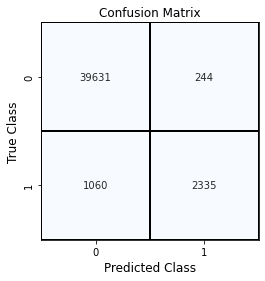

In [148]:
# plot confusion matrix
cm_RF = confusion_matrix(y_test, pred_rfc_grid)
plot_cm(cm_RF)

In [149]:
# calculate various scores
pd.DataFrame(
    {"Metric" : ["f1", "precision", "recall", "accuracy"], 
     "Score" : [f1_score(y_test, pred_rfc_grid), precision_score(y_test, pred_rfc_grid),recall_score(y_test, pred_rfc_grid), accuracy_score(y_test, pred_rfc_grid)]})
    

,Metric,Score
0,f1,0.781721
1,precision,0.905390
2,recall,0.687776
3,accuracy,0.969864


### Cut-off value

Cutoff = 0.0
Cutoff = 0.1
Cutoff = 0.2
Cutoff = 0.30000000000000004
Cutoff = 0.4
Cutoff = 0.5
Cutoff = 0.6000000000000001
Cutoff = 0.7000000000000001
Cutoff = 0.8
Cutoff = 0.9
Cutoff = 1.0


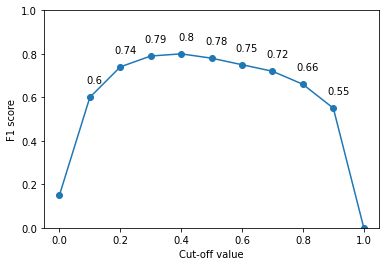

{0.0: 0.15,
 0.1: 0.6,
 0.2: 0.74,
 0.30000000000000004: 0.79,
 0.4: 0.8,
 0.5: 0.78,
 0.6000000000000001: 0.75,
 0.7000000000000001: 0.72,
 0.8: 0.66,
 0.9: 0.55,
 1.0: 0.0}

In [150]:
# plot f1 scores for various cut-off values
plot_cutoff_f1(rfc_grid.predict_proba(X_test_imp)[:,1], y_test, 0.2)

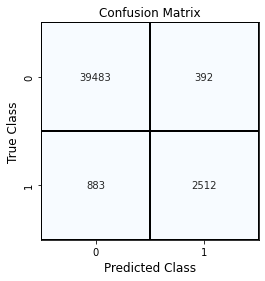

In [158]:
# plot confusion matrix for cut-off value of 0.4
plot_cm(confusion_matrix(y_test, 1*(rfc_grid.predict_proba(X_test_imp)[:,1] > 0.4)))

### Oversampling experiment

In [161]:
# use the same hyperparameter values from the complete gid search
rfc_experiment = RandomForestClassifier(
    n_estimators = grid_randomForest_GridSearch_bestParams["n_estimators"],
    criterion = grid_randomForest_GridSearch_bestParams["criterion"],
    max_depth = grid_randomForest_GridSearch_bestParams["max_depth"],
    bootstrap= grid_randomForest_GridSearch_bestParams['bootstrap'],
    class_weight = grid_randomForest_GridSearch_bestParams["class_weight"],
    max_features= grid_randomForest_GridSearch_bestParams["max_features"],
    random_state=100,
    n_jobs=-1
    )

# fit model
rfc_experiment = rfc_experiment.fit(X_train_imp_oversampled, y_train_oversampled)

######### pickle (to save time when reloading notebook again)
# with open('rfc_experiment_finalModel.pkl', 'wb') as f:
#      pickle.dump(rfc_experiment, f)
# with open('rfc_experiment_finalModel.pkl', 'rb') as f:
#     rfc_experiment = pickle.load(f)

# perform prediction
pred_rfc_experiment = rfc_experiment.predict(X_test_imp)

# print f1 score and confusion matrix
print(f1_score(y_test, pred_rfc_experiment))
confusion_matrix(y_test,pred_rfc_experiment)

0.7791524899474174


array([[39323,   552],
       [  876,  2519]])

Cutoff = 0.0
Cutoff = 0.1
Cutoff = 0.2
Cutoff = 0.30000000000000004
Cutoff = 0.4
Cutoff = 0.5
Cutoff = 0.6000000000000001
Cutoff = 0.7000000000000001
Cutoff = 0.8
Cutoff = 0.9
Cutoff = 1.0


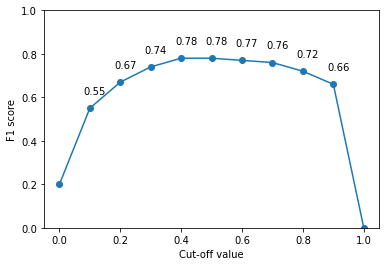

{0.0: 0.2,
 0.1: 0.55,
 0.2: 0.67,
 0.30000000000000004: 0.74,
 0.4: 0.78,
 0.5: 0.78,
 0.6000000000000001: 0.77,
 0.7000000000000001: 0.76,
 0.8: 0.72,
 0.9: 0.66,
 1.0: 0.0}

In [162]:
# plot f1 scores for various cut-off values for this experiment
plot_cutoff_f1(rfc_experiment.predict_proba(X_test_imp)[:,1], y_test, 0.2)

### Check how auto max_features performs

In [163]:
# use the same hyperparameter values from the complete gid search
rfc_experiment_maxFeat = RandomForestClassifier(
    n_estimators = grid_randomForest_GridSearch_bestParams["n_estimators"],
    criterion = grid_randomForest_GridSearch_bestParams["criterion"],
    max_depth = grid_randomForest_GridSearch_bestParams["max_depth"],
    bootstrap= False,
    class_weight = grid_randomForest_GridSearch_bestParams["class_weight"],
    max_features= 'auto',
    random_state=100,
    n_jobs=-1
    )
    
# fit model
rfc_experiment_maxFeat = rfc_experiment_maxFeat.fit(X_train_imp, y_train)

######### pickle (to save time when reloading notebook again)
# with open('rfc_experiment_maxFeat_finalModel.pkl', 'wb') as f:
#      pickle.dump(rfc_experiment_maxFeat, f)
# with open('rfc_experiment_maxFeat_finalModel.pkl', 'rb') as f:
#     rfc_experiment_maxFeat = pickle.load(f)

# perform prediction
pred_rfc_experiment_maxFeat = rfc_experiment_maxFeat.predict(X_test_imp)

# print f1-score and confusion matrx
print(f1_score(y_test, pred_rfc_experiment_maxFeat))
confusion_matrix(y_test,pred_rfc_experiment_maxFeat)

0.7645743766122097


array([[39678,   197],
       [ 1172,  2223]])

Cutoff = 0.0
Cutoff = 0.1
Cutoff = 0.2
Cutoff = 0.30000000000000004
Cutoff = 0.4
Cutoff = 0.5
Cutoff = 0.6000000000000001
Cutoff = 0.7000000000000001
Cutoff = 0.8
Cutoff = 0.9
Cutoff = 1.0


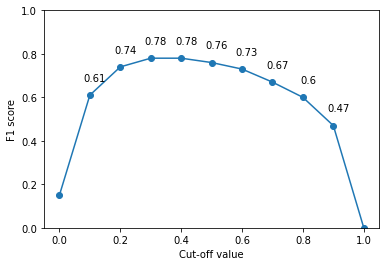

{0.0: 0.15,
 0.1: 0.61,
 0.2: 0.74,
 0.30000000000000004: 0.78,
 0.4: 0.78,
 0.5: 0.76,
 0.6000000000000001: 0.73,
 0.7000000000000001: 0.67,
 0.8: 0.6,
 0.9: 0.47,
 1.0: 0.0}

In [164]:
# plot f1 scores for various cut-off values for this experiment
plot_cutoff_f1(rfc_experiment_maxFeat.predict_proba(X_test_imp)[:,1], y_test, 0.2)

### Features importance

In [165]:
# storage for feature importances from the final rfc model
rfc_importances = pd.Series(rfc_grid.feature_importances_, index=rfc_grid.feature_names_in_)
importantFeatures = rfc_importances.sort_values(ascending=False)

In [166]:
# print most important values 
rfc_importances.sort_values(ascending=False).head(10)

C1                0.181645
C13               0.087062
V258              0.069297
C14               0.045459
id_02             0.036500
TransactionAmt    0.034367
V201              0.030716
card1             0.027952
id_20             0.021936
id_19             0.019145
dtype: float64

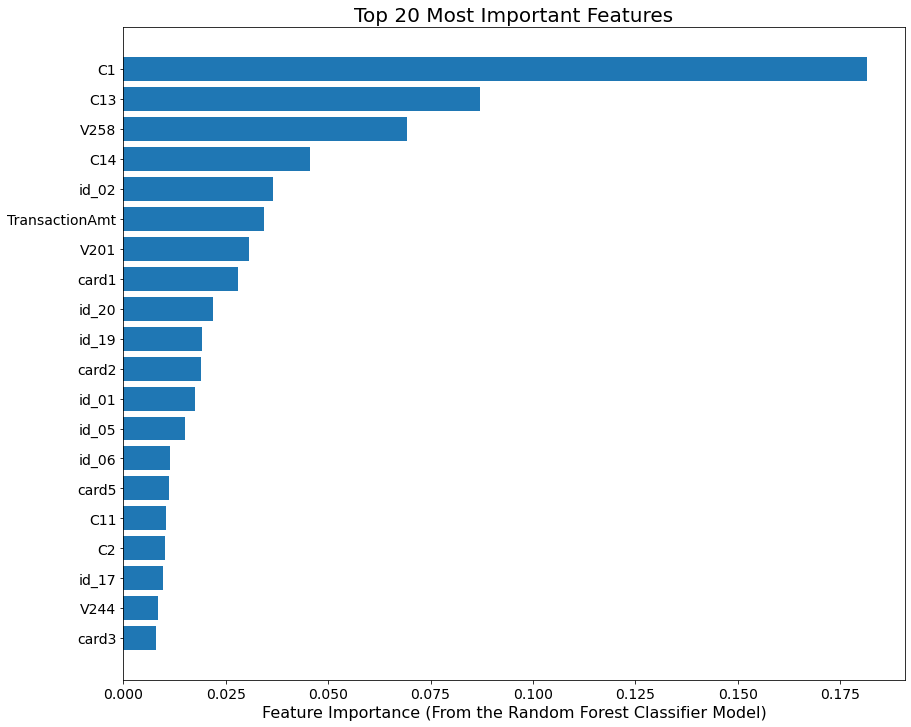

In [232]:
# plot bar chart with 20 most important featurs 
fig, ax = plt.subplots(figsize =(14, 12))
ax.barh(importantFeatures.head(20).index, importantFeatures.head(20).values)
ax.invert_yaxis()
ax.set_title("Top 20 Most Important Features", fontsize = 20)
ax.set_xlabel("Feature Importance (From the Random Forest Classifier Model)", fontsize=16)
ax.tick_params(axis='both', labelsize=14)
#plt.bar()
#plt.xticks(rotation = 90)

## KNN

### Scalling data

In [476]:
# binary columns
binary_cols = X_train_imp.nunique().sort_values()[X_train_imp.nunique().sort_values() == 2].index

# perform scalling for top 50, 100, 150, 200 most impoortant features and for all
X_train_imp_scaled50, X_test_imp_scaled50 = scale_data_new(X_train_imp[importantFeatures.head(50).index], X_test_imp[importantFeatures.head(50).index], binary_cols)
X_train_imp_scaled100, X_test_imp_scaled100 = scale_data_new(X_train_imp[importantFeatures.head(100).index], X_test_imp[importantFeatures.head(100).index], binary_cols)
X_train_imp_scaled150, X_test_imp_scaled150 = scale_data_new(X_train_imp[importantFeatures.head(150).index], X_test_imp[importantFeatures.head(150).index], binary_cols)
X_train_imp_scaled200, X_test_imp_scaled200 = scale_data_new(X_train_imp[importantFeatures.head(200).index], X_test_imp[importantFeatures.head(200).index], binary_cols)
X_train_imp_scaledALL, X_test_imp_scaledALL = scale_data_new(X_train_imp, X_test_imp, binary_cols)

### Grid search & feature importance

#### All features

In [425]:
# 5-fold cv
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=100)

# grid with hyperparameters to check
param_grid_KNN_GridSearch = {
    "n_neighbors" : [1,3,5],
    "weights" : ['uniform','distance']
}

# exhaustive grid search with f1 scoring metric
grid_KNN_GridSearch = GridSearchCV(KNeighborsClassifier(), param_grid_KNN_GridSearch, cv=cv, scoring='f1', verbose=1, n_jobs=-1)
grid_KNN_GridSearch.fit(X_train_imp_scaledALL, y_train)

# print best hyperparameter values and best f1-score  
print(grid_KNN_GridSearch.best_params_)
grid_KNN_GridSearch.best_score_

Fitting 5 folds for each of 6 candidates, totalling 30 fits
{'n_neighbors': 3, 'weights': 'distance'}


0.6362120772695937

In [430]:
######### save results as a pickle file 

# with open('grid_KNN_GridSearch_allFeatures_bestParams.pkl', 'wb') as f:
#     pickle.dump(grid_KNN_GridSearch.best_params_, f)
    
# with open('grid_KNN_GridSearch_allFeatures_bestF1score.pkl', 'wb') as f:
#     pickle.dump(grid_KNN_GridSearch.best_score_, f)
    
# with open('grid_KNN_GridSearch_allFeatures_cvResults.pkl', 'wb') as f:
#     pickle.dump(grid_KNN_GridSearch.cv_results_, f)

In [96]:
####### read pickle file with results 

with open('grid_KNN_GridSearch_allFeatures_bestParams.pkl', 'rb') as f:
    grid_KNN_GridSearch_allFeatures_bestParams = pickle.load(f)
    
with open('grid_KNN_GridSearch_allFeatures_bestF1score.pkl', 'rb') as f:
    grid_KNN_GridSearch_allFeatures_bestF1score = pickle.load(f)

with open('grid_KNN_GridSearch_allFeatures_cvResults.pkl', 'rb') as f:
    grid_KNN_GridSearch_allFeatures_cvResults = pickle.load(f)
    
print(grid_KNN_GridSearch_allFeatures_bestParams)
grid_KNN_GridSearch_allFeatures_bestF1score

{'n_neighbors': 3, 'weights': 'distance'}


0.6362120772695937

#### Important features

##### Top 50

In [436]:
# show top 50 important features
importantFeatures.head(50).index

Index(['C1', 'C13', 'V258', 'C14', 'id_02', 'TransactionAmt', 'V201', 'card1',
       'id_20', 'id_19', 'card2', 'id_01', 'id_05', 'id_06', 'card5', 'C11',
       'C2', 'id_17', 'V244', 'card3', 'C8', 'C10', 'C12',
       'R_emaildomain_gmail', 'V189', 'P_emaildomain_gmail',
       'P_emaildomain_anonymous', 'card6_credit', 'D1', 'C6', 'V261', 'V264',
       'V262', 'C4', 'R_emaildomain_anonymous', 'V187', 'V315', 'id_11',
       'V259', 'V203', 'DeviceType_mobile', 'V307', 'V198', 'C7',
       'ProductCD_H', 'id_31_firefox', 'id_15_New', 'V306', 'id_31_chrome',
       'V267'],
      dtype='object')

In [441]:
########### 50
%time

# 5-fold cv
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=100)

# grid with hyperparameters to check
param_grid_KNN_GridSearch50 = {
    "n_neighbors" : [1,3,5],
    "weights" : ['uniform','distance']
}

# exhaustive grid search with f1 scoring metric
grid_KNN_GridSearch50 = GridSearchCV(KNeighborsClassifier(), param_grid_KNN_GridSearch50, cv=cv, scoring='f1', verbose=1, n_jobs=-1)
grid_KNN_GridSearch50.fit(X_train_imp_scaled50, y_train);

# print best hyperparameter values and best f1-score  
print(grid_KNN_GridSearch50.best_params_)
grid_KNN_GridSearch50.best_score_

CPU times: user 2 µs, sys: 2 µs, total: 4 µs
Wall time: 6.91 µs
Fitting 5 folds for each of 6 candidates, totalling 30 fits
CPU times: user 122 ms, sys: 268 ms, total: 391 ms
Wall time: 3min 12s
{'n_neighbors': 3, 'weights': 'distance'}


0.6432204062535027

In [444]:
######### save results as a pickle file 

# with open('grid_KNN_GridSearch_50Features_bestParams.pkl', 'wb') as f:
#     pickle.dump(grid_KNN_GridSearch50.best_params_, f)
    
# with open('grid_KNN_GridSearch_50Features_bestF1score.pkl', 'wb') as f:
#     pickle.dump(grid_KNN_GridSearch50.best_score_, f)
    
# with open('grid_KNN_GridSearch_50Features_cvResults.pkl', 'wb') as f:
#     pickle.dump(grid_KNN_GridSearch50.cv_results_, f)

In [97]:
####### read pickle file with results 

with open('grid_KNN_GridSearch_50Features_bestParams.pkl', 'rb') as f:
    grid_KNN_GridSearch_50Features_bestParams = pickle.load(f)
    
with open('grid_KNN_GridSearch_50Features_bestF1score.pkl', 'rb') as f:
    grid_KNN_GridSearch_50Features_bestF1score = pickle.load(f)
    
with open('grid_KNN_GridSearch_50Features_cvResults.pkl', 'rb') as f:
    grid_KNN_GridSearch_50Features_cvResults = pickle.load(f)    
    
print(grid_KNN_GridSearch_50Features_bestParams)
grid_KNN_GridSearch_50Features_bestF1score

{'n_neighbors': 3, 'weights': 'distance'}


0.6432204062535027

##### Top 100

In [447]:
# show top 100 important features
importantFeatures.head(100).index

Index(['C1', 'C13', 'V258', 'C14', 'id_02', 'TransactionAmt', 'V201', 'card1',
       'id_20', 'id_19', 'card2', 'id_01', 'id_05', 'id_06', 'card5', 'C11',
       'C2', 'id_17', 'V244', 'card3', 'C8', 'C10', 'C12',
       'R_emaildomain_gmail', 'V189', 'P_emaildomain_gmail',
       'P_emaildomain_anonymous', 'card6_credit', 'D1', 'C6', 'V261', 'V264',
       'V262', 'C4', 'R_emaildomain_anonymous', 'V187', 'V315', 'id_11',
       'V259', 'V203', 'DeviceType_mobile', 'V307', 'V198', 'C7',
       'ProductCD_H', 'id_31_firefox', 'id_15_New', 'V306', 'id_31_chrome',
       'V267', 'V265', 'DeviceType_desktop', 'V207', 'P_emaildomain_hotmail',
       'V204', 'V257', 'V274', 'R_emaildomain_hotmail', 'V251', 'V209', 'V234',
       'V263', 'id_31_other', 'card4_mastercard', 'id_31_safari', 'V283',
       'V222', 'V256', 'V210', 'id_38_F', 'V308', 'V208', 'card4_visa', 'V260',
       'V245', 'V170', 'V130', 'V275', 'id_38_T', 'V221', 'V202', 'V282',
       'R_emaildomain_yahoo', 'V178', 'V277',

In [450]:
# 100
%time

# 5-fold cv
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=100)

# grid with hyperparameters to check
param_grid_KNN_GridSearch100 = {
    "n_neighbors" : [1,3,5],
    "weights" : ['uniform','distance']
}


# exhaustive grid search with f1 scoring metric
grid_KNN_GridSearch100 = GridSearchCV(KNeighborsClassifier(), param_grid_KNN_GridSearch100, cv=cv, scoring='f1', verbose=1, n_jobs=-1)
grid_KNN_GridSearch100.fit(X_train_imp_scaled100, y_train)

# print best hyperparameter values and best f1-score  
print(grid_KNN_GridSearch100.best_params_)
grid_KNN_GridSearch100.best_score_

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 7.15 µs
Fitting 5 folds for each of 6 candidates, totalling 30 fits
CPU times: user 145 ms, sys: 353 ms, total: 498 ms
Wall time: 6min 27s
{'n_neighbors': 3, 'weights': 'distance'}


0.6508047838245457

In [453]:
######### save results as a pickle file 

# with open('grid_KNN_GridSearch_100Features_bestParams.pkl', 'wb') as f:
#     pickle.dump(grid_KNN_GridSearch100.best_params_, f)
    
# with open('grid_KNN_GridSearch_100Features_bestF1score.pkl', 'wb') as f:
#     pickle.dump(grid_KNN_GridSearch100.best_score_, f)

# with open('grid_KNN_GridSearch_100Features_cvResults.pkl', 'wb') as f:
#     pickle.dump(grid_KNN_GridSearch100.cv_results_, f)

In [98]:
####### read pickle file with results 

with open('grid_KNN_GridSearch_100Features_bestParams.pkl', 'rb') as f:
    grid_KNN_GridSearch_100Features_bestParams = pickle.load(f)
    
with open('grid_KNN_GridSearch_100Features_bestF1score.pkl', 'rb') as f:
    grid_KNN_GridSearch_100Features_bestF1score = pickle.load(f)

with open('grid_KNN_GridSearch_100Features_cvResults.pkl', 'rb') as f:
    grid_KNN_GridSearch_100Features_cvResults = pickle.load(f)

print(grid_KNN_GridSearch_100Features_bestParams)
grid_KNN_GridSearch_100Features_bestF1score

{'n_neighbors': 3, 'weights': 'distance'}


0.6508047838245457

##### Top 150

In [458]:
#150
%time

# 5-fold cv
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=100)

# grid with hyperparameters to check
param_grid_KNN_GridSearch150 = {
    "n_neighbors" : [1,3,5],
    "weights" : ['uniform','distance']
}


# exhaustive grid search with f1 scoring metric
grid_KNN_GridSearch150 = GridSearchCV(KNeighborsClassifier(), param_grid_KNN_GridSearch150, cv=cv, scoring='f1', verbose=1, n_jobs=-1)
grid_KNN_GridSearch150.fit(X_train_imp_scaled150, y_train)

# print best hyperparameter values and best f1-score  
print(grid_KNN_GridSearch150.best_params_)
grid_KNN_GridSearch150.best_score_

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 6.91 µs
Fitting 5 folds for each of 6 candidates, totalling 30 fits
CPU times: user 155 ms, sys: 402 ms, total: 558 ms
Wall time: 6min 51s
{'n_neighbors': 3, 'weights': 'distance'}


0.655764273509588

In [464]:
######### save results as a pickle file 

# with open('grid_KNN_GridSearch_150Features_bestParams.pkl', 'wb') as f:
#     pickle.dump(grid_KNN_GridSearch150.best_params_, f)
    
# with open('grid_KNN_GridSearch_150Features_bestF1score.pkl', 'wb') as f:
#     pickle.dump(grid_KNN_GridSearch150.best_score_, f)

# with open('grid_KNN_GridSearch_150Features_cvResults.pkl', 'wb') as f:
#     pickle.dump(grid_KNN_GridSearch150.cv_results_, f)

In [99]:
####### read pickle file with results 

with open('grid_KNN_GridSearch_150Features_bestParams.pkl', 'rb') as f:
    grid_KNN_GridSearch_150Features_bestParams = pickle.load(f)
    
with open('grid_KNN_GridSearch_150Features_bestF1score.pkl', 'rb') as f:
    grid_KNN_GridSearch_150Features_bestF1score = pickle.load(f)
    
with open('grid_KNN_GridSearch_150Features_cvResults.pkl', 'rb') as f:
    grid_KNN_GridSearch_150Features_cvResults = pickle.load(f)
    
print(grid_KNN_GridSearch_150Features_bestParams)
grid_KNN_GridSearch_150Features_bestF1score

{'n_neighbors': 3, 'weights': 'distance'}


0.655764273509588

##### Top 200

In [459]:
# 200
%time

# 5-fold cv
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=100)

# grid with hyperparameters to check
param_grid_KNN_GridSearch200 = {
    "n_neighbors" : [1,3,5],
    "weights" : ['uniform','distance']
}

# exhaustive grid search with f1 scoring metric
grid_KNN_GridSearch200 = GridSearchCV(KNeighborsClassifier(), param_grid_KNN_GridSearch200, cv=cv, scoring='f1', verbose=1, n_jobs=-1)
grid_KNN_GridSearch200.fit(X_train_imp_scaled200, y_train)

# print best hyperparameter values and best f1-score  
print(grid_KNN_GridSearch200.best_params_)
grid_KNN_GridSearch200.best_score_

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 5.01 µs
Fitting 5 folds for each of 6 candidates, totalling 30 fits
CPU times: user 159 ms, sys: 379 ms, total: 537 ms
Wall time: 13min 9s
{'n_neighbors': 3, 'weights': 'distance'}


0.6458720670918227

In [469]:
######### save results as a pickle file 

# with open('grid_KNN_GridSearch_200Features_bestParams.pkl', 'wb') as f:
#     pickle.dump(grid_KNN_GridSearch200.best_params_, f)
    
# with open('grid_KNN_GridSearch_200Features_bestF1score.pkl', 'wb') as f:
#     pickle.dump(grid_KNN_GridSearch200.best_score_, f)

# with open('grid_KNN_GridSearch_200Features_cvResults.pkl', 'wb') as f:
#     pickle.dump(grid_KNN_GridSearch200.cv_results_, f)

In [100]:
####### read pickle file with results 

with open('grid_KNN_GridSearch_200Features_bestParams.pkl', 'rb') as f:
    grid_KNN_GridSearch_200Features_bestParams = pickle.load(f)
    
with open('grid_KNN_GridSearch_200Features_bestF1score.pkl', 'rb') as f:
    grid_KNN_GridSearch_200Features_bestF1score = pickle.load(f)
    
with open('grid_KNN_GridSearch_200Features_cvResults.pkl', 'rb') as f:
    grid_KNN_GridSearch_200Features_cv_results= pickle.load(f)
    
print(grid_KNN_GridSearch_200Features_bestParams)
grid_KNN_GridSearch_200Features_bestF1score

{'n_neighbors': 3, 'weights': 'distance'}


0.6458720670918227

### Fit and predict

In [478]:
# 150

# best hyperparameter values from Grid Search 
knn_finalModel150 = KNeighborsClassifier(
    n_neighbors = grid_KNN_GridSearch_150Features_bestParams['n_neighbors'],
    weights= grid_KNN_GridSearch_150Features_bestParams['weights'],
    )

# fit model
knn_finalModel150 = knn_finalModel150.fit(X_train_imp_scaled150, y_train)

######### pickle (to save time when reloading notebook again)
# with open('knn_finalModel150.pkl', 'wb') as f:
#      pickle.dump(knn_finalModel150, f)
# with open('knn_finalModel150.pkl', 'rb') as f:
#     knn_finalModel150 = pickle.load(f)

# perform prediction
pred_knn_finalModel150 = knn_finalModel150.predict(X_test_imp_scaled150)

# print f1 score and show confusion matrix 
print(f1_score(y_test, pred_knn_finalModel150))
confusion_matrix(y_test, pred_knn_finalModel150)

0.6766735679779158


array([[39435,   440],
       [ 1434,  1961]])

In [481]:
# cv results show that achieving such high score is definitely possible (in some of the validations)
grid_KNN_GridSearch_150Features_cvResults

{'mean_fit_time': array([0.15390906, 0.16036119, 0.15847926, 0.42073207, 0.16619225,
        0.32450223]),
 'std_fit_time': array([0.02426015, 0.01732299, 0.12233695, 0.25586567, 0.05078299,
        0.18630427]),
 'mean_score_time': array([ 77.57692137,  76.06748071,  91.49624639,  91.30210223,
        239.97146859, 236.7872561 ]),
 'std_score_time': array([2.1251067 , 4.02292372, 0.76295288, 1.76451685, 0.27571822,
        2.67933231]),
 'param_n_neighbors': masked_array(data=[1, 1, 3, 3, 5, 5],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_weights': masked_array(data=['uniform', 'distance', 'uniform', 'distance',
                    'uniform', 'distance'],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'n_neighbors': 1, 'weights': 'uniform'},
  {'n_neighbors': 1, 'weights': 'distance'},
  {'n_neighbors': 3, 'weights': 'uniform'}

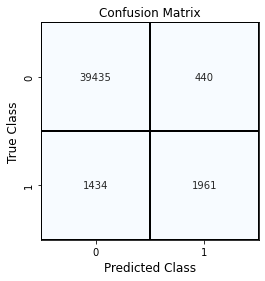

In [484]:
# show confusion matrix
plot_cm(confusion_matrix(y_test, pred_knn_finalModel150))

In [482]:
# show scores 
pd.DataFrame(
    {"Metric" : ["f1", "precision", "recall", "accuracy"], "Score" : [f1_score(y_test, pred_knn_finalModel150), precision_score(y_test, pred_knn_finalModel150),recall_score(y_test, pred_knn_finalModel150), accuracy_score(y_test, pred_knn_finalModel150)]})


,Metric,Score
0,f1,0.676674
1,precision,0.816743
2,recall,0.577614
3,accuracy,0.956691


### Cutoff

Cutoff = 0.0
Cutoff = 0.1
Cutoff = 0.2
Cutoff = 0.30000000000000004
Cutoff = 0.4
Cutoff = 0.5
Cutoff = 0.6000000000000001
Cutoff = 0.7000000000000001
Cutoff = 0.8
Cutoff = 0.9
Cutoff = 1.0


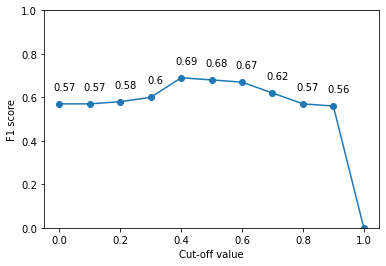

{0.0: 0.57,
 0.1: 0.57,
 0.2: 0.58,
 0.30000000000000004: 0.6,
 0.4: 0.69,
 0.5: 0.68,
 0.6000000000000001: 0.67,
 0.7000000000000001: 0.62,
 0.8: 0.57,
 0.9: 0.56,
 1.0: 0.0}

In [490]:
# see how f1 score changes as a result of varying cut-off value
plot_cutoff_f1(knn_finalModel150.predict_proba(X_test_imp_scaled150)[:,1] , y_test, 0)

## Logistic regression

### No resampling & scaling
- standardization due to the presence of penalty

#### Randomized Search

In [495]:
# 5-fold cv
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=100)

# hyperparameter values for the randomised grid search
param_grid_logReg_randomized_all= {
    "solver" : [ "saga"],
    "C" : np.logspace(0, 4, 20),
    "class_weight" : [{0:1, 1:1},{0:1, 1:3}, {0:1, 1:6}, {0:1, 1:10}, {0:1, 1:15}, "balanced"],
    "penalty" : ['l1', 'l2',  'none'],
    "random_state" : [100],
    "max_iter" : [1000]
    
}

# randomised grid search
grid_logReg_randomized_all = RandomizedSearchCV(LogisticRegression(), param_grid_logReg_randomized_all, cv=cv, scoring='f1', verbose=1, n_jobs=-1, random_state=100, n_iter=50)
grid_logReg_randomized_all.fit(X_train_imp_scaledALL, y_train);

# print best hyperparameters and f1 score value
grid_logReg_randomized_all.best_params_
grid_logReg_randomized_all.best_score_

Fitting 5 folds for each of 50 candidates, totalling 250 fits


/Users/smiller/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/smiller/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/smiller/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/smiller/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/smiller/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/smiller/opt/anaconda3/lib/python3

0.5576984881165

In [504]:
######### save results as a pickle file 

# with open('grid_logReg_randomized_all_bestParams.pkl', 'wb') as f:
#     pickle.dump(grid_logReg_randomized_all.best_params_, f)
# with open('grid_logReg_randomized_all_bestScore.pkl', 'wb') as f:
#     pickle.dump(grid_logReg_randomized_all.best_score_, f)
# with open('grid_logReg_randomized_all_cvResults.pkl', 'wb') as f:
#     pickle.dump(grid_logReg_randomized_all.cv_results_, f)

In [101]:
####### read pickle file with results 

with open('grid_logReg_randomized_all_bestParams.pkl', 'rb') as f:
    grid_logReg_randomized_all_bestParams = pickle.load(f)
with open('grid_logReg_randomized_all_bestScore.pkl', 'rb') as f:
    grid_logReg_randomized_all_bestF1score = pickle.load(f)
with open('grid_logReg_randomized_all_cvResults.pkl', 'rb') as f:
    grid_logReg_randomized_all_cvResults = pickle.load(f)
    
print(grid_logReg_randomized_all_bestParams)
print(grid_logReg_randomized_all_bestF1score)

{'solver': 'saga', 'random_state': 100, 'penalty': 'l1', 'max_iter': 1000, 'class_weight': {0: 1, 1: 3}, 'C': 6158.48211066026}
0.5576984881165


#### Fit and predict

In [505]:
# hyperparameter values from randomised search
logreg_randomized_all = LogisticRegression(
    solver = "saga",
    C = grid_logReg_randomized_all_bestParams['C'],
    penalty = grid_logReg_randomized_all_bestParams['penalty'],
    class_weight = grid_logReg_randomized_all_bestParams['class_weight'],
    random_state = 100,
    max_iter=1000
)

# fit model
logreg_randomized_all = logreg_randomized_all.fit(X_train_imp_scaledALL, y_train)

######### pickle (to save time when reloading notebook again)
# with open('logreg_randomized_all_finalModel.pkl', 'wb') as f:
#     pickle.dump(logreg_randomized_all, f)
# with open('logreg_randomized_all_finalModel.pkl', 'rb') as f:
#     logreg_randomized_all = pickle.load(f)

# perform prediction
pred_logreg_randomized_all= logreg_randomized_all.predict(X_test_imp_scaledALL)

# show confusion matrix and f1 score value
confusion_matrix(y_test, pred_logreg_randomized_all)
f1_score(y_test, pred_logreg_randomized_all)

0.5623268698060943

In [523]:
# show scoring metrics
pd.DataFrame(
    {"Metric" : ["f1", "precision", "recall", "accuracy"], "Score" : [f1_score(y_test, pred_logreg_randomized_all), precision_score(y_test, pred_logreg_randomized_all),recall_score(y_test, pred_logreg_randomized_all), accuracy_score(y_test, pred_logreg_randomized_all)]})


,Metric,Score
0,f1,0.562327
1,precision,0.682066
2,recall,0.478351
3,accuracy,0.941576


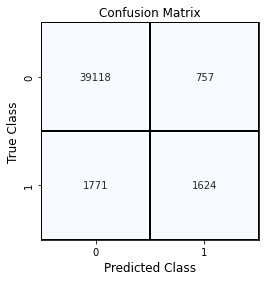

In [524]:
# show confusion matrix 
plot_cm(confusion_matrix(y_test, pred_logreg_randomized_all))

Cutoff = 0.0
Cutoff = 0.1
Cutoff = 0.2
Cutoff = 0.30000000000000004
Cutoff = 0.4
Cutoff = 0.5
Cutoff = 0.6000000000000001
Cutoff = 0.7000000000000001
Cutoff = 0.8
Cutoff = 0.9
Cutoff = 1.0


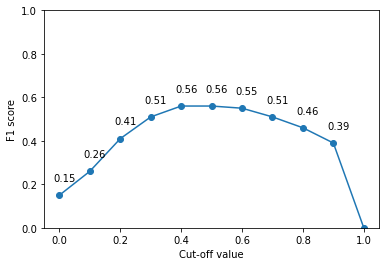

{0.0: 0.15,
 0.1: 0.26,
 0.2: 0.41,
 0.30000000000000004: 0.51,
 0.4: 0.56,
 0.5: 0.56,
 0.6000000000000001: 0.55,
 0.7000000000000001: 0.51,
 0.8: 0.46,
 0.9: 0.39,
 1.0: 0.0}

In [525]:
# plot f1 score for various cut-off values
plot_cutoff_f1(logreg_randomized_all.predict_proba(X_test_imp_scaledALL)[:,1],y_test,0)

### Selecting top 150 features

In [526]:
# 5-fold cv
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=100)

# grid with hyperparameter candidate values
param_grid_logReg_randomized_150= {
    "solver" : [ "saga"],
    "C" : np.logspace(0, 4, 20),
    "class_weight" : [{0:1, 1:1},{0:1, 1:3}, {0:1, 1:6}, {0:1, 1:10}, {0:1, 1:15}, "balanced"],
    "penalty" : ['l1', 'l2',  'none'],
    "random_state" : [100],
    "max_iter" : [1000]
    
}
    
# perform randomised grid search    
grid_logReg_randomized_150 = RandomizedSearchCV(LogisticRegression(), param_grid_logReg_randomized_150, cv=cv, scoring='f1', verbose=3, n_jobs=-1, random_state=100, n_iter=10)
grid_logReg_randomized_150.fit(X_train_imp_scaled150, y_train)

# show best hyperparameter values and 
grid_logReg_randomized_150.best_params_
grid_logReg_randomized_150.best_score_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


/Users/smiller/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/smiller/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/smiller/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/smiller/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/smiller/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/smiller/opt/anaconda3/lib/python3

0.5472082152248571

[CV 2/5] END C=6.951927961775605, class_weight={0: 1, 1: 3}, max_iter=1000, penalty=l1, random_state=100, solver=saga;, score=0.548 total time= 1.4min
[CV 3/5] END C=6.951927961775605, class_weight=balanced, max_iter=1000, penalty=l2, random_state=100, solver=saga;, score=0.430 total time=  40.8s
[CV 5/5] END C=48.32930238571752, class_weight={0: 1, 1: 6}, max_iter=1000, penalty=none, random_state=100, solver=saga;, score=0.518 total time=  46.9s
[CV 3/5] END C=335.9818286283781, class_weight={0: 1, 1: 10}, max_iter=1000, penalty=none, random_state=100, solver=saga;, score=0.457 total time=  53.3s
[CV 3/5] END C=1.0, class_weight={0: 1, 1: 1}, max_iter=1000, penalty=l2, random_state=100, solver=saga;, score=0.472 total time= 1.0min
[CV 3/5] END C=6.951927961775605, class_weight={0: 1, 1: 3}, max_iter=1000, penalty=l1, random_state=100, solver=saga;, score=0.545 total time= 1.1min
[CV 3/5] END C=6158.48211066026, class_weight=balanced, max_iter=1000, penalty=l1, random_state=100, solver

In [527]:
######### save results as a pickle file 

# with open('grid_logReg_randomized_150_bestParams.pkl', 'wb') as f:
#     pickle.dump(grid_logReg_randomized_150.best_params_, f)
# with open('grid_logReg_randomized_150_bestScore.pkl', 'wb') as f:
#     pickle.dump(grid_logReg_randomized_150.best_score_, f)
# with open('grid_logReg_randomized_150_cvResults.pkl', 'wb') as f:
#     pickle.dump(grid_logReg_randomized_150.cv_results_, f)

In [103]:
####### read pickle file with results 

with open('grid_logReg_randomized_150_bestParams.pkl', 'rb') as f:
    grid_logReg_randomized_150_bestParams = pickle.load(f)
with open('grid_logReg_randomized_150_bestScore.pkl', 'rb') as f:
    grid_logReg_randomized_150_bestScore = pickle.load(f)
with open('grid_logReg_randomized_150_cvResults.pkl', 'rb') as f:
    grid_logReg_randomized_150_cvResults = pickle.load(f)
    
    
print(grid_logReg_randomized_150_bestParams)
print(grid_logReg_randomized_150_bestScore)

{'solver': 'saga', 'random_state': 100, 'penalty': 'l1', 'max_iter': 1000, 'class_weight': {0: 1, 1: 3}, 'C': 6.951927961775605}
0.5472082152248571


## XGB 

In [546]:
dtrain_all = xgb.DMatrix(X_train_imp_scaledALL, y_train)
dtest_all= xgb.DMatrix(X_test_imp_scaledALL, y_test)

### Randomised search

#### 1st attempt

In [541]:
# source: https://www.mikulskibartosz.name/xgboost-hyperparameter-tuning-in-python-using-grid-search/
# source: https://towardsdatascience.com/xgboost-fine-tune-and-optimize-your-model-23d996fab663

# grid with hyperparameter values
param_grid_xgboost_randomized = {
    'max_depth': range (2, 10, 1),
    'n_estimators': [50,75,100,125],
     'colsample_bytree': [0.5, 0.75, 1],
    'learning_rate': [0.1, 0.01, 0.05],
    'alpha' : [1,10,100,1000],
    'random_state': [100],
    'scale_pos_weight': [1,6,11]

}

# fit XGBoost instance
estimator = xgb.XGBClassifier(
    objective= 'binary:logistic',
    nthread=4,
    seed=100
)

# randomised grid search with f1 scoring metric
grid_xgboost_randomized = RandomizedSearchCV(estimator=estimator, param_distributions=param_grid_xgboost_randomized, cv=5, scoring='f1', verbose=3, random_state=100)

# fit model
grid_xgboost_randomized.fit(X_train_imp_scaledALL, y_train);

# print best parameters
grid_xgboost_randomized.best_params_

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END alpha=10, colsample_bytree=1, learning_rate=0.01, max_depth=2, n_estimators=100, random_state=100, scale_pos_weight=11;, score=0.393 total time=   9.4s
[CV 2/5] END alpha=10, colsample_bytree=1, learning_rate=0.01, max_depth=2, n_estimators=100, random_state=100, scale_pos_weight=11;, score=0.379 total time=   9.2s
[CV 3/5] END alpha=10, colsample_bytree=1, learning_rate=0.01, max_depth=2, n_estimators=100, random_state=100, scale_pos_weight=11;, score=0.381 total time=   9.5s
[CV 4/5] END alpha=10, colsample_bytree=1, learning_rate=0.01, max_depth=2, n_estimators=100, random_state=100, scale_pos_weight=11;, score=0.389 total time=   9.2s
[CV 5/5] END alpha=10, colsample_bytree=1, learning_rate=0.01, max_depth=2, n_estimators=100, random_state=100, scale_pos_weight=11;, score=0.398 total time=   9.1s
[CV 1/5] END alpha=1000, colsample_bytree=0.5, learning_rate=0.05, max_depth=6, n_estimators=100, random_state=100

{'scale_pos_weight': 6,
 'random_state': 100,
 'n_estimators': 100,
 'max_depth': 8,
 'learning_rate': 0.1,
 'colsample_bytree': 0.5,
 'alpha': 1}

In [543]:
# print best score
grid_xgboost_randomized.best_score_

0.7689384056204633

In [553]:
# with open('grid_xgboost_randomized_initial_bestParams.pkl', 'wb') as f:
#     pickle.dump(grid_xgboost_randomized.best_params_, f)
# with open('grid_xgboost_randomized_initial_bestScore.pkl', 'wb') as f:
#     pickle.dump(grid_xgboost_randomized.best_score_, f)
# with open('grid_xgboost_randomized_initial_cvResults.pkl', 'wb') as f:
#     pickle.dump(grid_xgboost_randomized.cv_results_, f)

In [104]:
with open('grid_xgboost_randomized_initial_bestParams.pkl', 'rb') as f:
    grid_xgboost_randomized_initial_bestParams = pickle.load(f)
with open('grid_xgboost_randomized_initial_bestScore.pkl', 'rb') as f:
    grid_xgboost_randomized_initial_bestScore = pickle.load(f)
with open('grid_xgboost_randomized_initial_cvResults.pkl', 'rb') as f:
    grid_xgboost_randomized_initial_cvResults = pickle.load(f)
    
print(grid_xgboost_randomized_initial_bestParams)
print(grid_xgboost_randomized_initial_bestScore)

{'scale_pos_weight': 6, 'random_state': 100, 'n_estimators': 100, 'max_depth': 8, 'learning_rate': 0.1, 'colsample_bytree': 0.5, 'alpha': 1}
0.7689384056204633


#### 2nd attempt

In [562]:
################# refined grid based on previous
#https://www.mikulskibartosz.name/xgboost-hyperparameter-tuning-in-python-using-grid-search/
#https://towardsdatascience.com/xgboost-fine-tune-and-optimize-your-model-23d996fab663

param_grid_xgboost_randomized_2 = {
    'max_depth': range (5, 10, 1),
    'n_estimators': [75,100,125],
     'colsample_bytree': [0.25, 0.5, 0.75],
    'learning_rate': [0.1, 0.2, 0.05],
    'alpha' : [0, 0.1,1,10],
    'random_state': [100],
     'scale_pos_weight': [1,6,11]

}

# 5-fold cv
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=100)

# fit xgb instance
estimator = xgb.XGBClassifier(
    objective= 'binary:logistic',
    nthread=4,
    seed=100
)

# randomised search
grid_xgboost_randomized_2 = RandomizedSearchCV(estimator=estimator, param_distributions=param_grid_xgboost_randomized_2, cv=cv, scoring='f1', verbose=3, random_state=100, n_iter=100)

# fit model
grid_xgboost_randomized_2.fit(X_train_imp_scaledALL, y_train);

# best params
print(grid_xgboost_randomized_2.best_params_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV 1/5] END alpha=1, colsample_bytree=0.25, learning_rate=0.2, max_depth=5, n_estimators=125, random_state=100, scale_pos_weight=11;, score=0.682 total time=   8.5s
[CV 2/5] END alpha=1, colsample_bytree=0.25, learning_rate=0.2, max_depth=5, n_estimators=125, random_state=100, scale_pos_weight=11;, score=0.680 total time=   8.5s
[CV 3/5] END alpha=1, colsample_bytree=0.25, learning_rate=0.2, max_depth=5, n_estimators=125, random_state=100, scale_pos_weight=11;, score=0.672 total time=   8.3s
[CV 4/5] END alpha=1, colsample_bytree=0.25, learning_rate=0.2, max_depth=5, n_estimators=125, random_state=100, scale_pos_weight=11;, score=0.682 total time=   8.7s
[CV 5/5] END alpha=1, colsample_bytree=0.25, learning_rate=0.2, max_depth=5, n_estimators=125, random_state=100, scale_pos_weight=11;, score=0.680 total time=   8.6s
[CV 1/5] END alpha=0.1, colsample_bytree=0.75, learning_rate=0.1, max_depth=7, n_estimators=75, random_stat

{'scale_pos_weight': 6,
 'random_state': 100,
 'n_estimators': 125,
 'max_depth': 9,
 'learning_rate': 0.2,
 'colsample_bytree': 0.5,
 'alpha': 0}

In [575]:
# best score
grid_xgboost_randomized_2.best_score_

0.8031657790982539

In [564]:
# with open('grid_xgboost_randomized_2_bestParams.pkl', 'wb') as f:
#     pickle.dump(grid_xgboost_randomized_2.best_params_, f)
# with open('grid_xgboost_randomized_2_bestScore.pkl', 'wb') as f:
#     pickle.dump(grid_xgboost_randomized_2.best_score_, f)
# with open('grid_xgboost_randomized_2_cvResults.pkl', 'wb') as f:
#     pickle.dump(grid_xgboost_randomized_2.cv_results_, f)

In [105]:
with open('grid_xgboost_randomized_2_bestParams.pkl', 'rb') as f:
    grid_xgboost_randomized_2_bestParams = pickle.load(f)
with open('grid_xgboost_randomized_2_bestScore.pkl', 'rb') as f:
    grid_xgboost_randomized_2_bestScore = pickle.load(f)
with open('grid_xgboost_randomized_2_cvResults.pkl', 'rb') as f:
    grid_xgboost_randomized_2_cvResults = pickle.load(f)
    
print(grid_xgboost_randomized_2_bestParams)
print(grid_xgboost_randomized_2_bestScore)

{'scale_pos_weight': 6, 'random_state': 100, 'n_estimators': 125, 'max_depth': 9, 'learning_rate': 0.2, 'colsample_bytree': 0.5, 'alpha': 0}
0.8031657790982539


### Fit and predict

In [735]:
# best hyperparameter values from the randomized search (among tested)
clf_xgb = xgb.XGBClassifier(
    objective = 'binary:logistic',
    nthread = 4,
    seed = 100,
    random_state = 100,
    scale_pos_weight = grid_xgboost_randomized_2_bestParams['scale_pos_weight'],
    n_estimators = grid_xgboost_randomized_2_bestParams['n_estimators'],
    max_depth = grid_xgboost_randomized_2_bestParams['max_depth'],
    learning_rate = 0grid_xgboost_randomized_2_bestParams['learning_rate'],
    colsample_bytree = grid_xgboost_randomized_2_bestParams['colsample_bytree'],
    alpha = grid_xgboost_randomized_2_bestParams['alpha'])

# fit model
clf_xgb.fit(X_train_imp_scaledALL, y_train)

######### pickle (to save time when reloading notebook again)
# with open('xgb_randomized_all_finalModel.pkl', 'wb') as f:
#     pickle.dump(clf_xgb, f)
# with open('xgb_randomized_all_finalModel.pkl', 'rb') as f:
#    clf_xgb = pickle.load(f)

# perform prediction
pred_xgb = clf_xgb.predict(X_test_imp_scaledALL)

# show confusion matrix and f1 score
display(confusion_matrix(y_test, pred_xgb))
f1_score(y_test, pred_xgb)

array([[39295,   580],
       [  645,  2750]])

0.8178438661710038

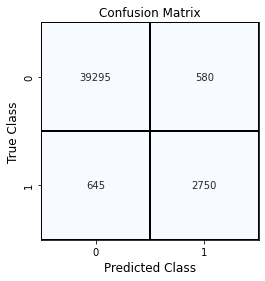

In [738]:
# show confusion matrix
plot_cm(confusion_matrix(y_test, pred_xgb))

In [737]:
# show scores
pd.DataFrame(
    {"Metric" : ["f1", "precision", "recall", "accuracy"], "Score" : [f1_score(y_test, pred_xgb), precision_score(y_test, pred_xgb),recall_score(y_test, pred_xgb), accuracy_score(y_test, pred_xgb)]})


,Metric,Score
0,f1,0.817844
1,precision,0.825826
2,recall,0.810015
3,accuracy,0.971689


### Cutoff

Cutoff = 0.0
Cutoff = 0.1
Cutoff = 0.2
Cutoff = 0.30000000000000004
Cutoff = 0.4
Cutoff = 0.5
Cutoff = 0.6000000000000001
Cutoff = 0.7000000000000001
Cutoff = 0.8
Cutoff = 0.9
Cutoff = 1.0


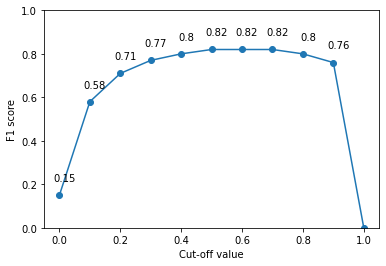

{0.0: 0.15,
 0.1: 0.58,
 0.2: 0.71,
 0.30000000000000004: 0.77,
 0.4: 0.8,
 0.5: 0.82,
 0.6000000000000001: 0.82,
 0.7000000000000001: 0.82,
 0.8: 0.8,
 0.9: 0.76,
 1.0: 0.0}

In [739]:
# calculate f1 score for various cut-off values
plot_cutoff_f1(clf_xgb.predict_proba(X_test_imp_scaledALL)[:,1],y_test,0)

In [574]:
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=100)

estimator = xgb.XGBClassifier(
    objective= 'binary:logistic',
    nthread=4,
    seed=100
)


grid_xgboost_randomized_100 = RandomizedSearchCV(estimator=estimator, param_distributions=param_grid_xgboost_randomized_2, cv=cv, scoring='f1', verbose=3, random_state=100, n_iter=10)

grid_xgboost_randomized_100.fit(X_train_imp_scaled100, y_train);

grid_xgboost_randomized_100.best_params_


Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END alpha=10, colsample_bytree=0.75, learning_rate=0.2, max_depth=6, n_estimators=100, random_state=100, scale_pos_weight=11;, score=0.708 total time=   7.9s
[CV 2/5] END alpha=10, colsample_bytree=0.75, learning_rate=0.2, max_depth=6, n_estimators=100, random_state=100, scale_pos_weight=11;, score=0.707 total time=   7.9s
[CV 3/5] END alpha=10, colsample_bytree=0.75, learning_rate=0.2, max_depth=6, n_estimators=100, random_state=100, scale_pos_weight=11;, score=0.688 total time=   7.9s
[CV 4/5] END alpha=10, colsample_bytree=0.75, learning_rate=0.2, max_depth=6, n_estimators=100, random_state=100, scale_pos_weight=11;, score=0.701 total time=   7.9s
[CV 5/5] END alpha=10, colsample_bytree=0.75, learning_rate=0.2, max_depth=6, n_estimators=100, random_state=100, scale_pos_weight=11;, score=0.690 total time=   7.8s
[CV 1/5] END alpha=0.1, colsample_bytree=0.75, learning_rate=0.05, max_depth=8, n_estimators=75, random_

0

In [ ]:
# print(grid_xgboost_randomized_100.best_score_)
# grid_xgboost_randomized_100.best_params_

In [ ]:
# with open('grid_xgboost_randomized_100features_bestParams.pkl', 'wb') as f:
#     pickle.dump(grid_xgboost_randomized_100.best_params_, f)
# with open('grid_xgboost_randomized_100features_bestScore.pkl', 'wb') as f:
#     pickle.dump(grid_xgboost_randomized_100.best_score_, f)
# with open('grid_xgboost_randomized_100features_cvResults.pkl', 'wb') as f:
#     pickle.dump(grid_xgboost_randomized_100.cv_results_, f)

In [571]:
# with open('grid_xgboost_randomized_100features_bestParams.pkl', 'rb') as f:
#     grid_xgboost_randomized_100_bestParams = pickle.load(f)
# with open('grid_xgboost_randomized_100features_bestScore.pkl', 'rb') as f:
#     grid_grid_xgboost_randomized_100_bestScore = pickle.load(f)
# with open('grid_xgboost_randomized_100features_cvResults.pkl', 'rb') as f:
#     grid_xgboost_randomized_100_cvResults = pickle.load(f)